In [1]:
import scipy.io as sio
import os
#from EEGs_persistence import *
from preprocess_data import *
from TDApipeline import *
from intensities_pipe import *
import time  
import sklearn.pipeline as skppl
import sklearn.linear_model as skllm
import sklearn.model_selection as skms
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import sklearn.preprocessing as skprp
import pandas as pd
import sklearn.neighbors as sklnn
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D

In [2]:

def define_subject_dir(i_sub):
    """
    Creates the directory if it doesn't exist
    :param i_sub: subject id
    :return: directory path
    """
    res_dir = "results/subject_" + str(i_sub) + "/"
    if not os.path.exists(res_dir):
        print("create directory:", res_dir)
        os.makedirs(res_dir)
    return res_dir

def load_data(i_sub,space='both'):
    """
    Loads data from electrode space, font space 
    or both for a given subject
    :param i_sub: subject id
    :param space: electrode/font_space
    :return: data,directory path
    """
    subj_dir = define_subject_dir(i_sub)
    raw_data = sio.loadmat('data/dataClean-ICA3-'+str(i_sub)+'-T1.mat')
    
    if space=='electrodeSpace':
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        return elec_space,subj_dir
    elif space=='fontSpace':
        font_space=raw_data['ic_data3']
        return font_space,subj_dir
    else:
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        font_space=raw_data['ic_data3']
        return (elec_space,font_space),subj_dir,raw_data['indexM']
    def reject_outliers(self,data, labels,m=1):
        norms=np.linalg.norm(data,axis=1)
        no_outliers=abs(norms - np.mean(norms,axis=0)) < m * np.std(norms)
        #self.tr2bl=self.tr2bl_ol[no_outliers]
        return data[no_outliers],labels[no_outliers]

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay

def topological_clf(arr):
    pred=-np.ones(len(arr))

    pred[(arr==0).sum(axis=1)<=1]=np.argmin((arr[(arr==0).sum(axis=1)<=1]),axis=1)
    random_selections=((arr==0).sum(axis=1)>1).sum()
    pred[(arr==0).sum(axis=1)>1]=np.random.choice(3,random_selections)
    return pred,random_selections



def intensity(subj_dir,space,PC,labels,i_band):
    dimensions=["zero","one"]
    n_dim=len(dimensions)
    feat_vect=[DimensionLandScape(),DimensionSilhouette(),TopologicalDescriptors()]
    feat_vect_names=['Landscapes','Silhouettes','Descriptors','Bottleneck']
    n_vectors=len(feat_vect)
    cv_schem = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.2)

    
    n_rep=1 ##Chaaange to 10
    rand_n=np.zeros((n_rep,n_vectors+1,n_dim))
    test_size=np.zeros(n_rep)
    perf = np.zeros([n_dim,n_vectors+1,n_rep])

    perf_shuf = np.zeros([n_dim,n_vectors+1,n_rep])
    conf_matrix = np.zeros([n_dim,n_vectors+1,n_rep,3,3])

    
    if not os.path.exists(subj_dir+space+'/clf'):
        print("create directory(plot):",subj_dir+space+'/clf')
        os.makedirs(subj_dir+space+'/clf')
    
    t_int=time.time()
    
    trials_per_m=min((labels==0).sum(),(labels==1).sum(),(labels==2).sum())
    X_m0_dwnsamp=PC[labels==0][np.random.choice(len(PC[labels==0]),trials_per_m)]
    X_m1_dwnsamp=PC[labels==1][np.random.choice(len(PC[labels==1]),trials_per_m)]
    X_m2_dwnsamp=PC[labels==2][np.random.choice(len(PC[labels==2]),trials_per_m)]
    
    PC_dwnsamp=np.concatenate((X_m0_dwnsamp,X_m1_dwnsamp,X_m2_dwnsamp),axis=0)
    labels_dwnsamp=np.concatenate((np.zeros(trials_per_m),np.ones(trials_per_m),np.ones(trials_per_m)*2))

    for i_rep in range(n_rep):
        t_rep=time.time()

        
            
        X_motiv=[]
        tda_vect={0:defaultdict(lambda: defaultdict(lambda: [])),1:defaultdict(lambda: defaultdict(lambda: [])),2:defaultdict(lambda: defaultdict(lambda: []))}
        for ind_train, ind_test in cv_schem.split(PC_dwnsamp,labels_dwnsamp):
            test_size[i_rep]=len(ind_test)
            X_train=PC_dwnsamp[ind_train]
            y_train=labels_dwnsamp[ind_train]
            pred=np.zeros(len(ind_train))
            pred_array=np.zeros((len(ind_test),n_vectors+1,n_dim,3))
            for i_motiv  in range(3):
                X_motiv.append(X_train[y_train==i_motiv])
                n_coor=X_motiv[i_motiv].shape[0]
                matrix = np.zeros((n_coor, n_coor))
                row,col = np.triu_indices(n_coor,1)
                distancies=pdist(X_motiv[i_motiv])
                matrix[row,col] = distancies
                matrix[col,row] = distancies
        
                Rips_complex_sample = gd.RipsComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                #Rips_complex_sample = gd.AlphaComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                Rips_simplex_tree_sample = Rips_complex_sample.create_simplex_tree(max_dimension=2)
                persistence=Rips_simplex_tree_sample.persistence()
                dim_list=np.array(list(map(lambda x: x[0], persistence)))
                point_list=np.array(list(map(lambda x: x[1], persistence)))
                zero_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==0)]
                one_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==1)]
                persistence=(zero_dim,one_dim)
                for i_dim in range(n_dim):
                    dimensionscaler=DimensionDiagramScaler(dimensions=dimensions[i_dim])
                    dimensionscaler.fit(persistence)
                    dim_persistence=np.array(dimensionscaler.transform(persistence))
                    for i_vector in range(n_vectors):
                        tda_compt=feat_vect[i_vector]
                        tda_compt.fit([dim_persistence])
                        tda_vect[i_motiv][i_vector][i_dim]=tda_compt.transform([dim_persistence])
                    tda_vect[i_motiv][n_vectors][i_dim]=dim_persistence
                    
                    
            descriptors0=np.concatenate((tda_vect[0][2][0],tda_vect[1][2][0],tda_vect[2][2][0]),axis=0)
            descriptors1=np.concatenate((tda_vect[0][2][1],tda_vect[1][2][1],tda_vect[2][2][1]),axis=0)
            
            
            max0=descriptors0.max(axis=0)
            max1=descriptors1.max(axis=0)
            
            min0=descriptors0.min(axis=0)
            min1=descriptors1.min(axis=0)
              
            descriptors0=(descriptors0-min0)/(max0-min0)
            descriptors1=(descriptors1-min1)/(max1-min1)
            
            maxs=[max0,max1]
            mins=[min0,min1]
            
            for m in range(3):
                tda_vect[m][2][0]=descriptors0[m]
                tda_vect[m][2][1]=descriptors1[m]
            
            i=0
            for index in ind_test:
                for i_motiv  in range(3):
                    X_temp=np.concatenate((X_motiv[i_motiv],PC[index].reshape(1,-1)),axis=0)
                    n_coor=X_temp.shape[0]
                    matrix = np.zeros((n_coor, n_coor))
                    row,col = np.triu_indices(n_coor,1)
                    distancies=pdist(X_temp)
                    matrix[row,col] = distancies
                    matrix[col,row] = distancies
            
                    Rips_complex_sample = gd.RipsComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                    #Rips_complex_sample = gd.AlphaComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                    Rips_simplex_tree_sample = Rips_complex_sample.create_simplex_tree(max_dimension=2)
                    persistence=Rips_simplex_tree_sample.persistence()
                    dim_list=np.array(list(map(lambda x: x[0], persistence)))
                    point_list=np.array(list(map(lambda x: x[1], persistence)))
                    zero_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==0)]
                    one_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==1)]
                    persistence=(zero_dim,one_dim)
                    for i_dim in range(n_dim):
                        dimensionscaler=DimensionDiagramScaler(dimensions=dimensions[i_dim])
                        dimensionscaler.fit(persistence)
                        dimensional_persistence=np.array(dimensionscaler.transform(persistence))
                        for i_vector in range(n_vectors-1):
                            tda_compt=feat_vect[i_vector]
                            tda_compt.fit([dimensional_persistence])
                            
                            pred_array[i,i_vector,i_dim,i_motiv]=np.linalg.norm(tda_compt.transform([dimensional_persistence])-tda_vect[i_motiv][i_vector][i_dim])
                        
                        tda_compt=feat_vect[n_vectors-1]
                        tda_compt.fit([dimensional_persistence])
                        
                        pred_array[i,n_vectors-1,i_dim,i_motiv]=np.linalg.norm(((tda_compt.transform([dimensional_persistence])-mins[i_dim])/(maxs[i_dim]-mins[i_dim]))-tda_vect[i_motiv][n_vectors-1][i_dim])

                        pred_array[i,n_vectors,i_dim,i_motiv]=gd.bottleneck_distance(dimensional_persistence,tda_vect[i_motiv][n_vectors][i_dim],0.01)
                i=i+1
        
    
            for i_vector in range(n_vectors+1):
                for i_dim in range(n_dim):
                    pred,rand_n[i_rep,i_vector,i_dim]=topological_clf(pred_array[:,i_vector,i_dim,:])

                    perf[i_dim,i_vector,i_rep] = skm.accuracy_score(pred, labels_dwnsamp[ind_test])
                    conf_matrix[i_dim,i_vector,i_rep,:,:] += skm.confusion_matrix(y_true=labels_dwnsamp[ind_test], y_pred=pred)
                        
                    
                    
    print((time.time()-t_int)/60, 'minuts for classification')
 
    band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'}
    band = band_dic[i_band]
    fmt_grph = 'png'
    cmapcolours = ['Blues','Greens','Oranges','Reds']
    plt.rcParams['xtick.labelsize']=16 
    plt.rcParams['ytick.labelsize']=8
    fig, axes = plt.subplots(nrows=n_dim, ncols=1, figsize=(24, 12))
        



    for i_dim in range(n_dim):
            
        # the chance level is defined as the trivial classifier that predicts the label with more occurrences 
        chance_level = np.max(np.unique(labels_dwnsamp, return_counts=True)[1]) / labels_dwnsamp.size

        axes[i_dim].violinplot(perf[i_dim,0,:],positions=[-0.2],widths=[0.3])
        axes[i_dim].violinplot(perf[i_dim,1,:],positions=[0.2],widths=[0.3])
        axes[i_dim].violinplot(perf[i_dim,2,:],positions=[0.6],widths=[0.3])
        axes[i_dim].violinplot(perf[i_dim,3,:],positions=[1],widths=[0.3])



        
        axes[i_dim].plot([-1,2],[chance_level]*2,'--k')
        axes[i_dim].axis(xmin=-0.6,xmax=1.4,ymin=0,ymax=1.05)

        axes[i_dim].set_ylabel('accuracy '+band,fontsize=16)
        axes[i_dim].set_title('band '+band+' dimension '+dimensions[i_dim],fontsize=24)
        fig.suptitle('Accuracies for different dimensions and feature vectors of band '+band,fontsize=36)
        plt.setp(axes, xticks=[-0.2, 0.2, 0.6,1], xticklabels=feat_vect_names,yticks=[0, 0.2,0.4, 0.6,0.8,1])
    
    plt.show()
    
    plt.rcParams['xtick.labelsize']=24
    plt.rcParams['ytick.labelsize']=24
    plt.rcParams.update({'font.size': 24})
    
    fig2, axes2 = plt.subplots(nrows=n_dim, ncols=n_vectors+1, figsize=(60, 30))

    for i_vector in range(n_vectors+1):
        for i_dim in range(n_dim):
            disp = ConfusionMatrixDisplay(conf_matrix[i_dim,i_vector,:,:,:].mean(0),
                                  display_labels=['M0','M1','M2'])
            disp.plot(ax=axes2[i_dim][i_vector],include_values=True,cmap=cmapcolours[i_band],colorbar=True)
            
            axes2[i_dim][i_vector].set_xlabel('true label',fontsize=24)
            axes2[i_dim][i_vector].set_ylabel('predicted label',fontsize=24)
            axes2[i_dim][i_vector].set_title('band '+band+' dimension '+dimensions[i_dim]+' w/ '+feat_vect_names[i_vector],fontsize=36)

            fig2.suptitle('Confusion Matrices for different dimensions and feature vectors of band '+band,fontsize=48)

            plt.subplots_adjust(top=0.75)
            plt.setp(axes, xticks=[0, 1, 2],yticks=[0, 1, 2])

    #fig2.tight_layout(pad=0.5)
    plt.show()
    
    return test_size.mean(),rand_n.mean(axis=0),perf[0,1,:].mean()










cleaning and filtering data of electrodeSpace of subject 25
there are 42 clean channels


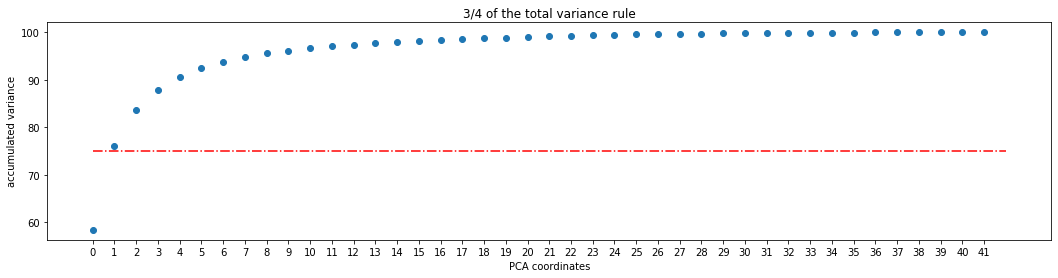

intensities for band  gamma and session 1
0.13449979225794476 minuts for classification


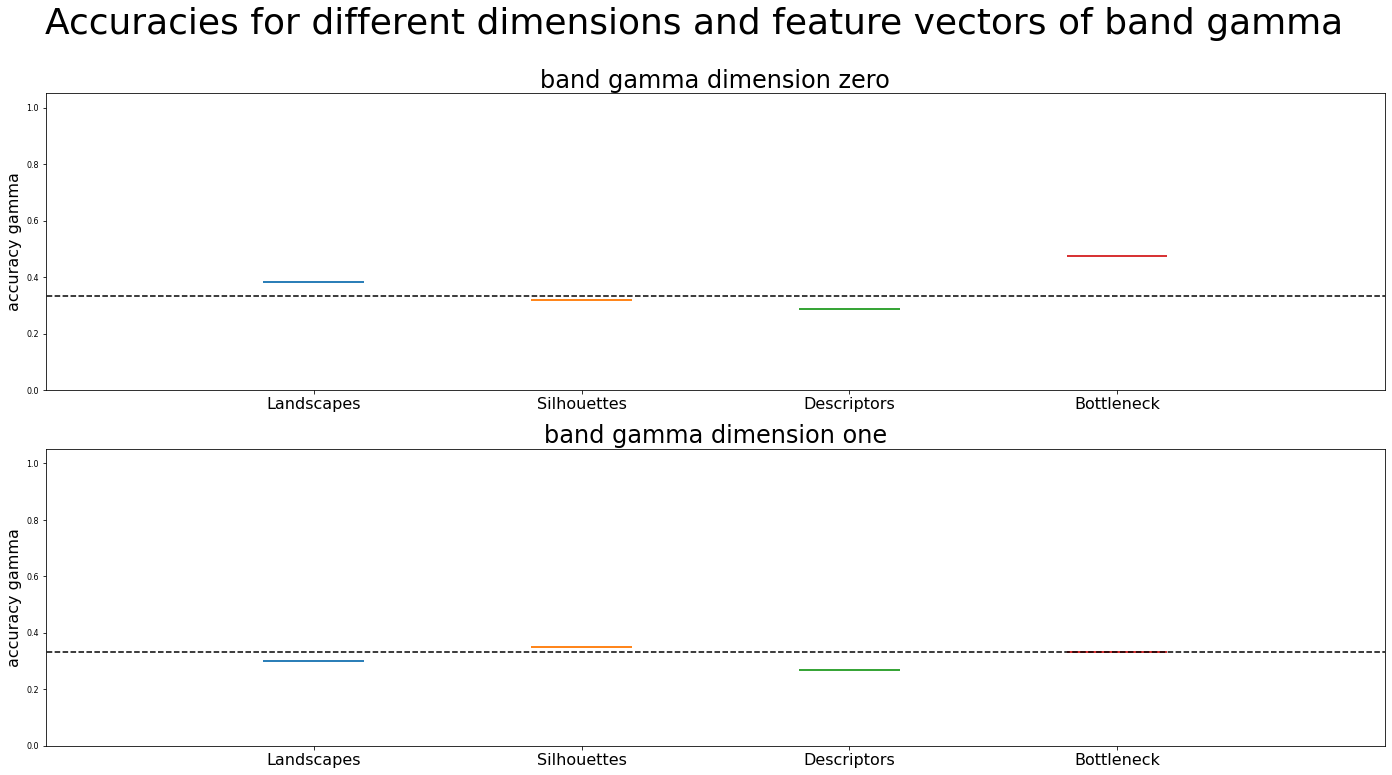

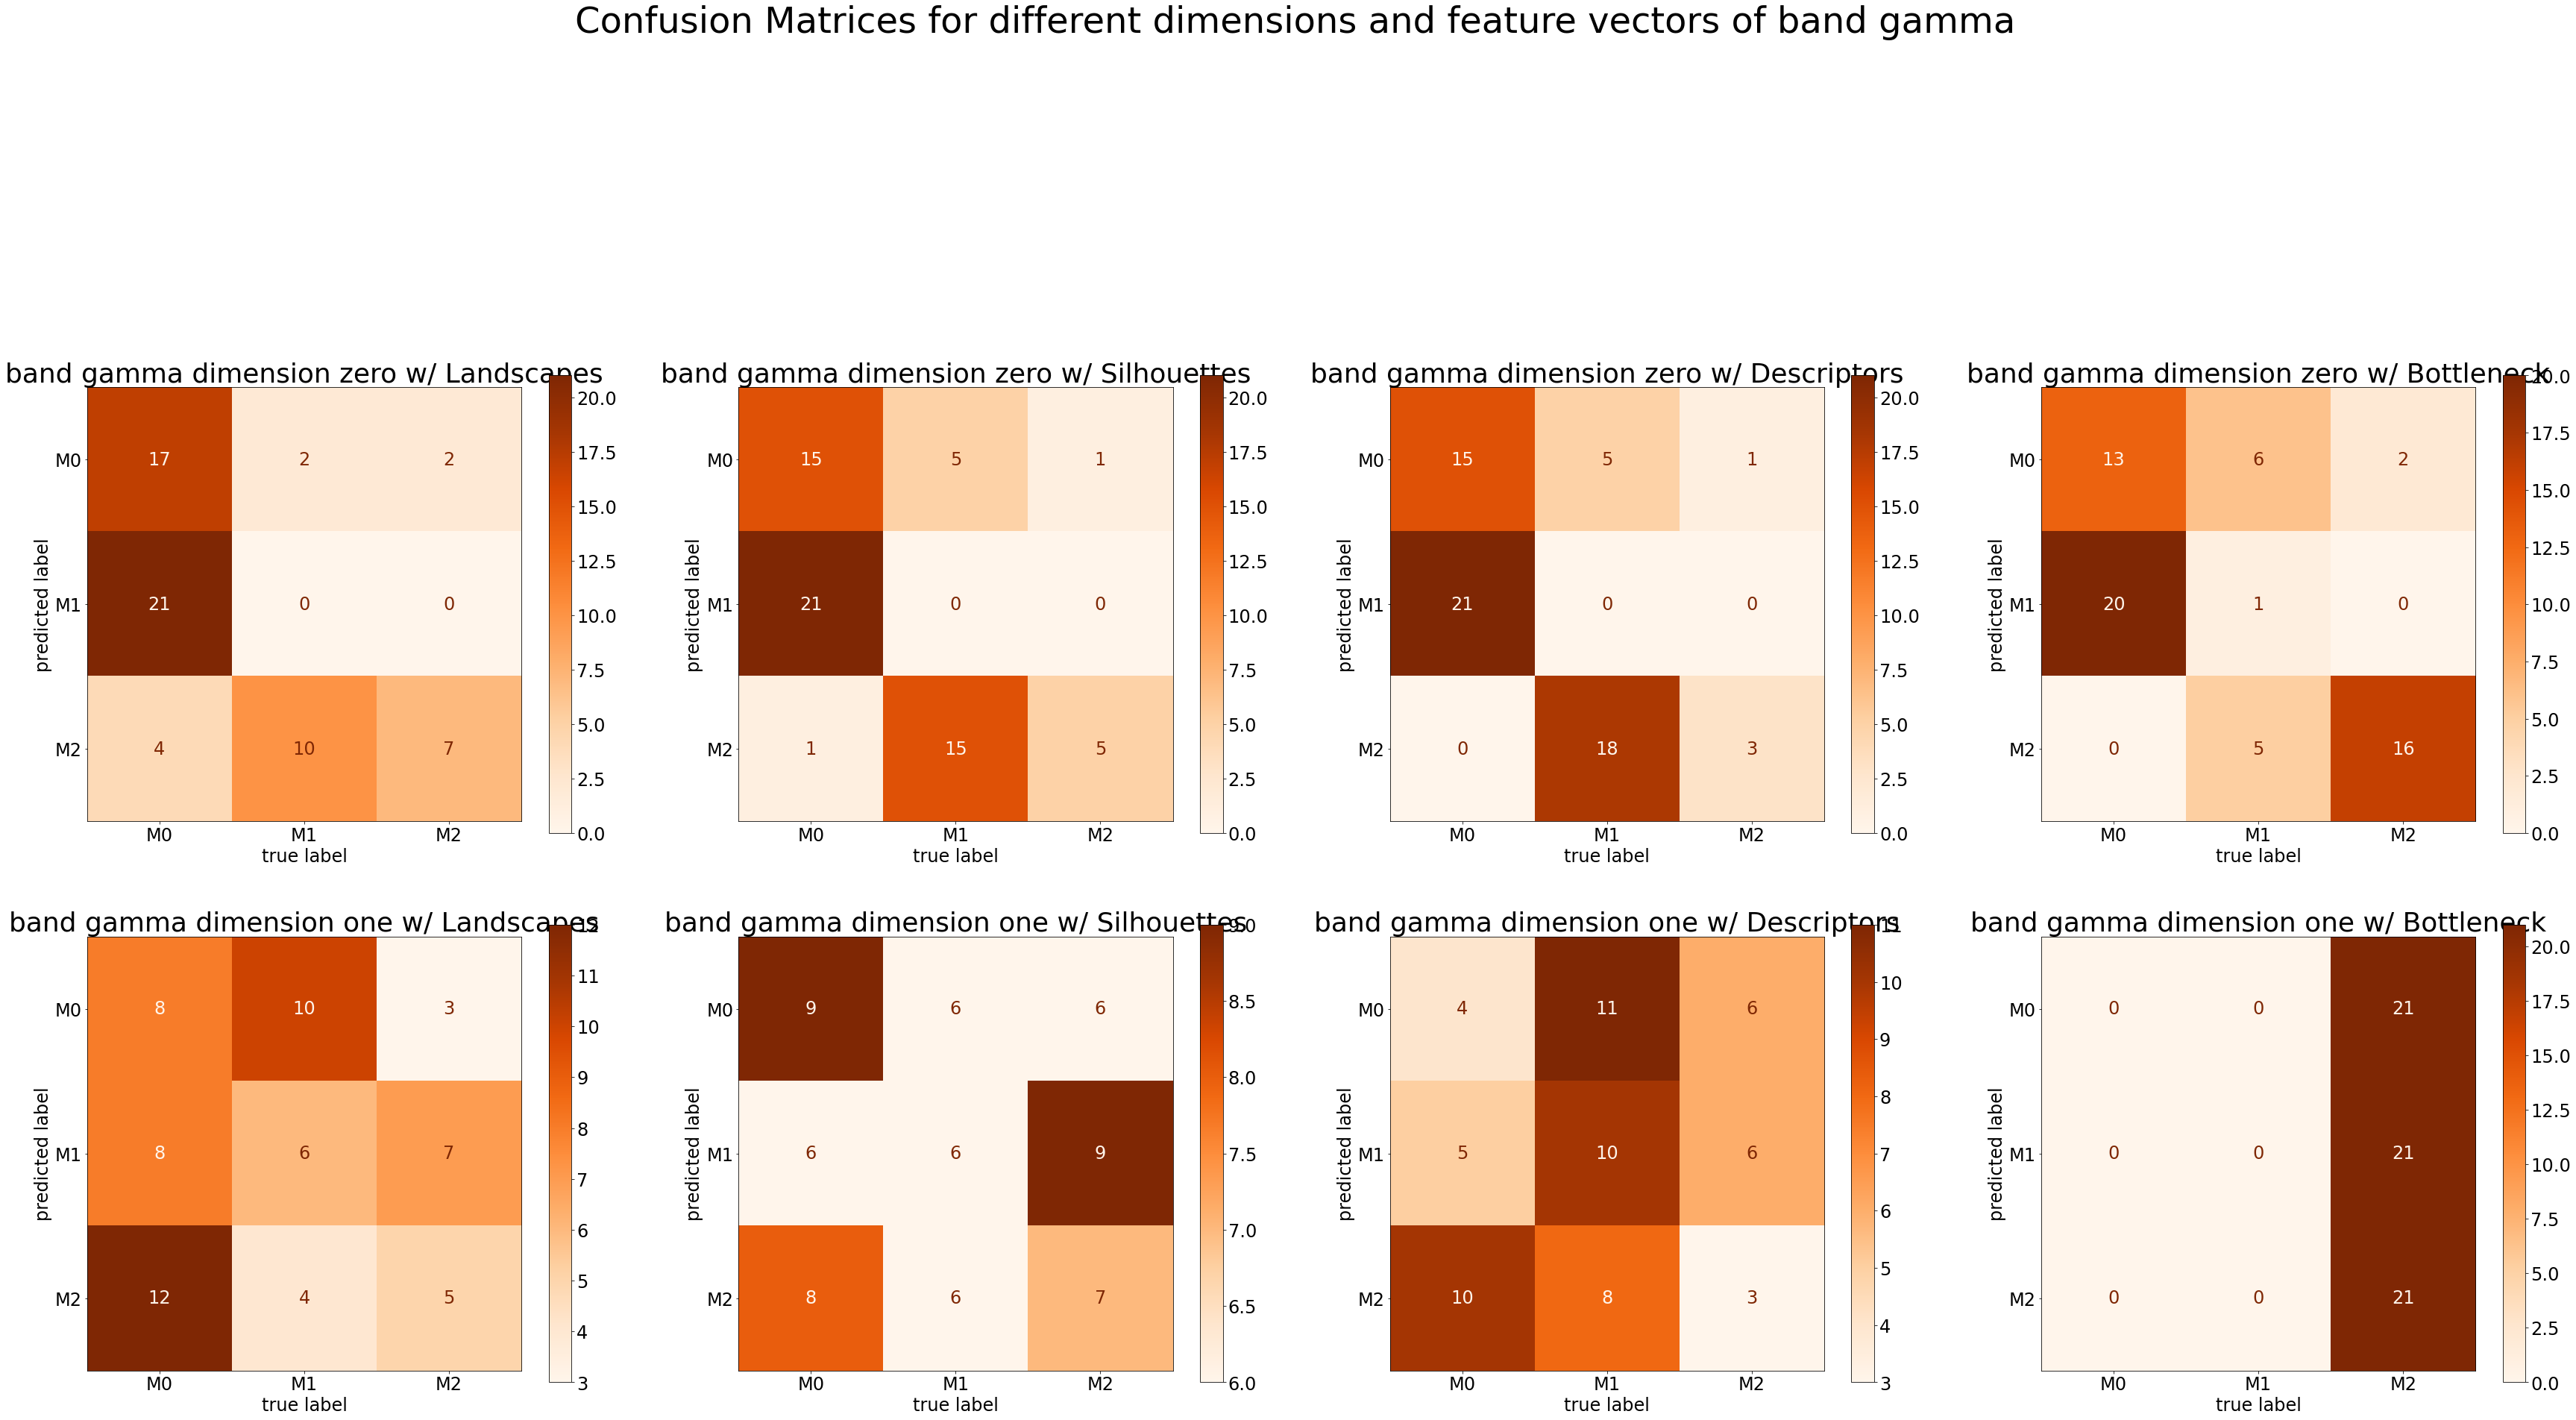

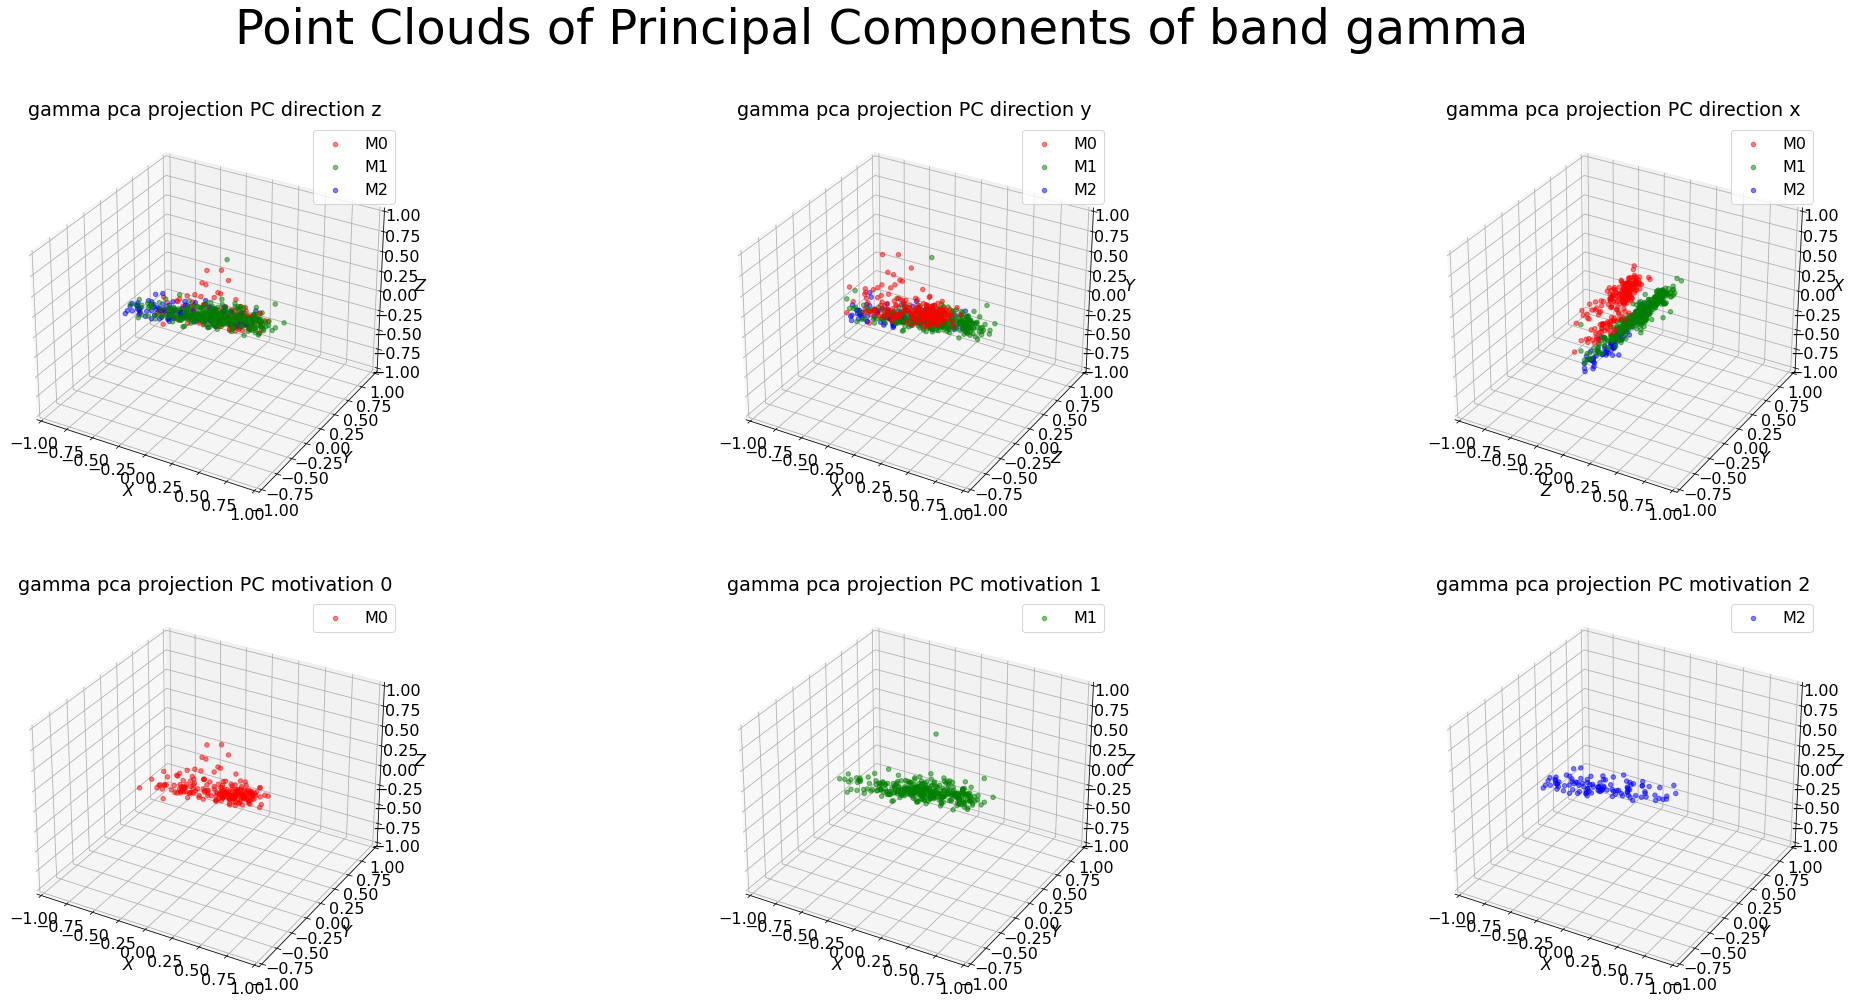

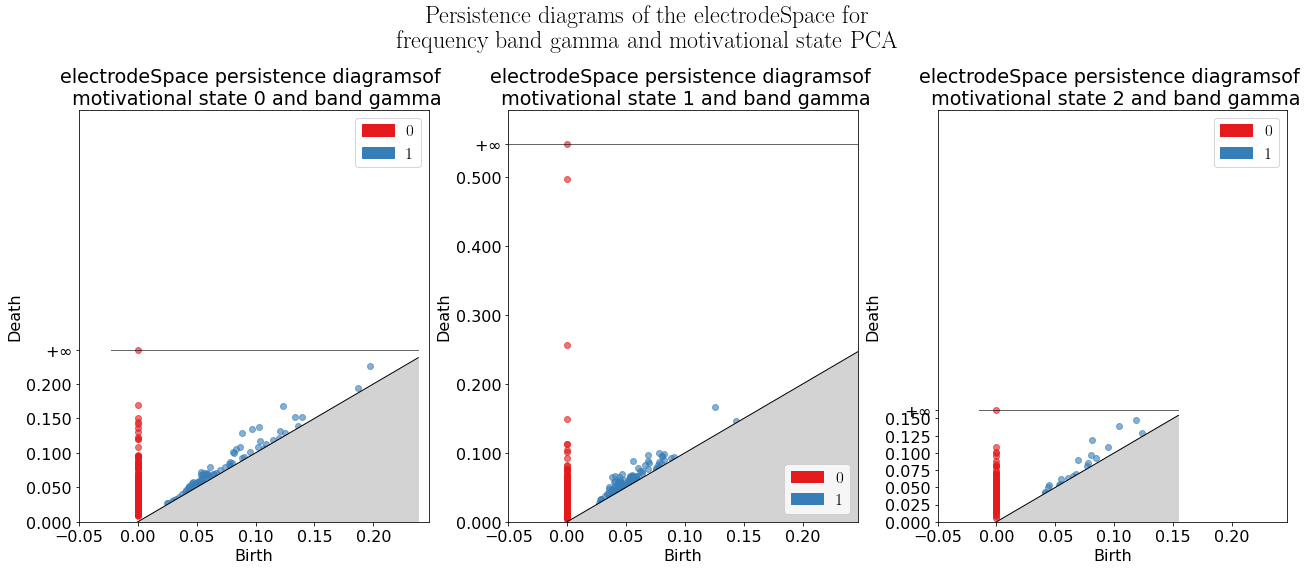

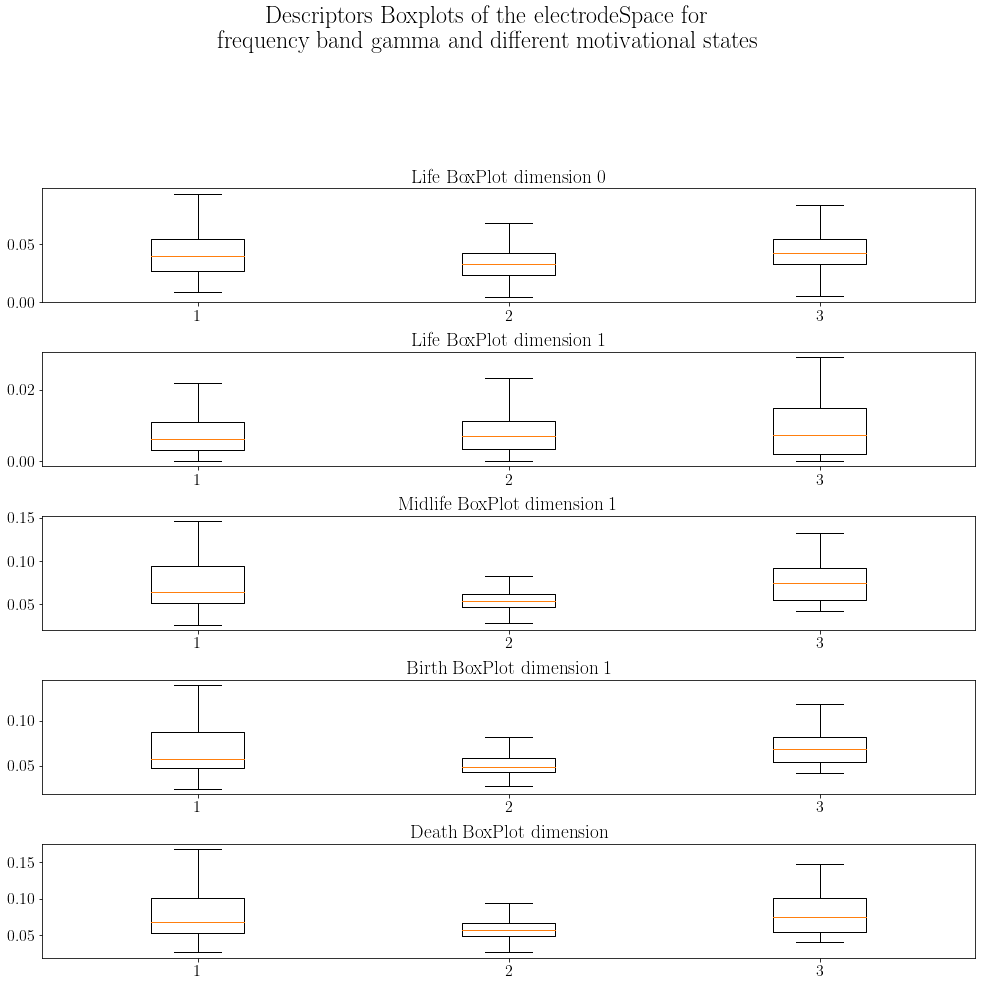

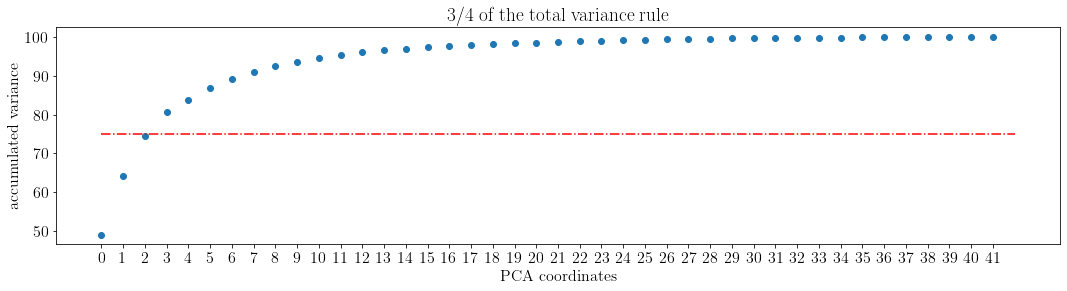

intensities for band  gamma and session 2
0.14040119647979737 minuts for classification


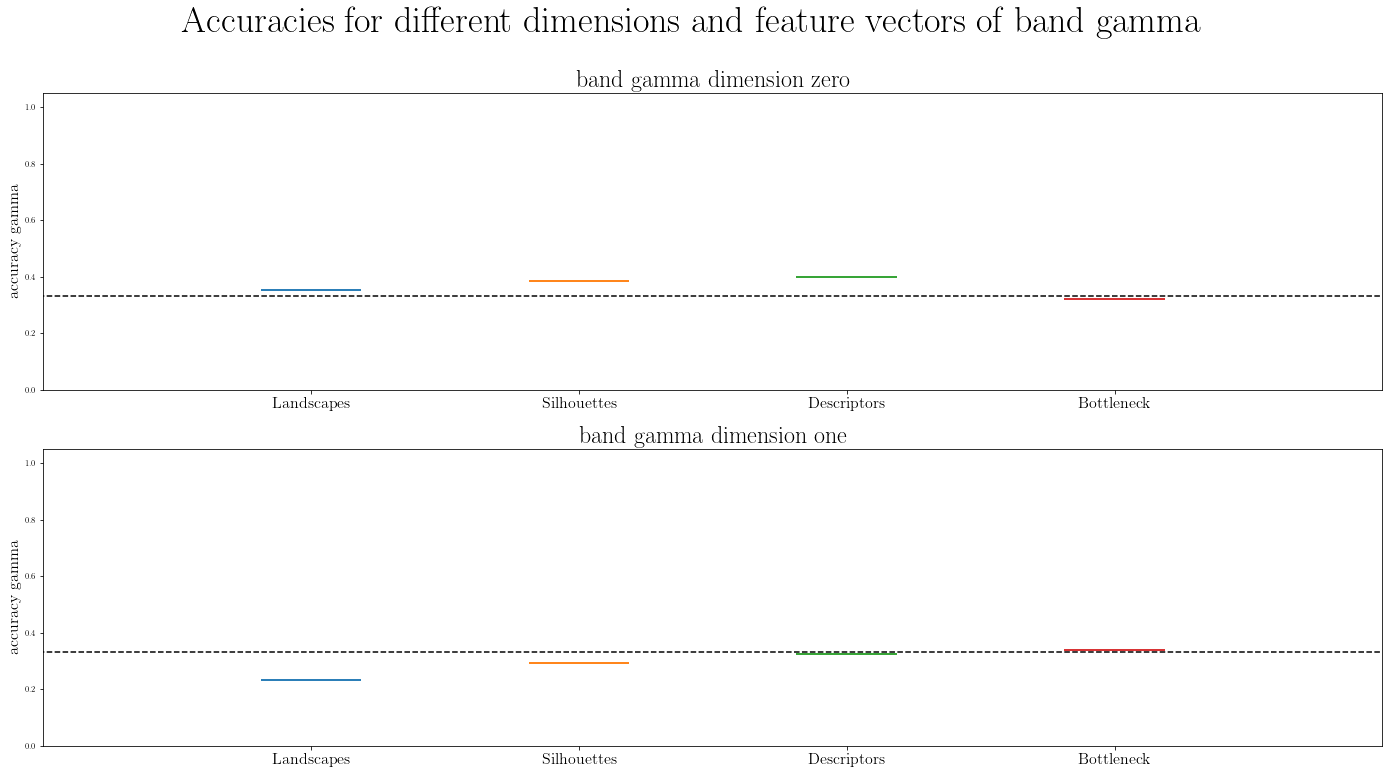

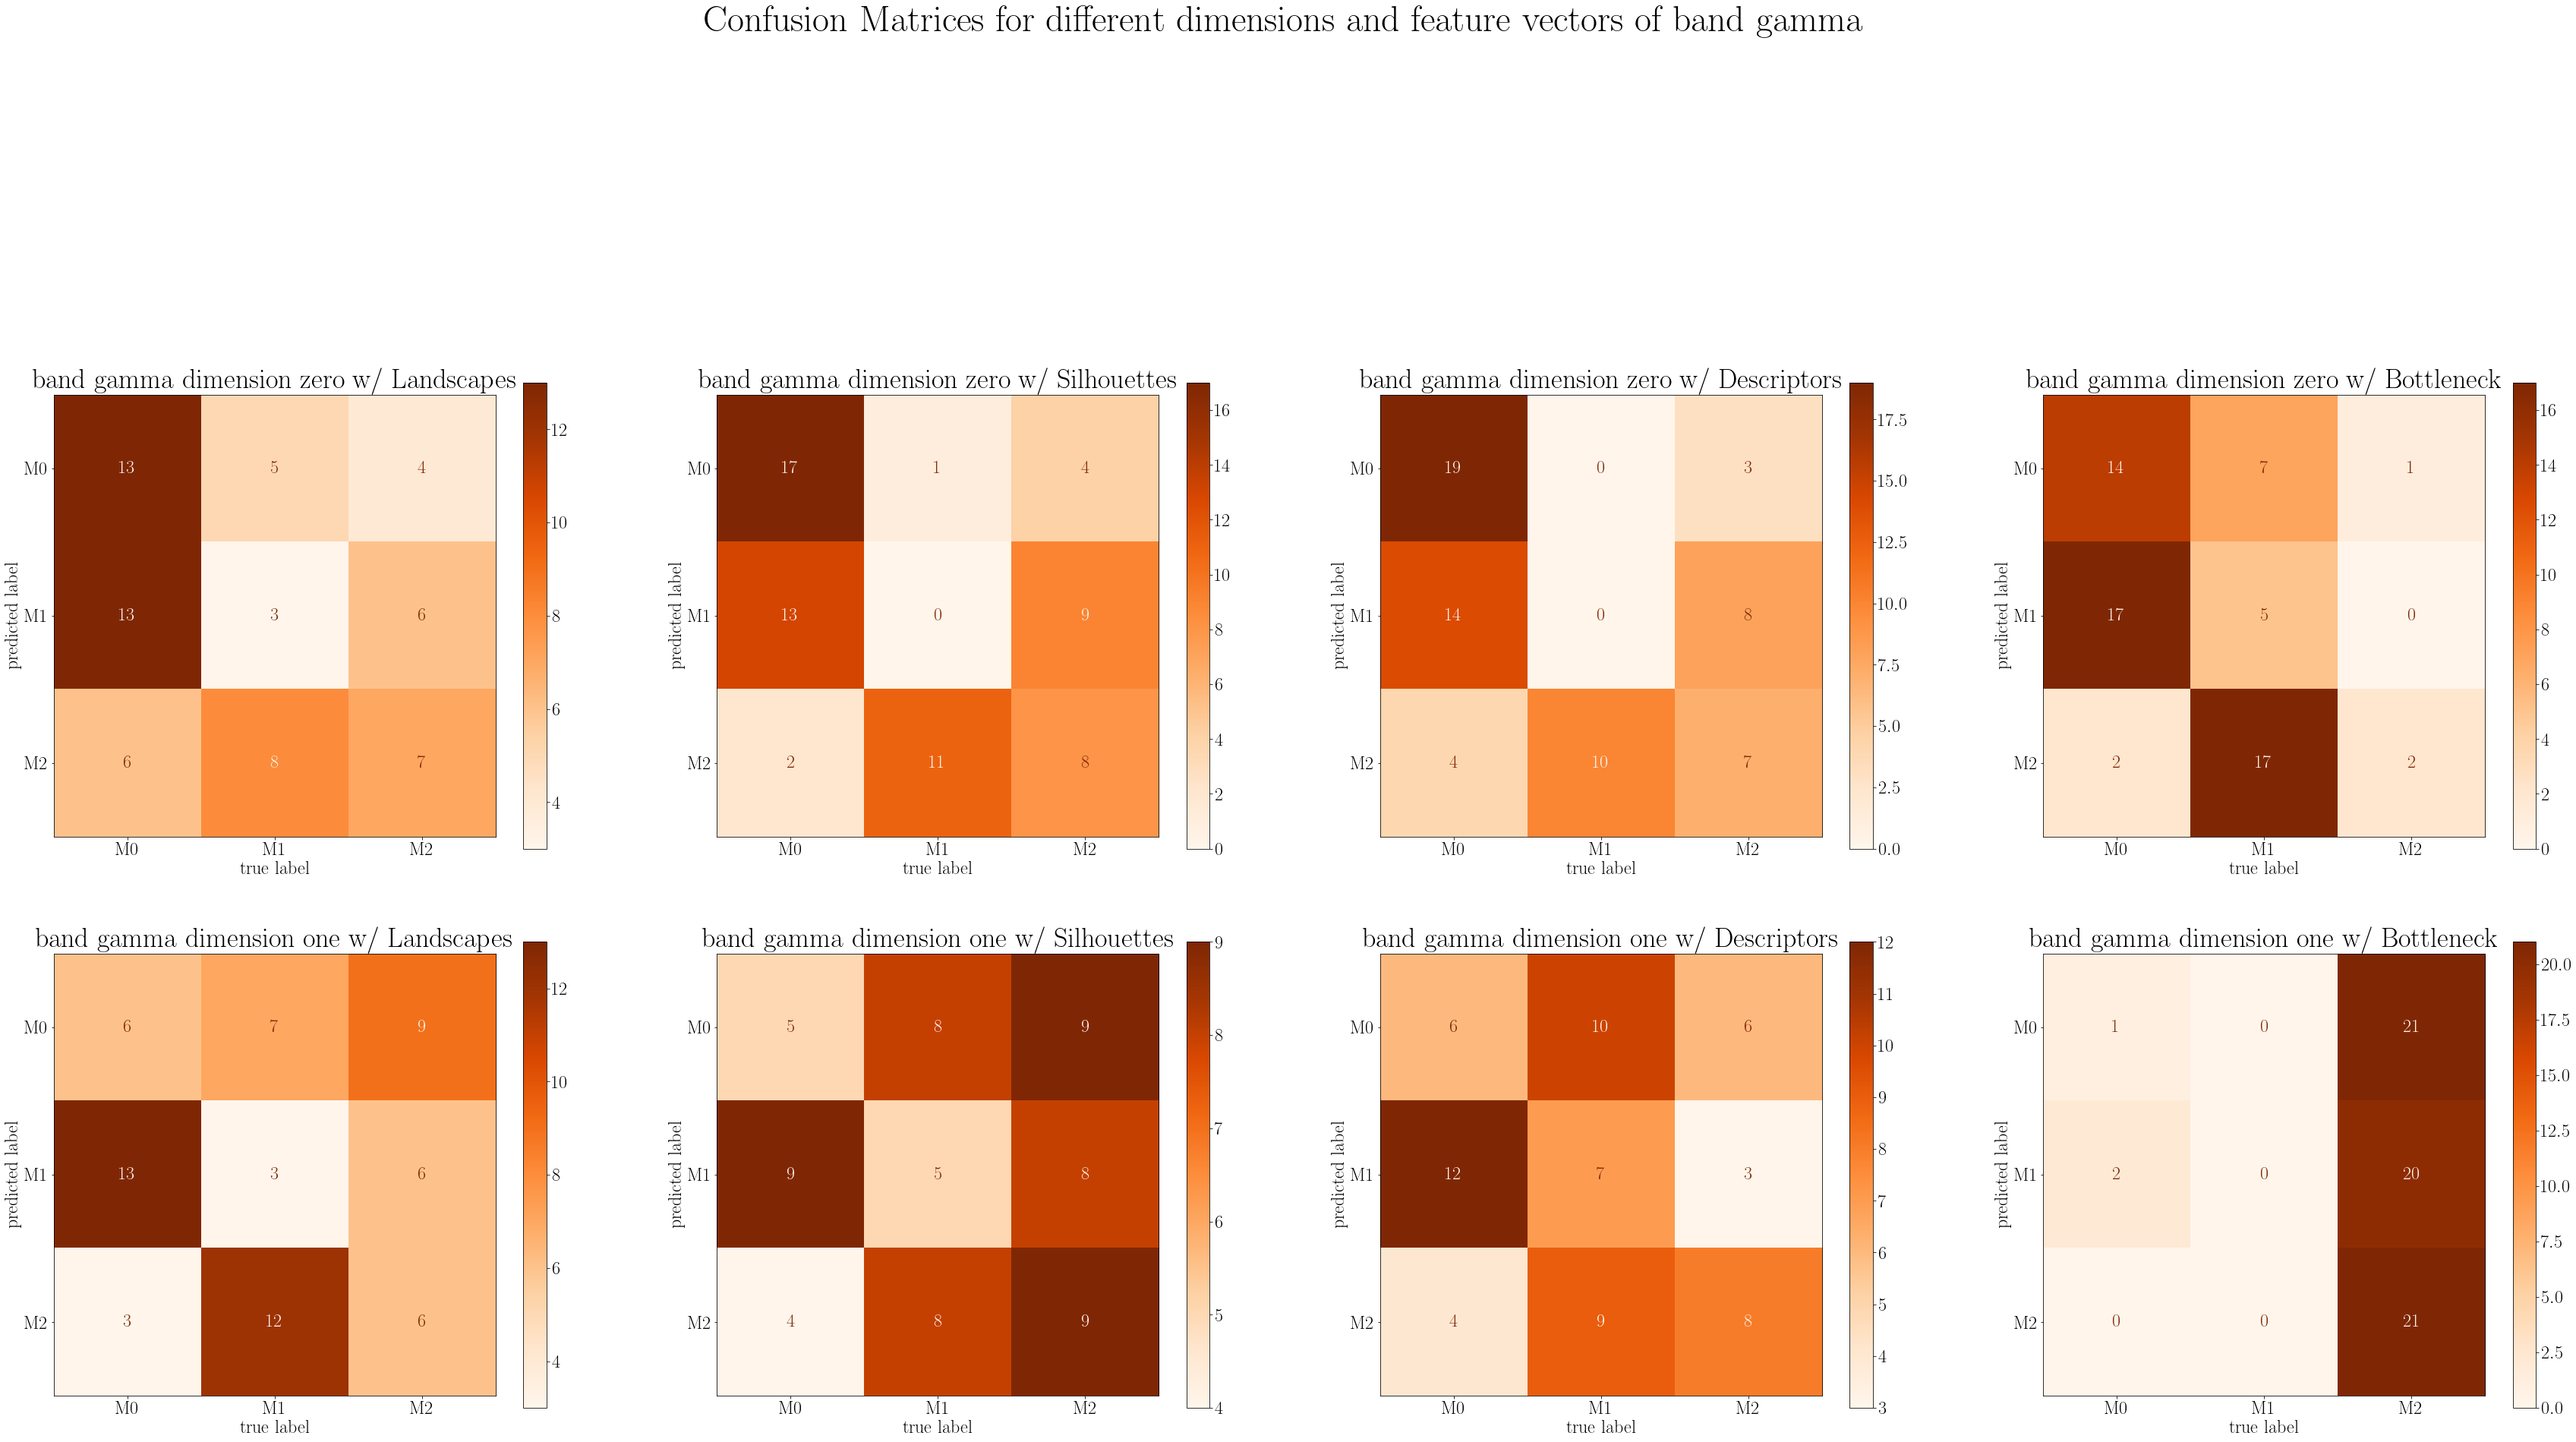

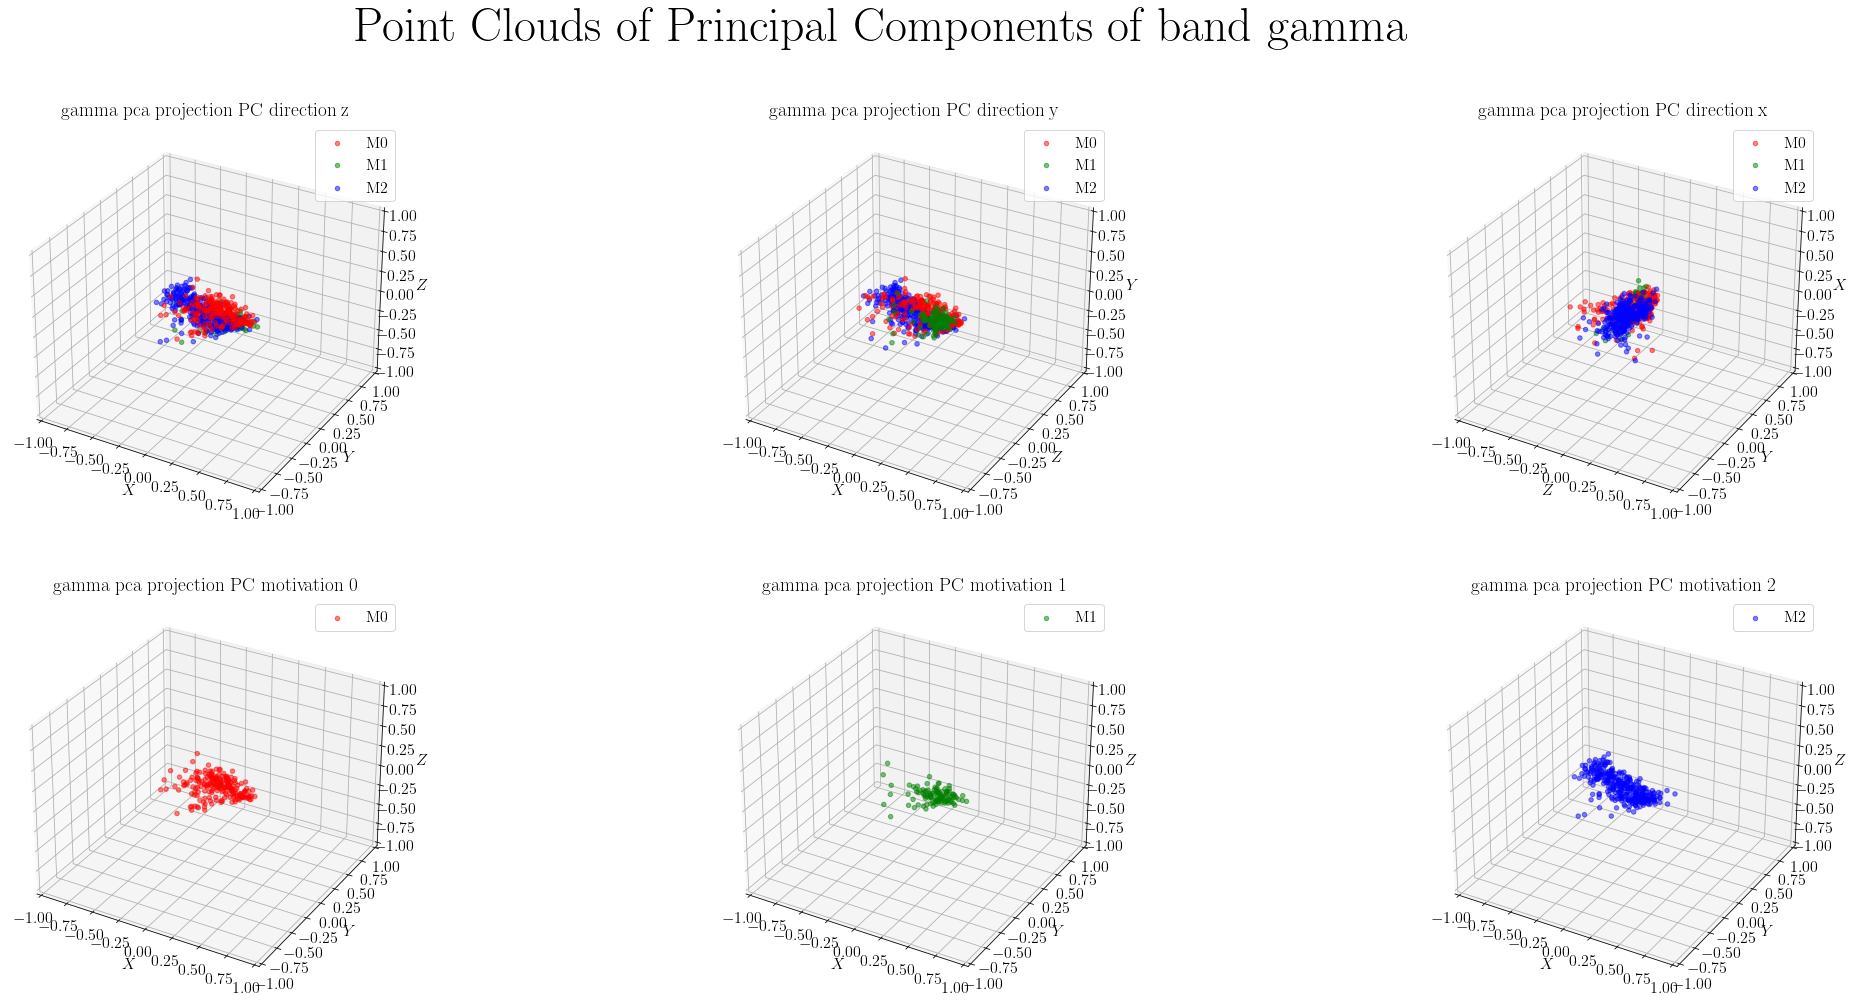

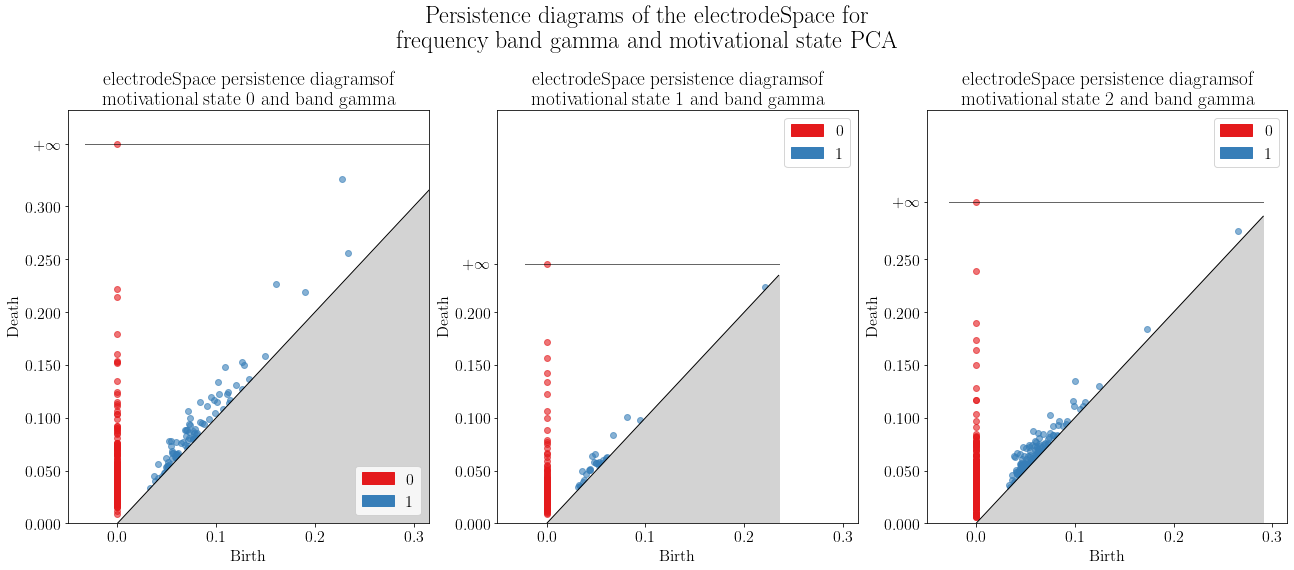

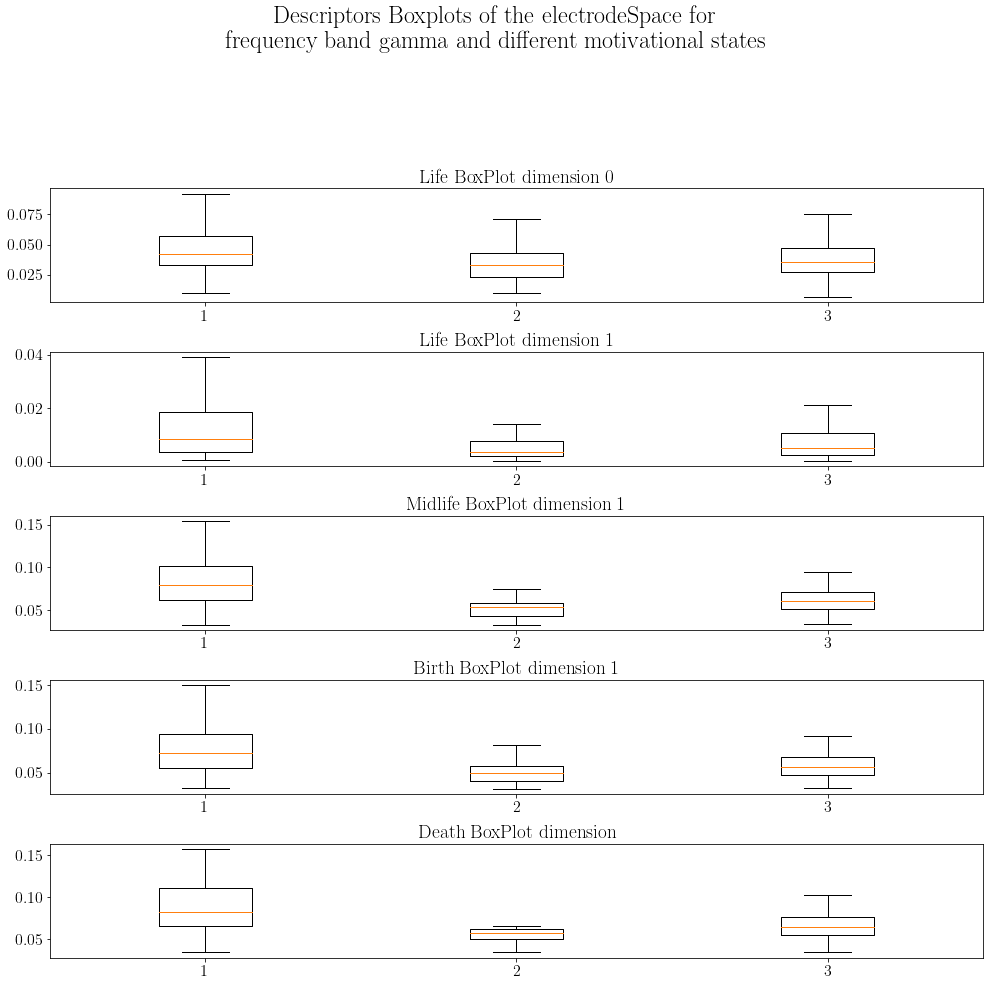

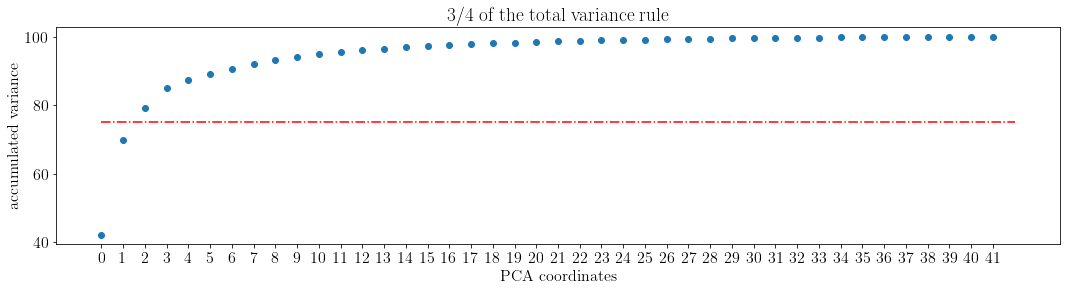

intensities for band  beta and session 1
0.1351798137029012 minuts for classification


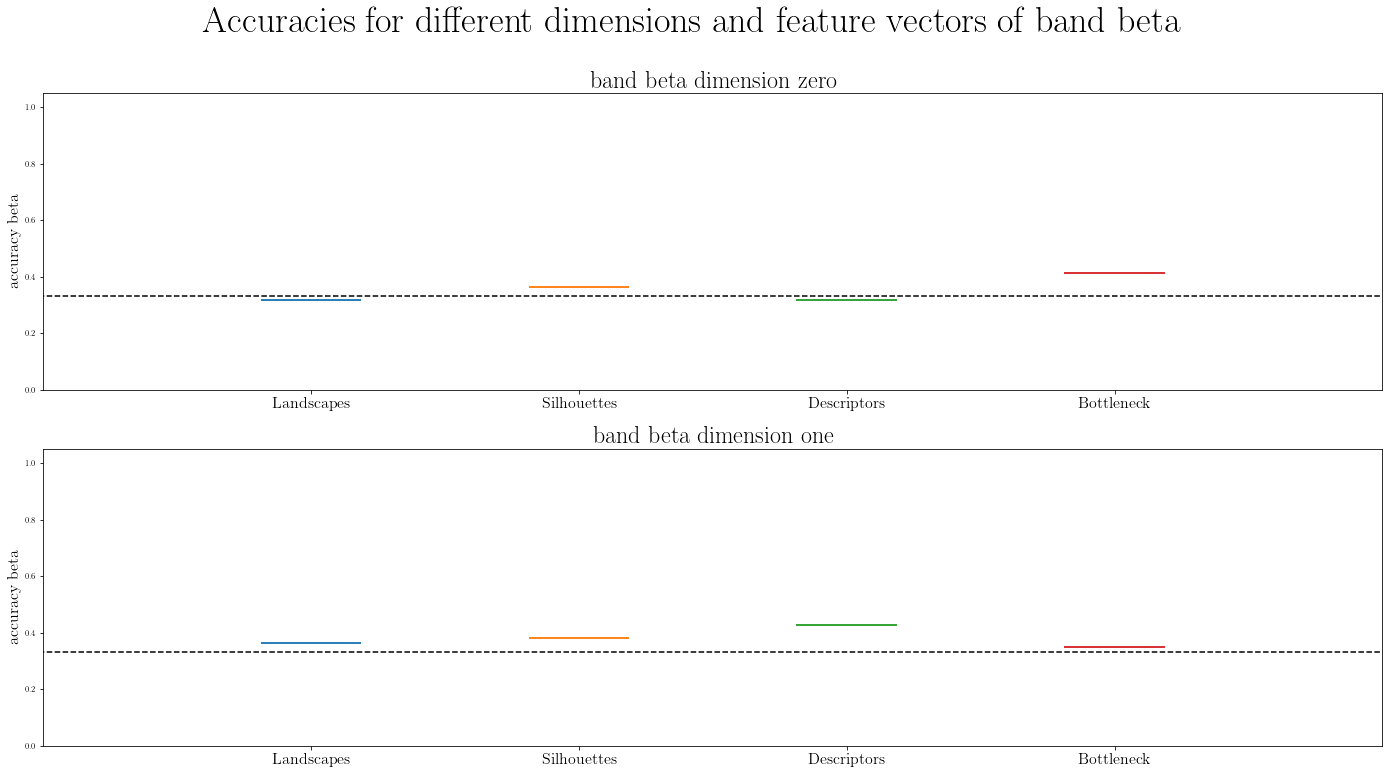

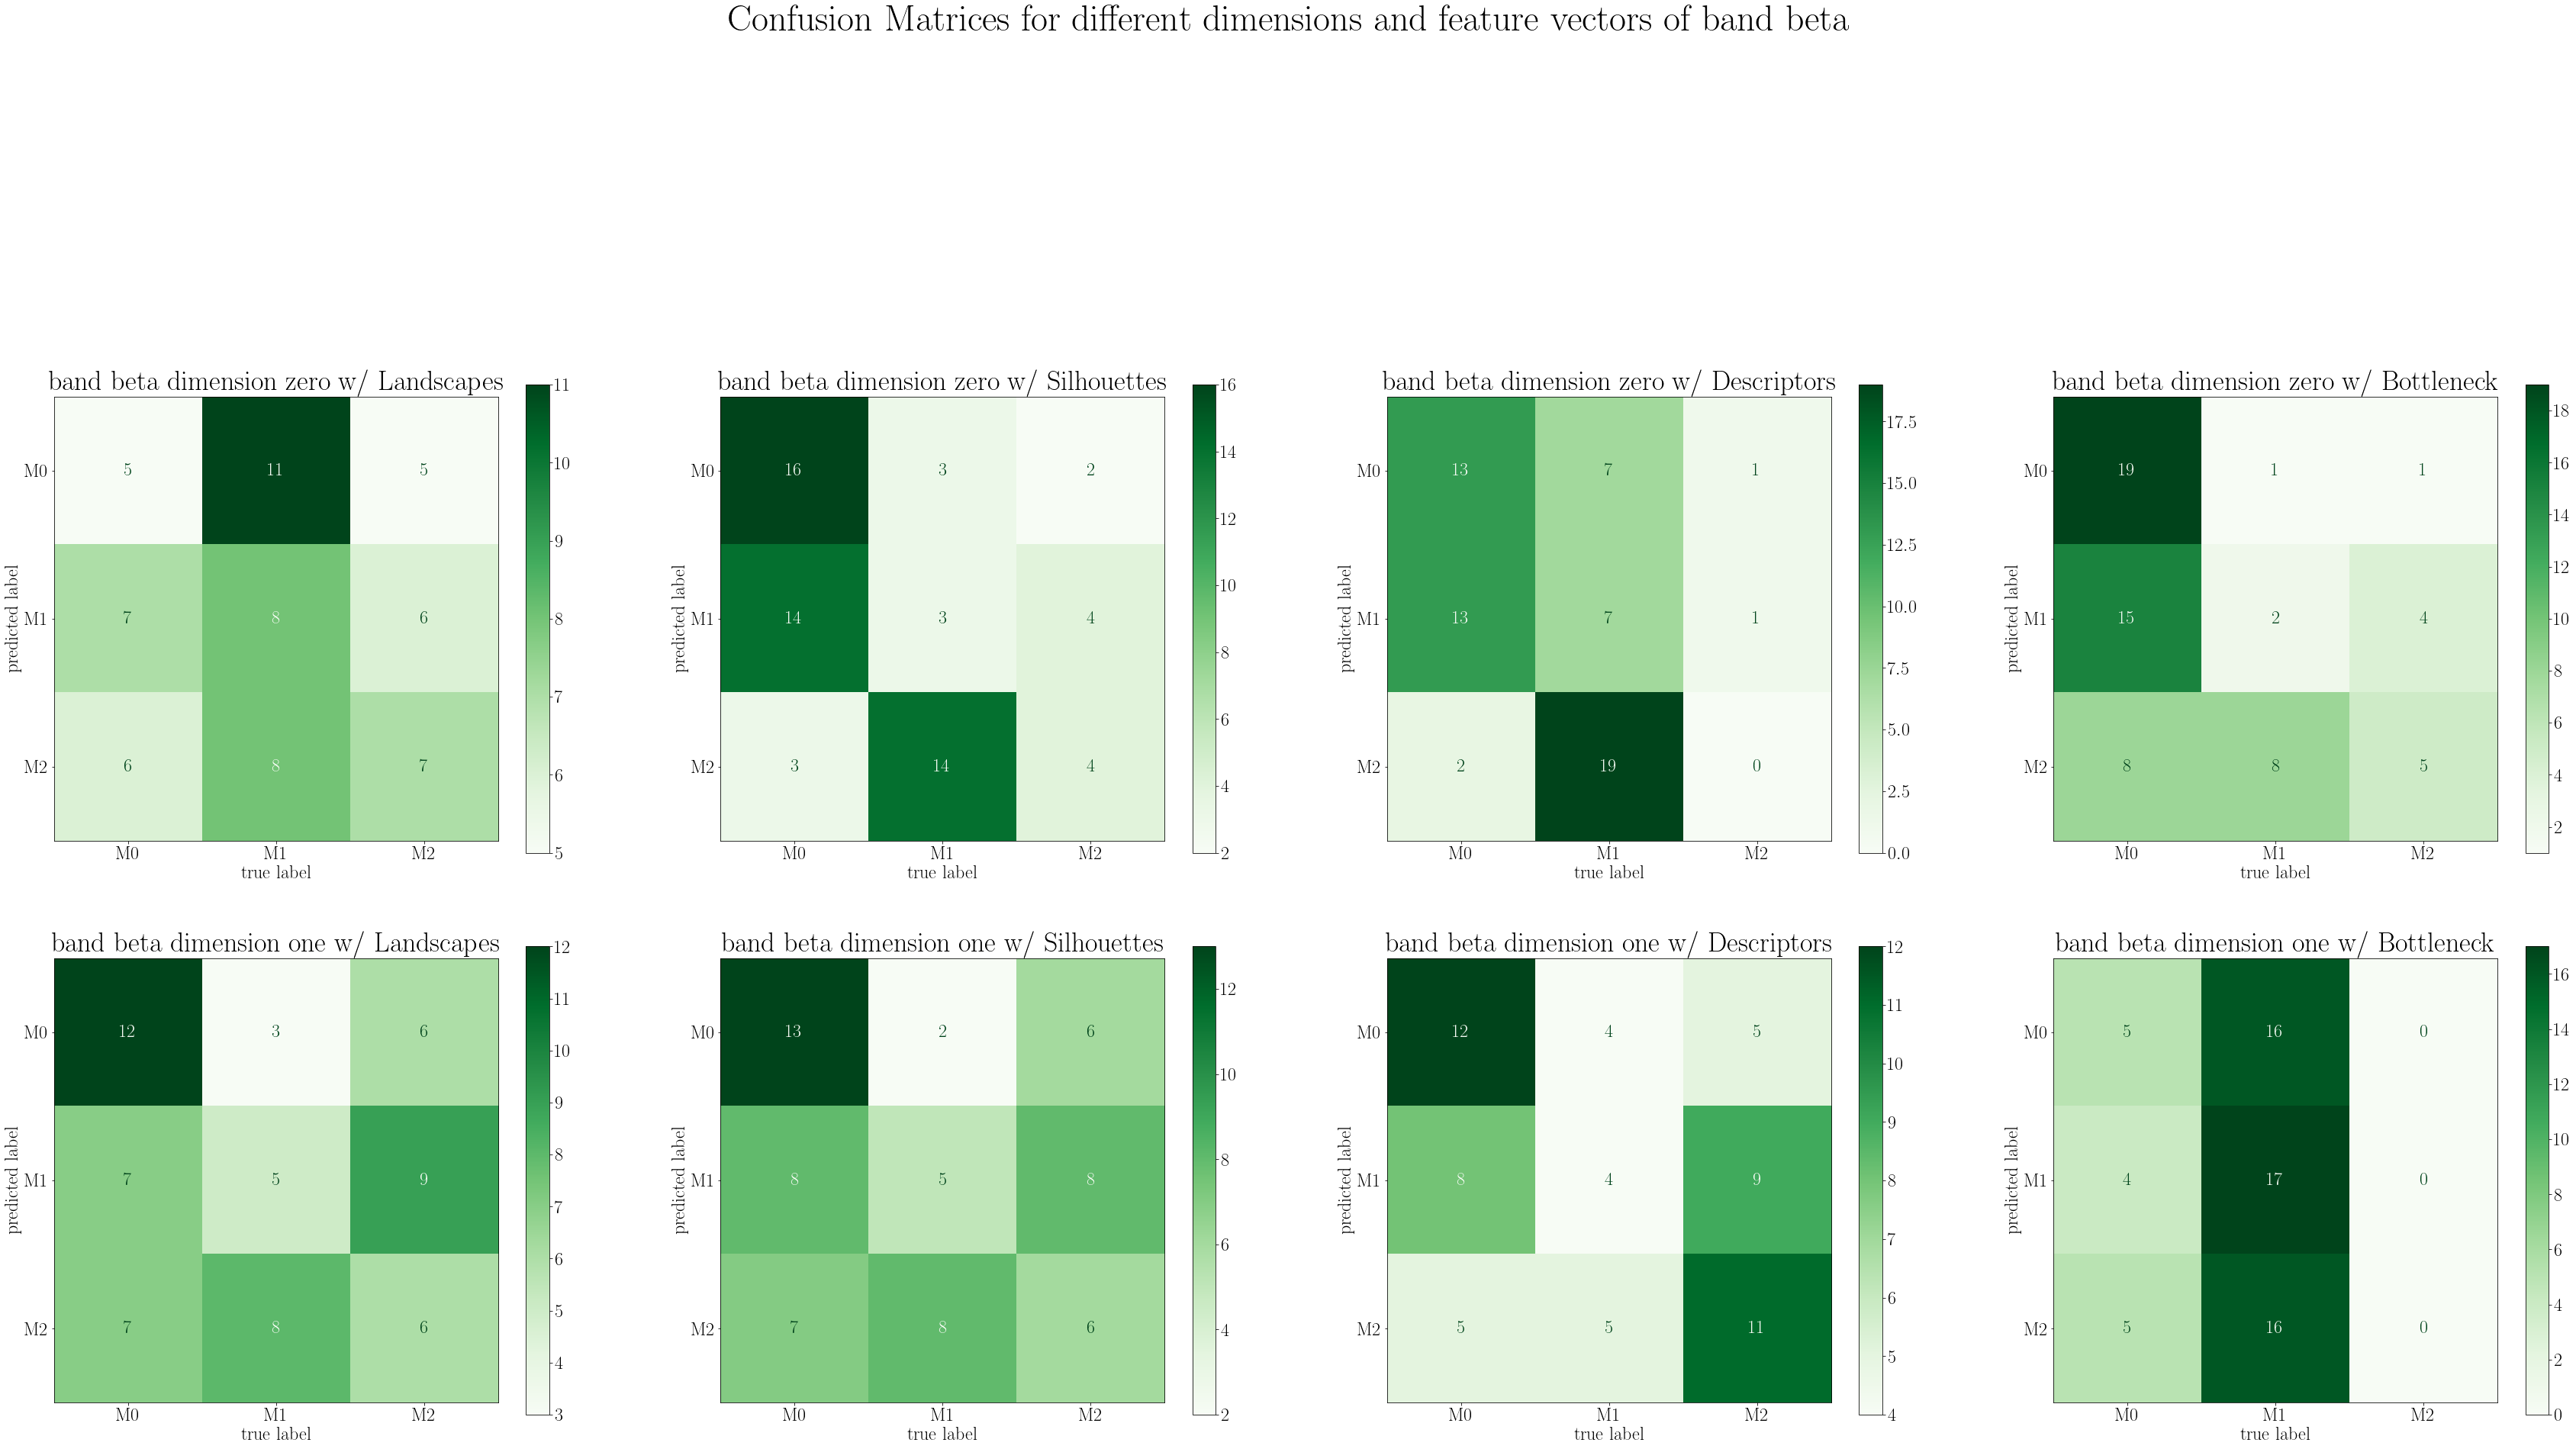

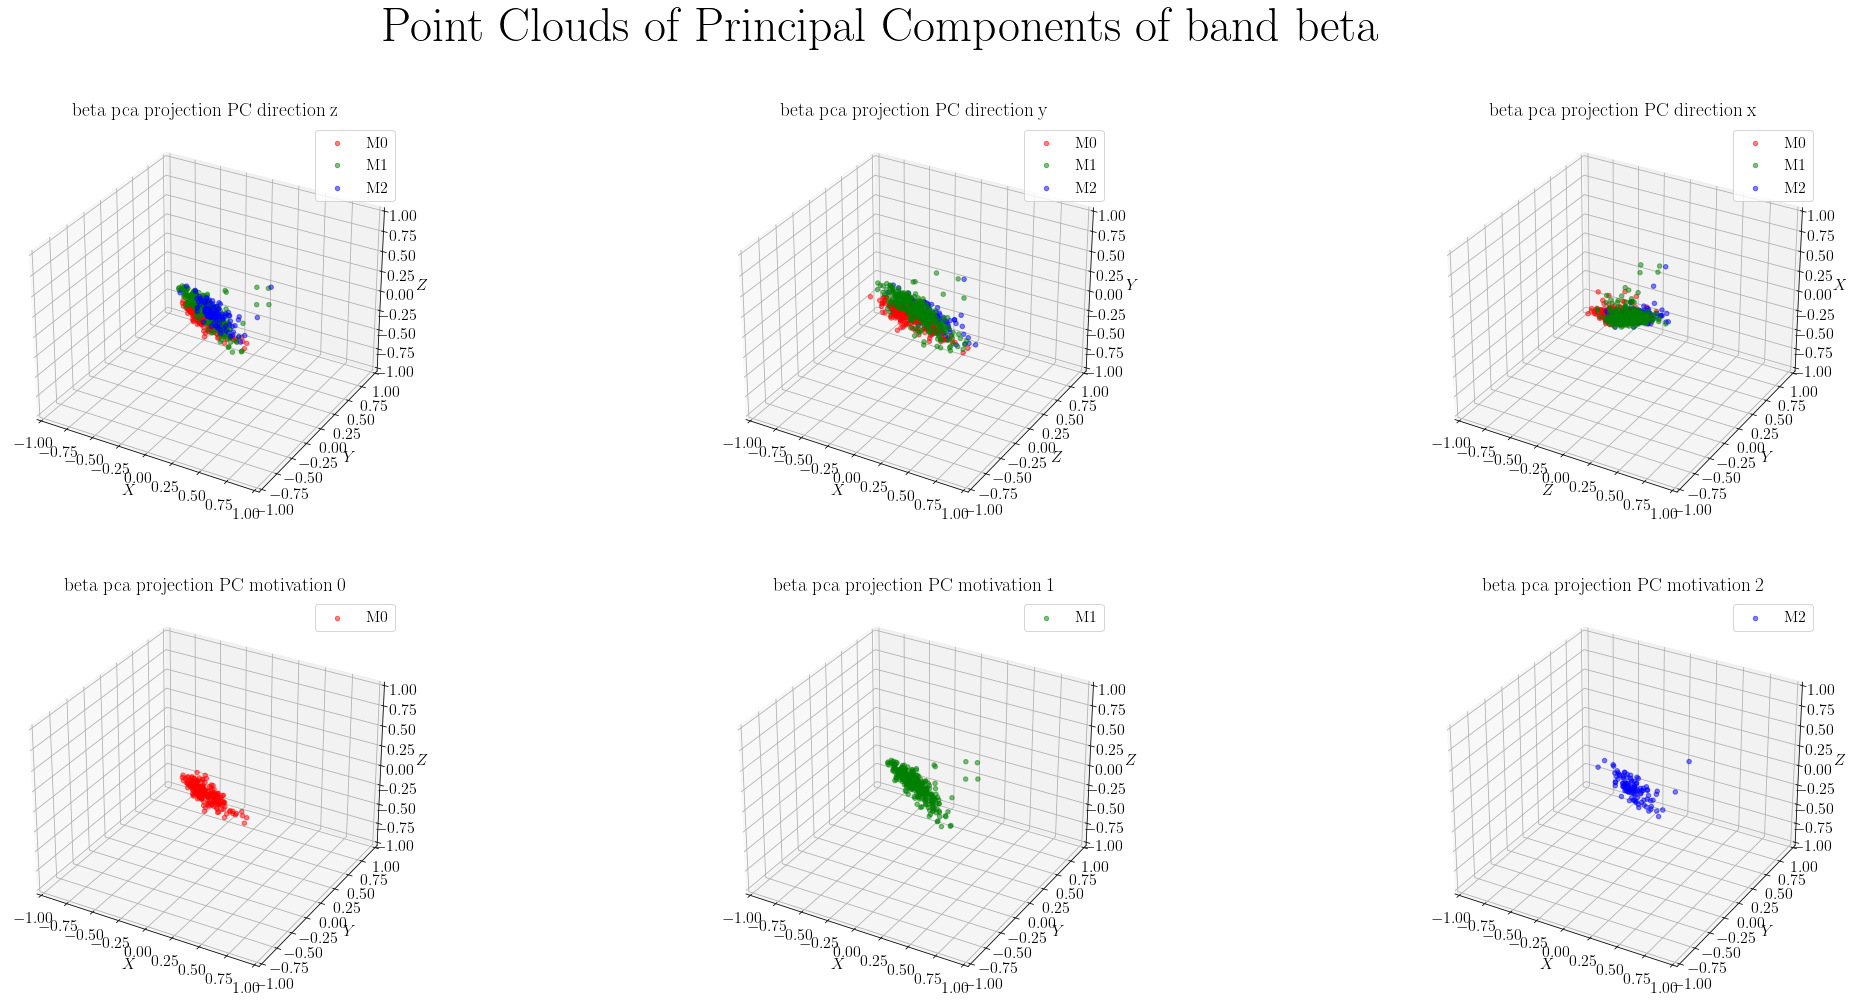

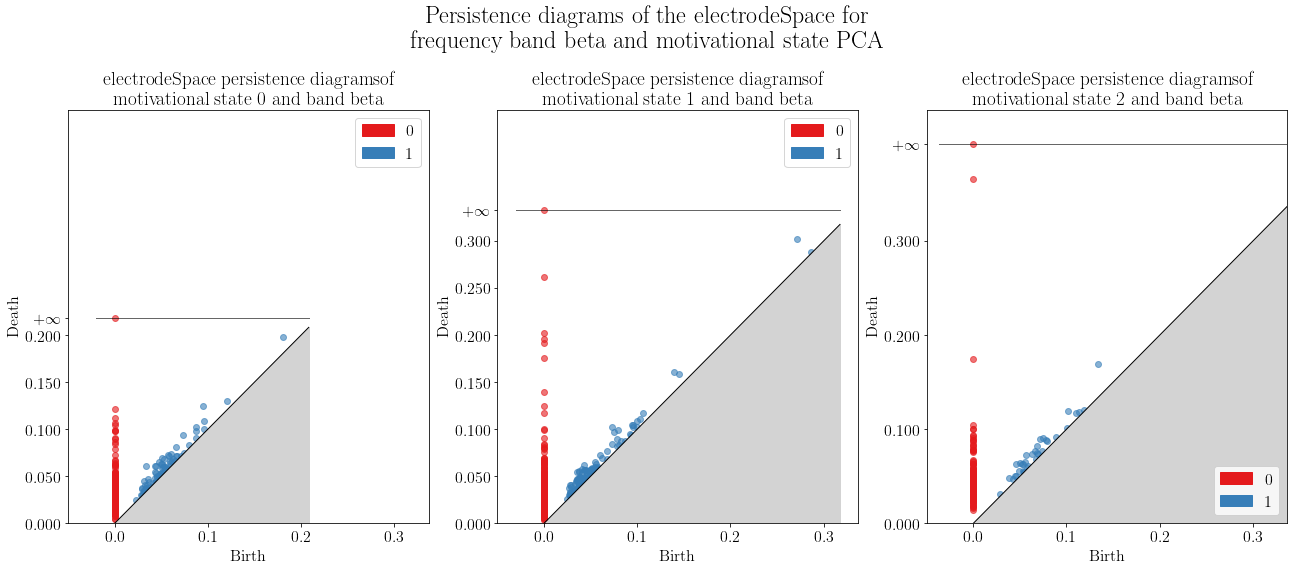

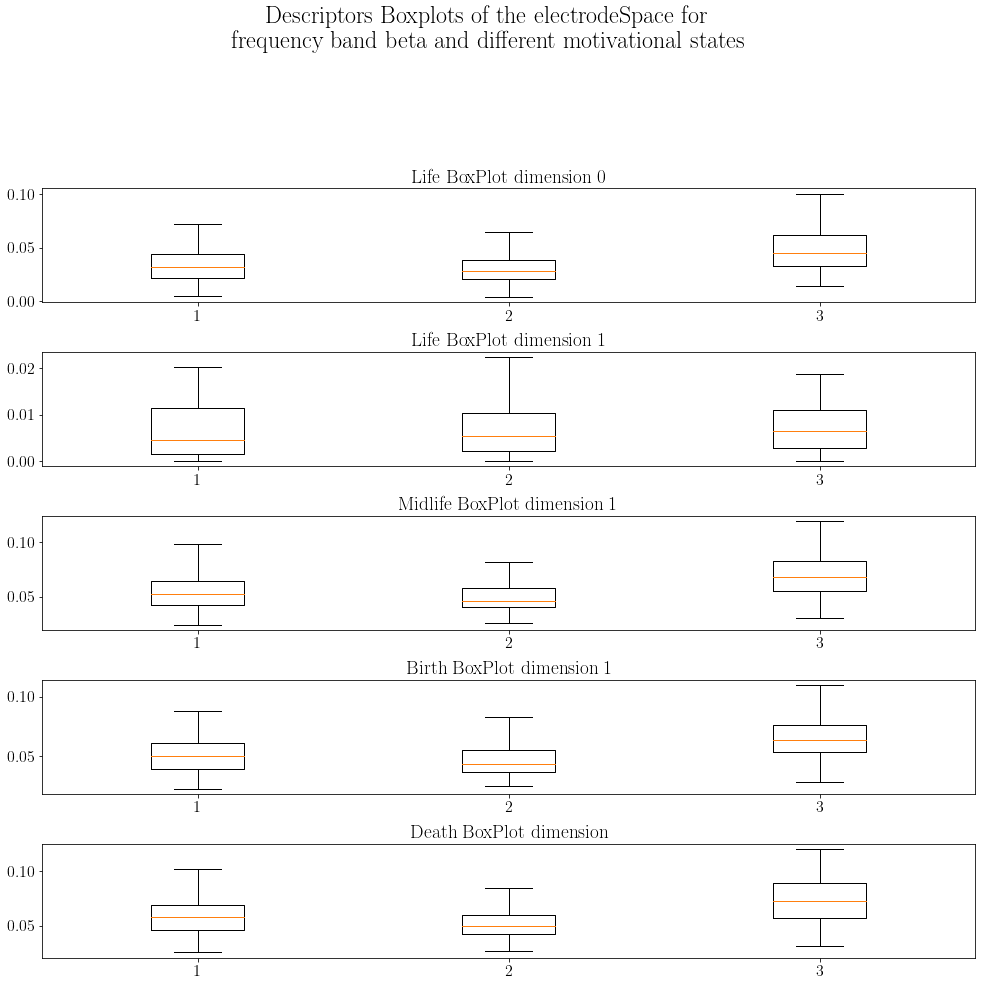

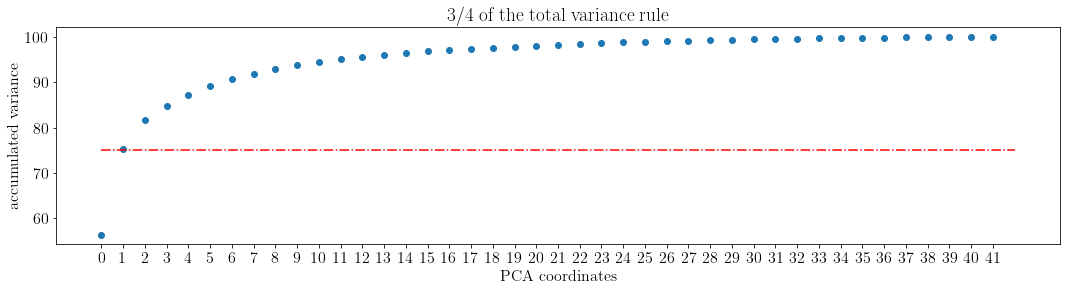

intensities for band  beta and session 2
0.16523935794830322 minuts for classification


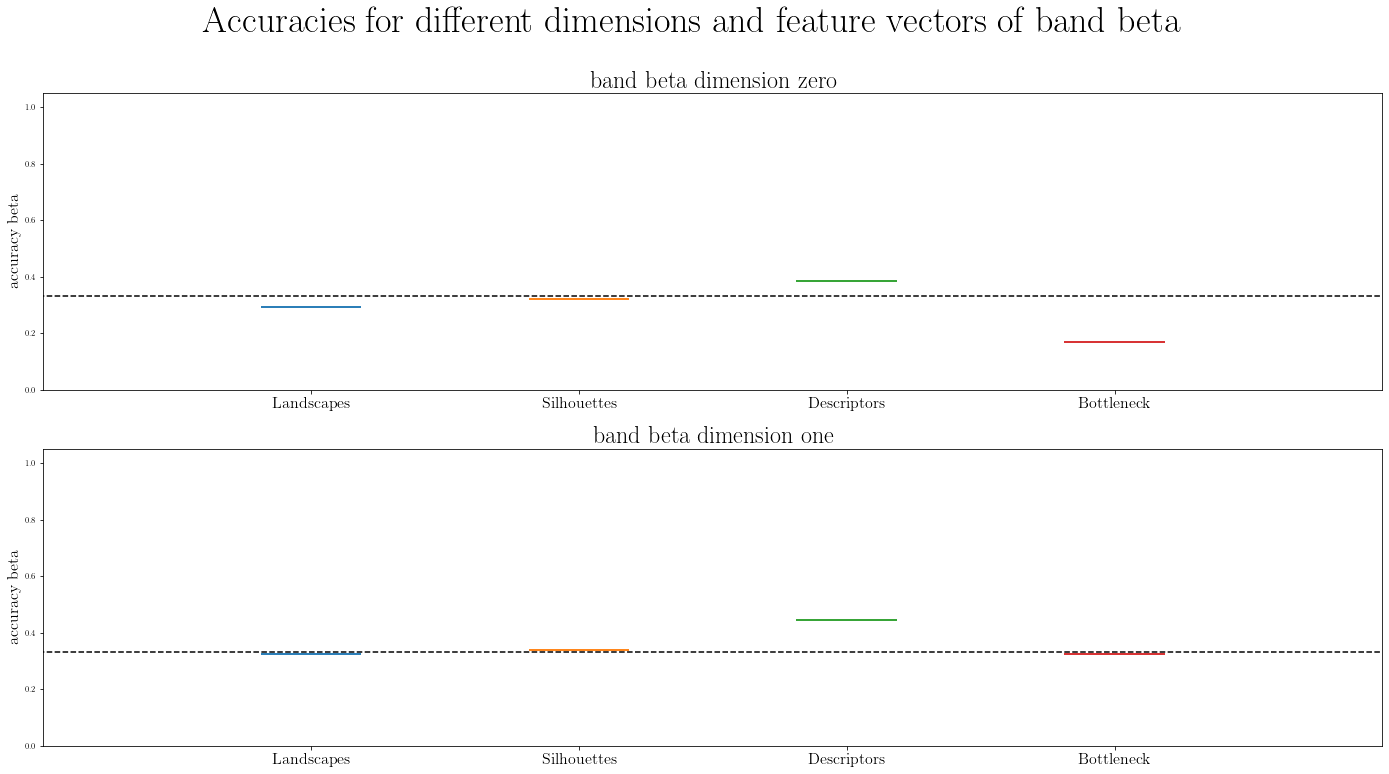

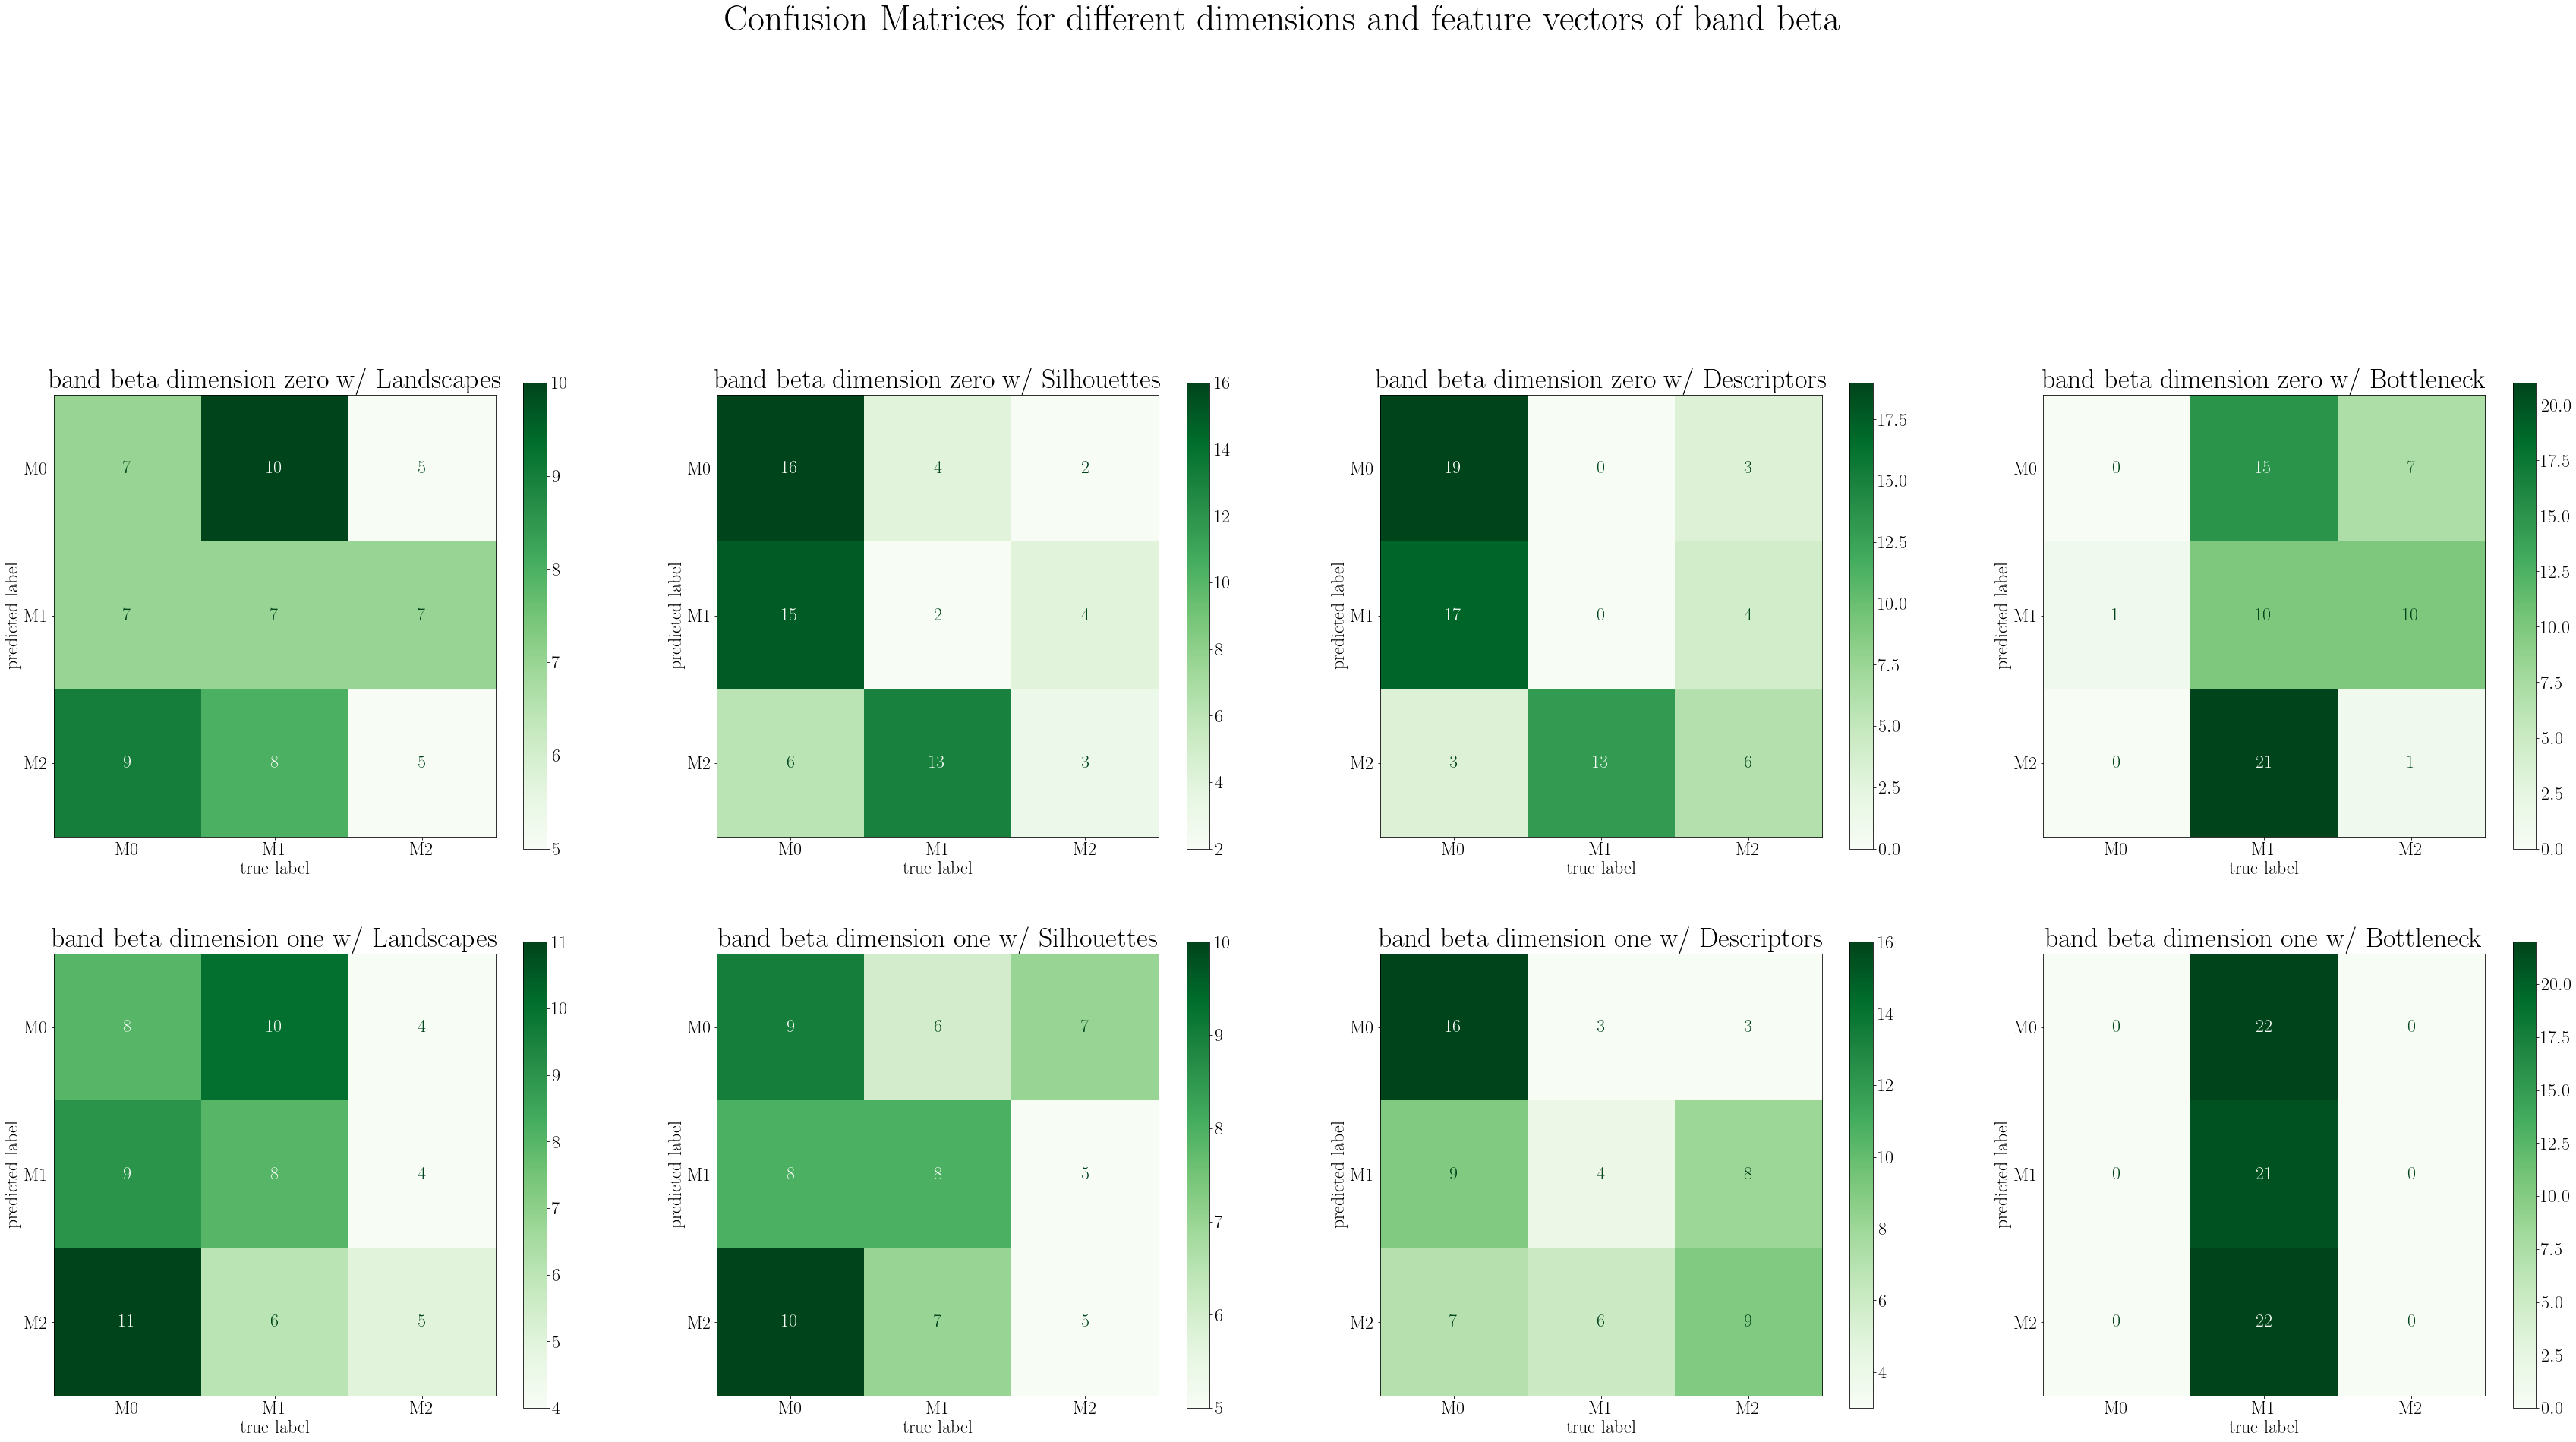

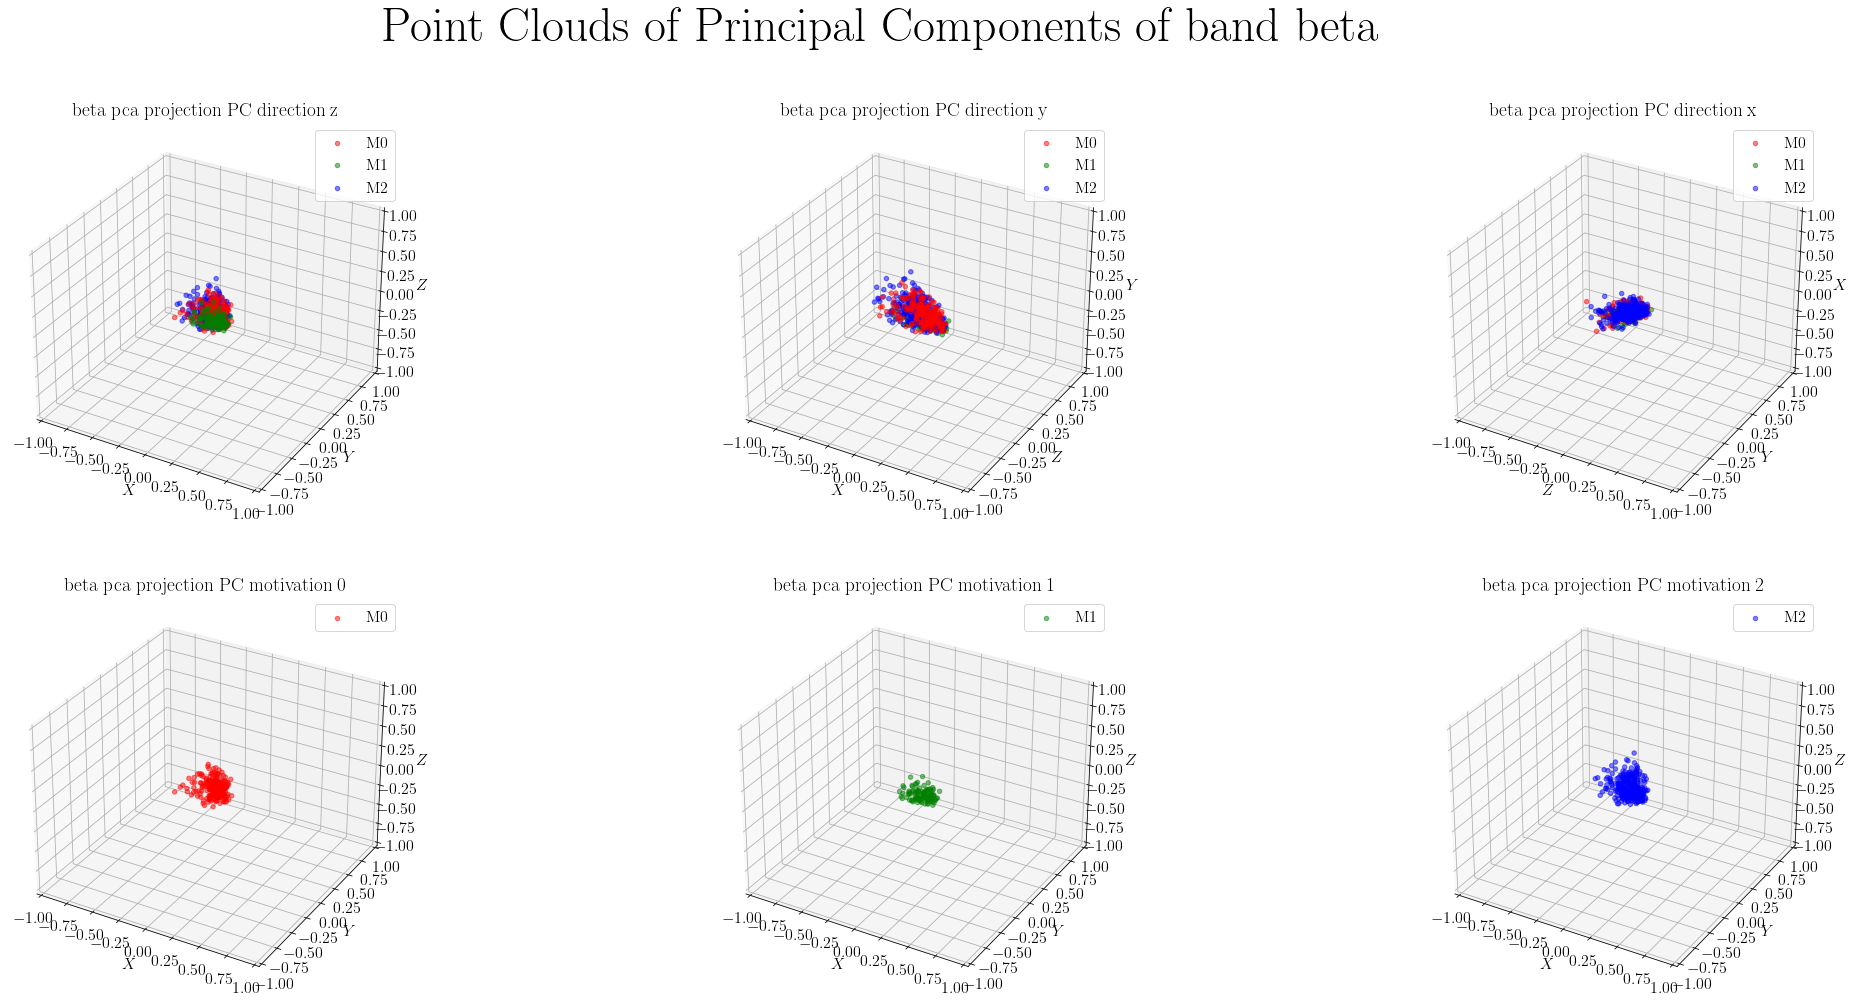

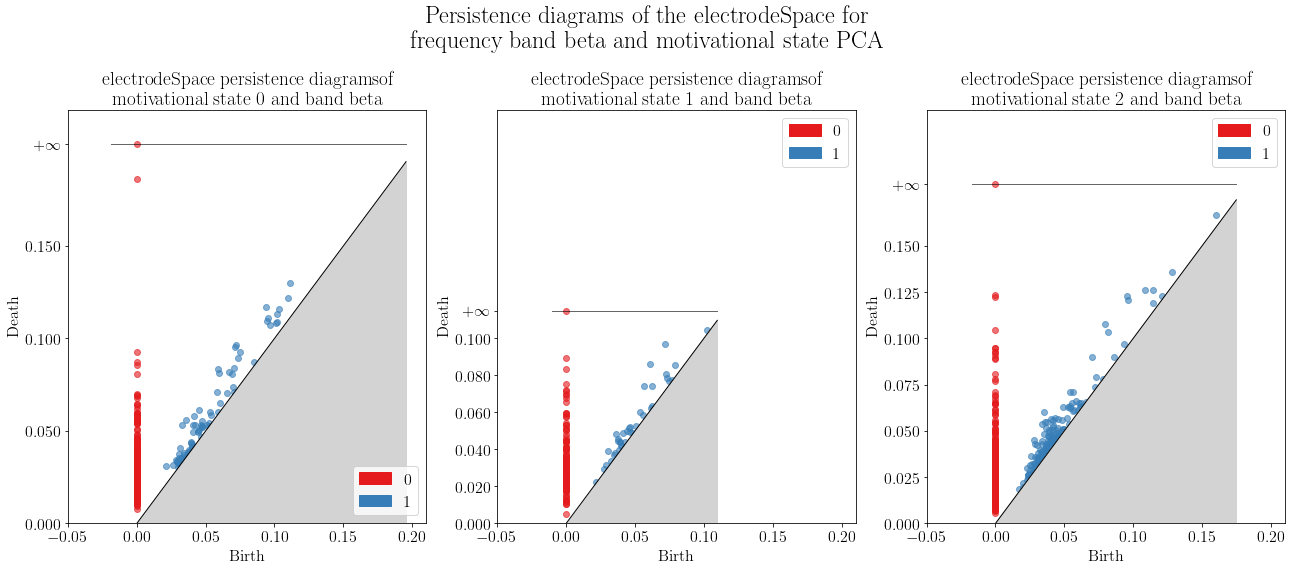

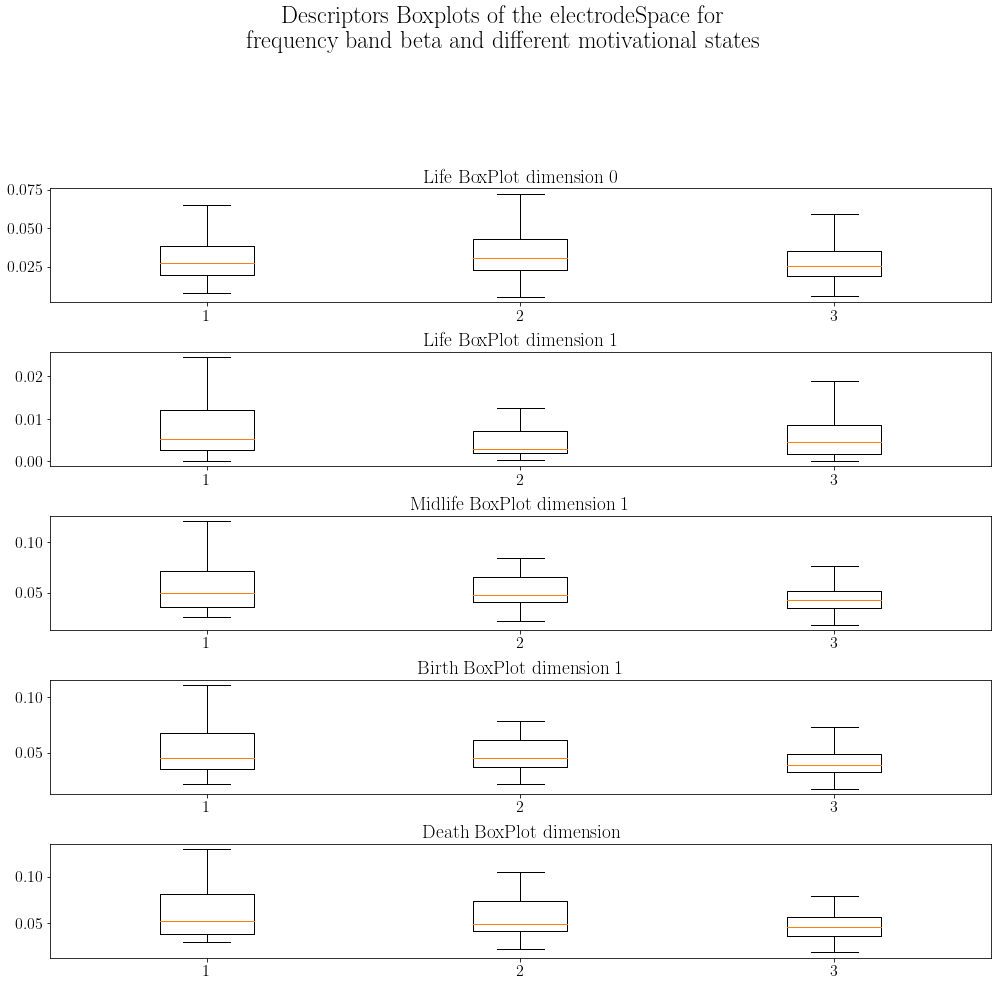

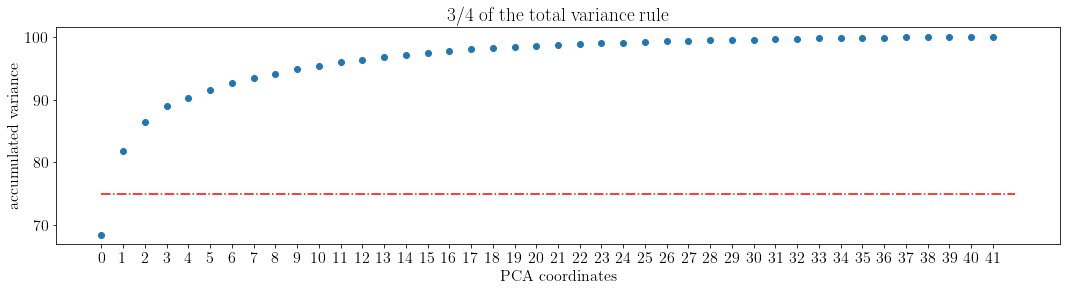

intensities for band  alpha and session 1
0.11975815296173095 minuts for classification


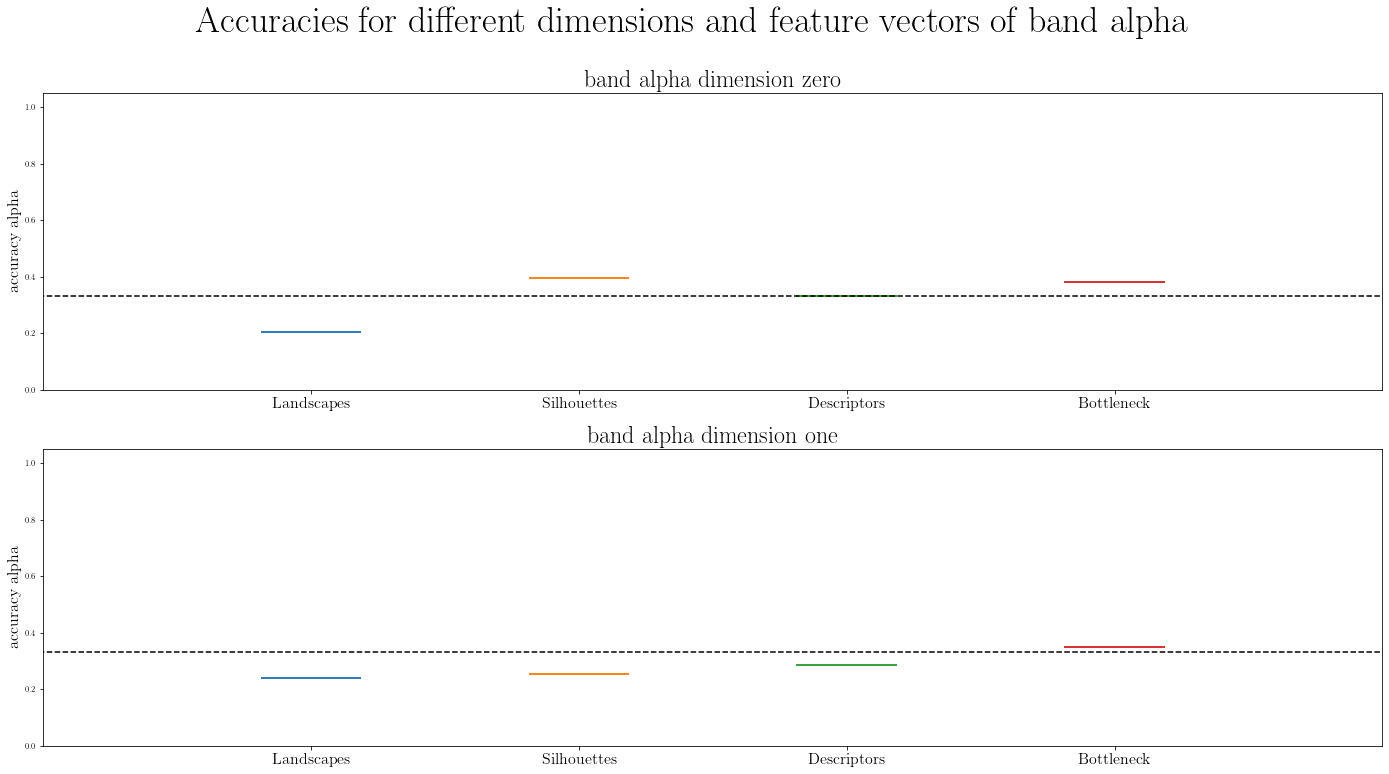

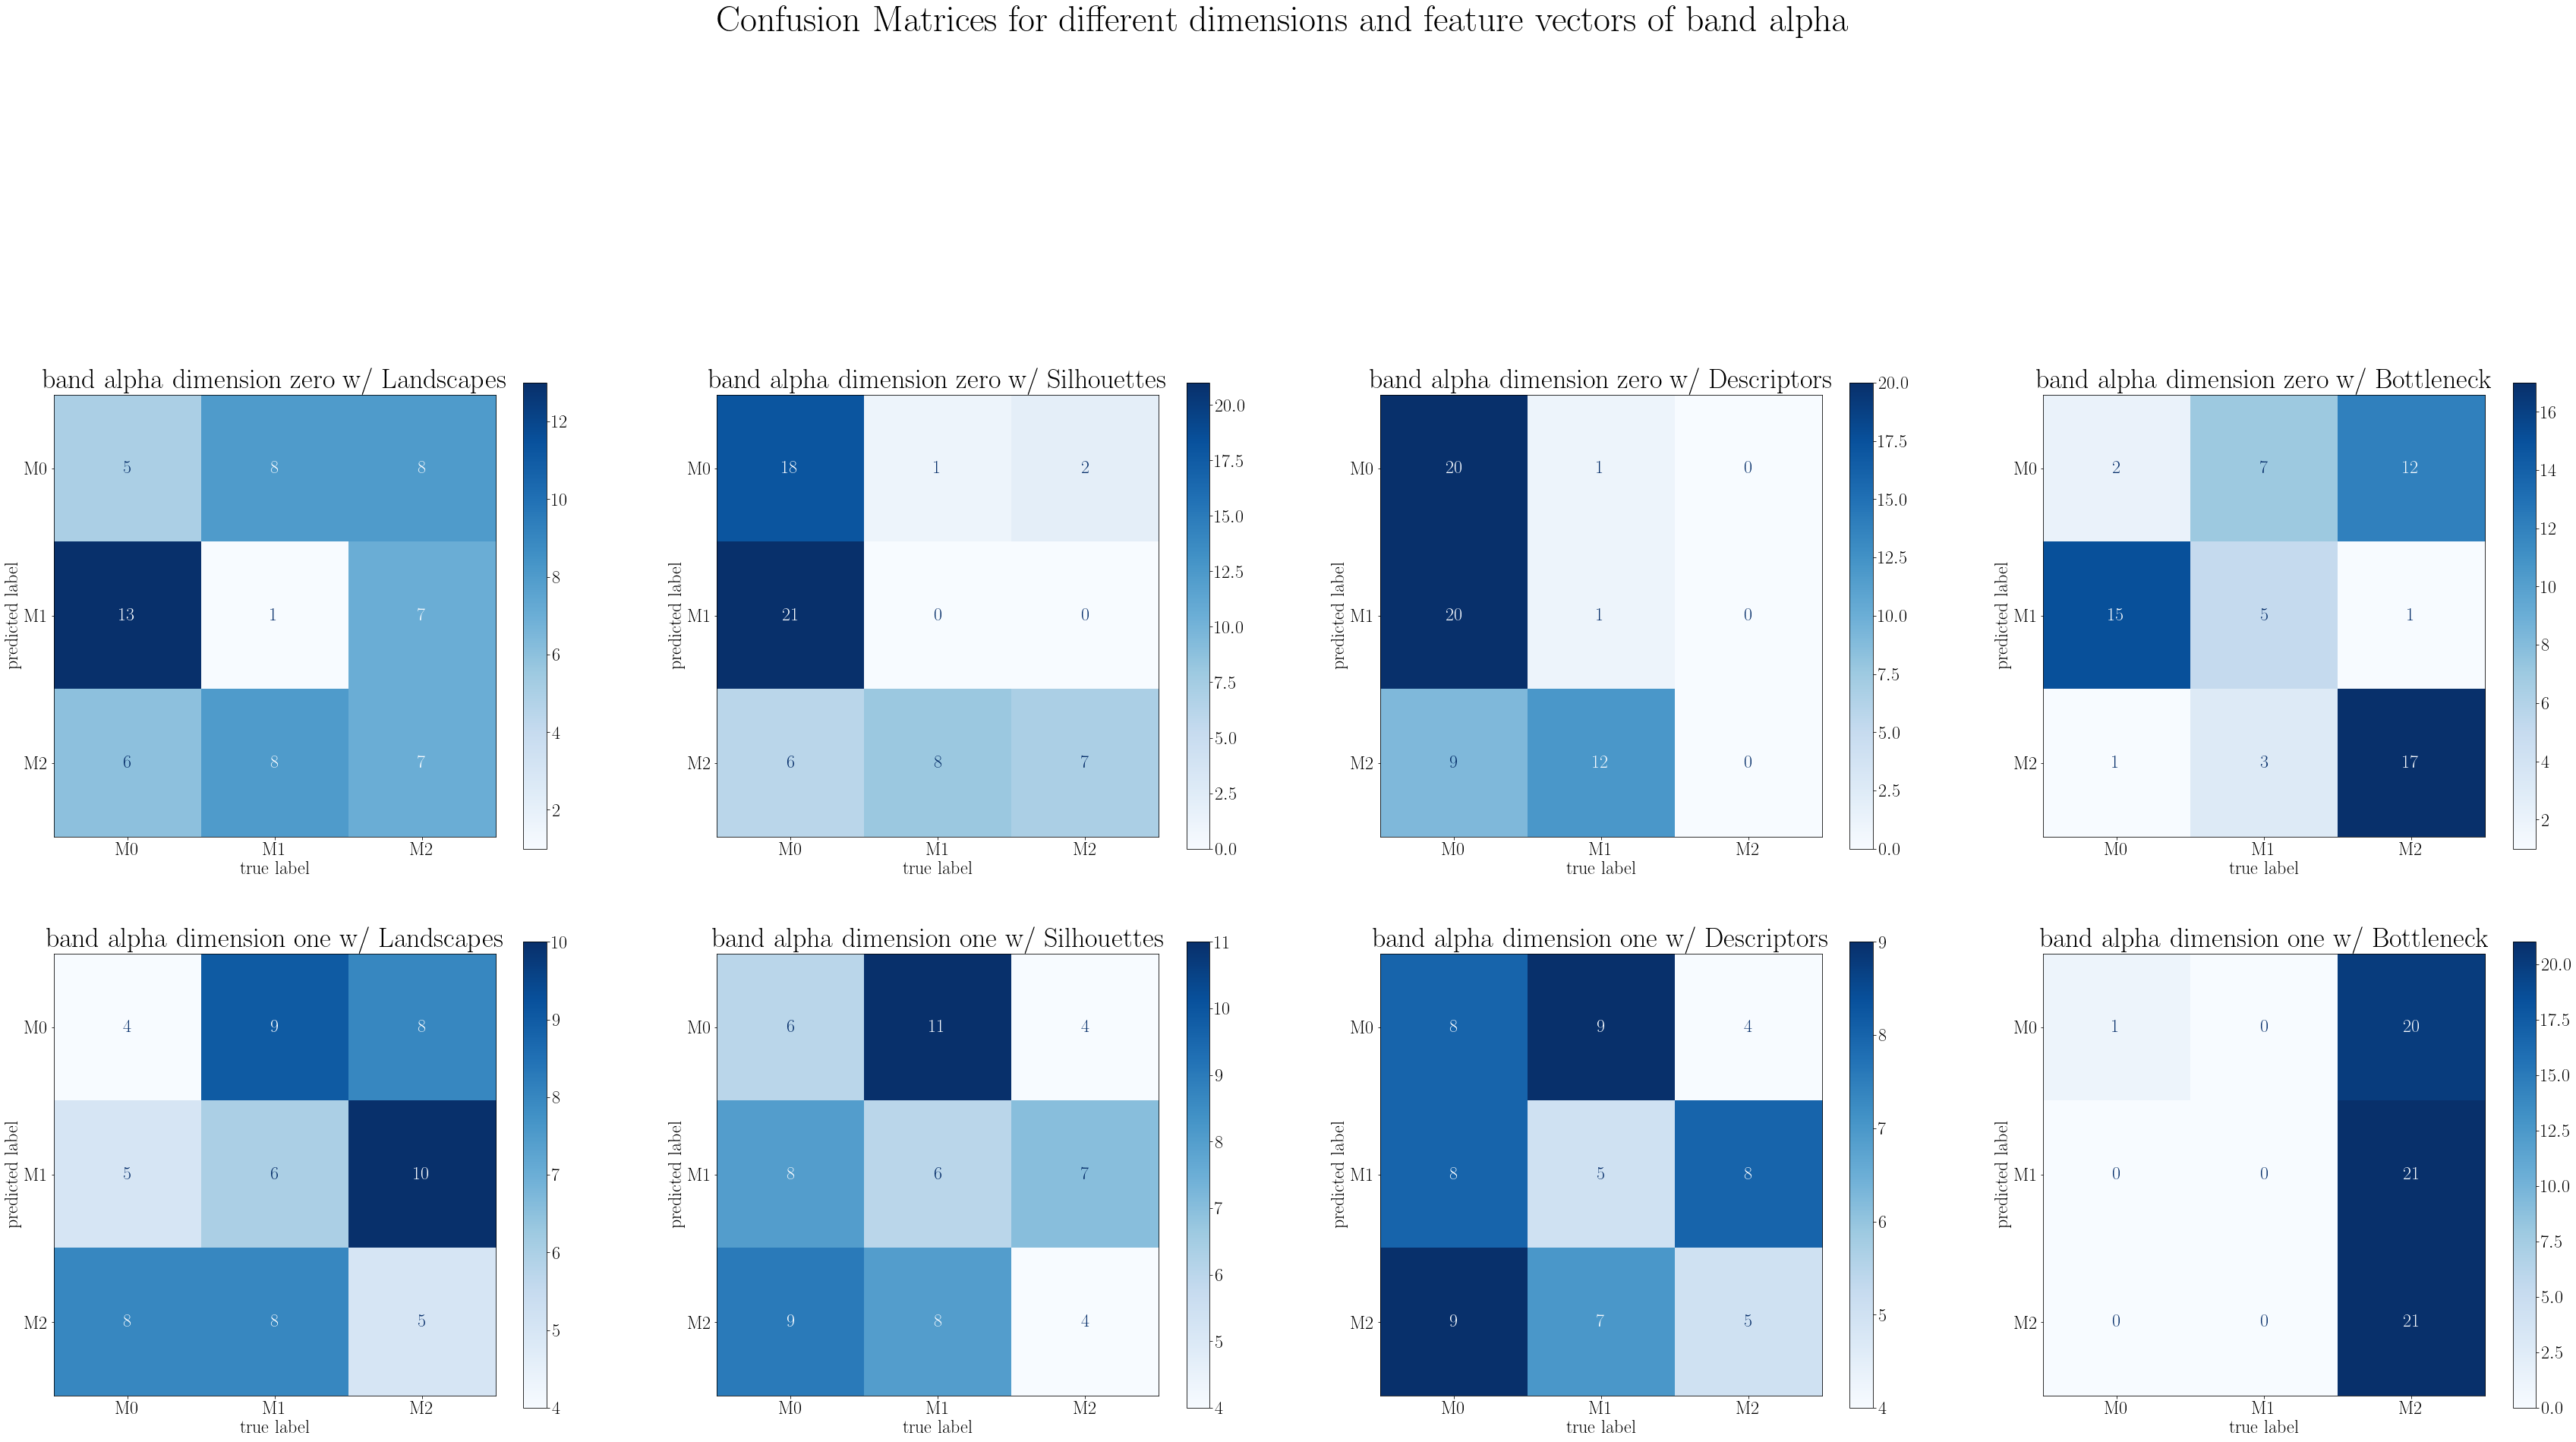

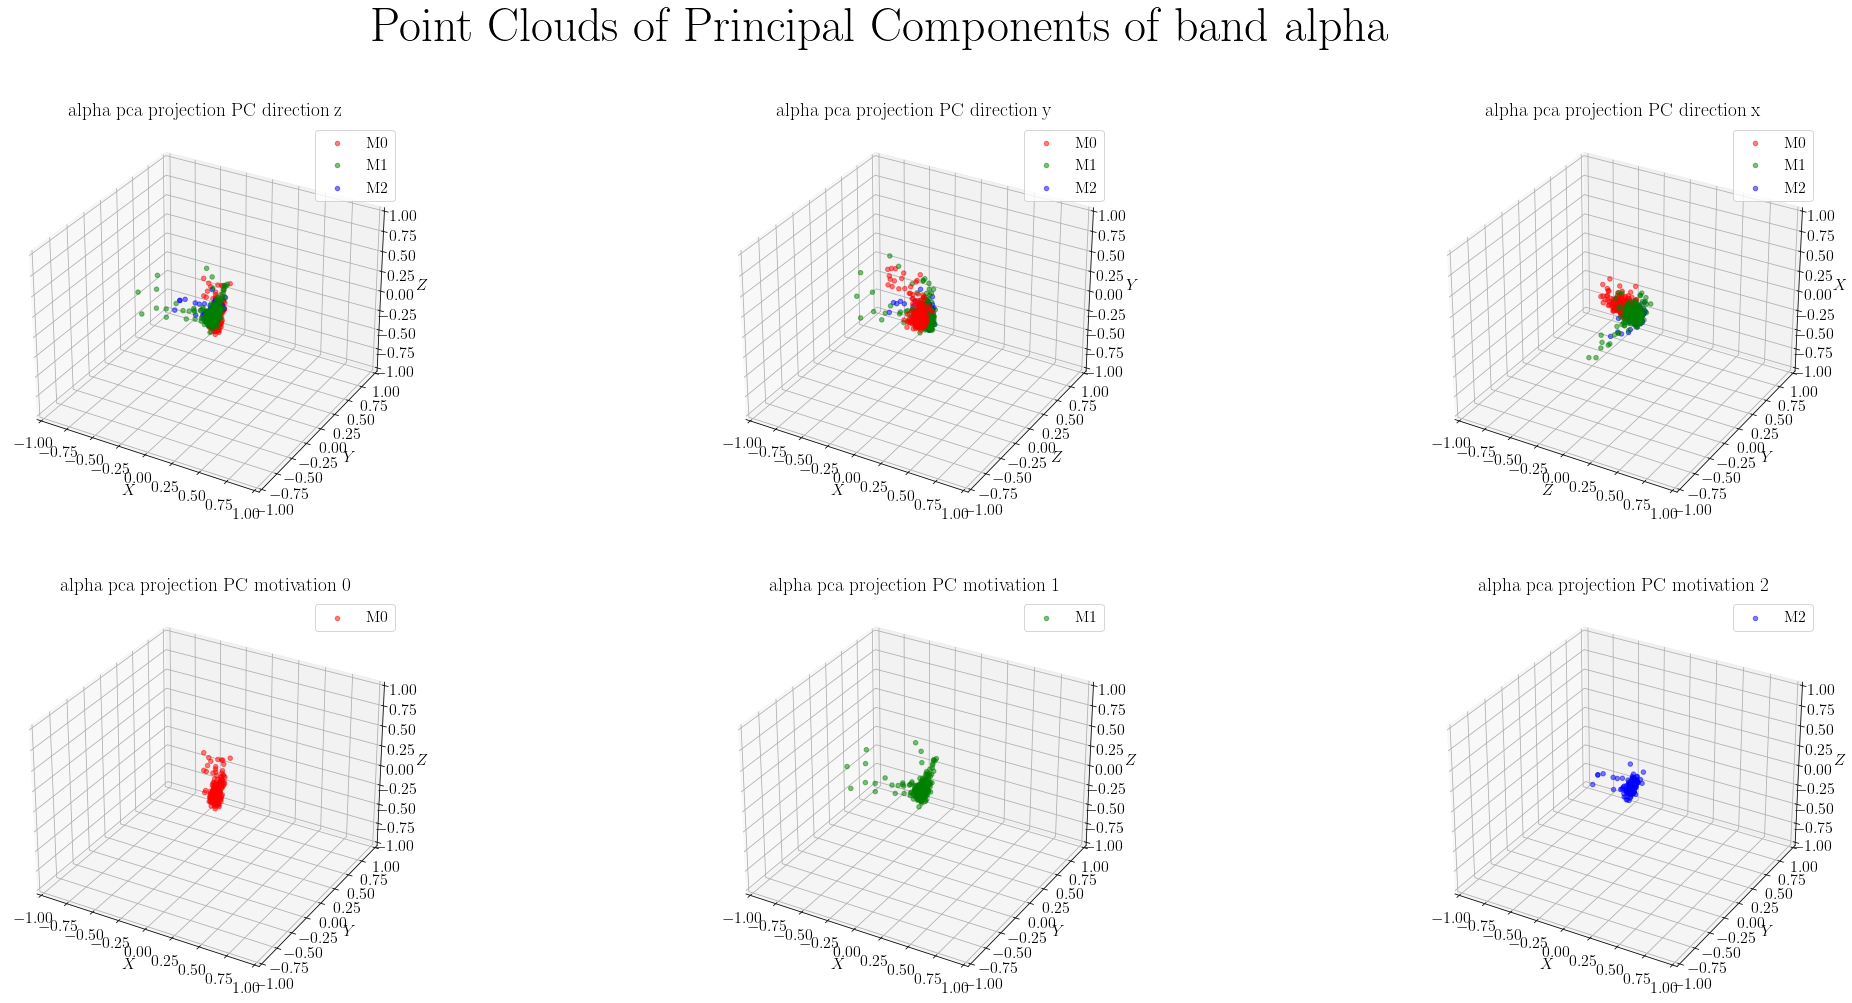

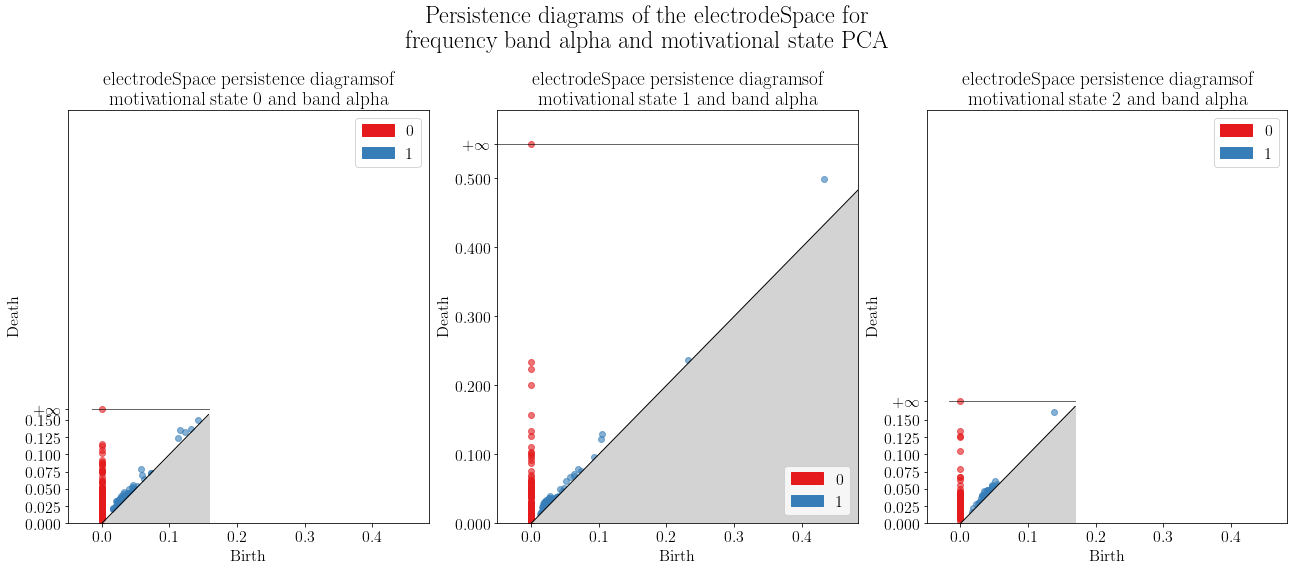

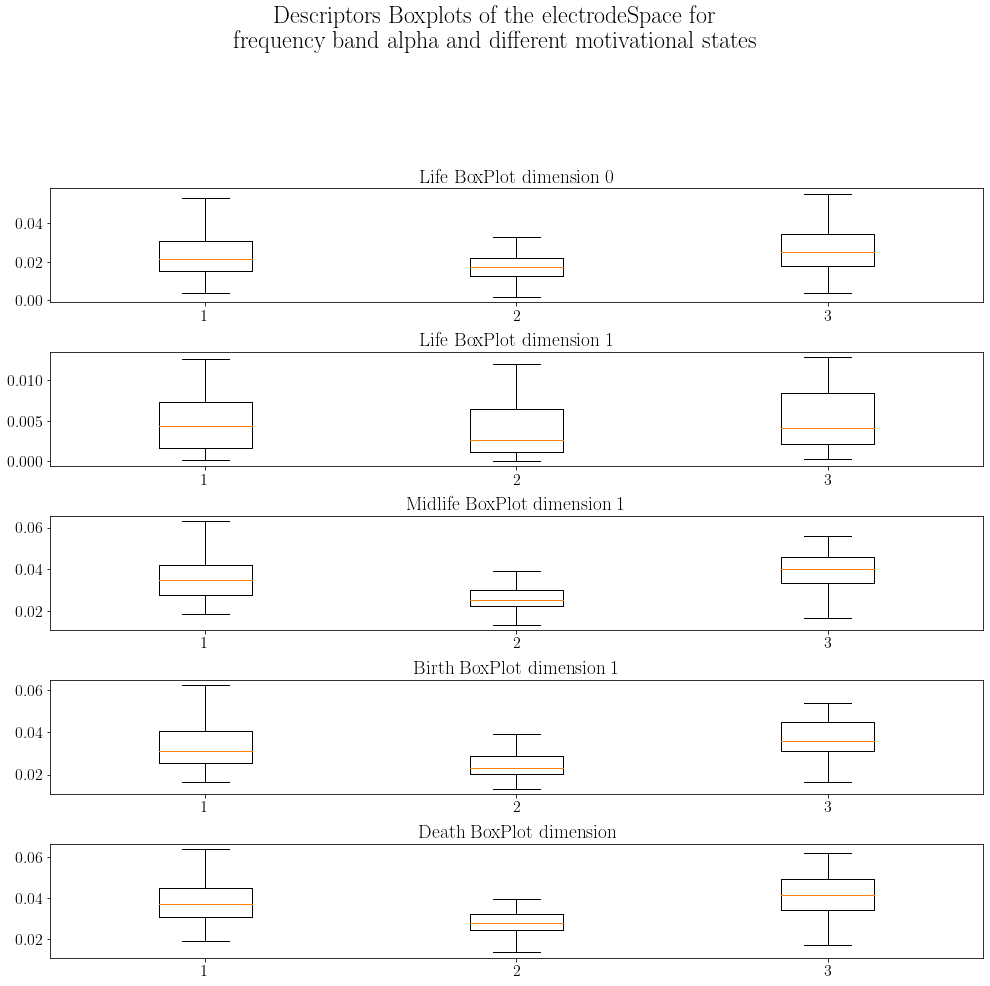

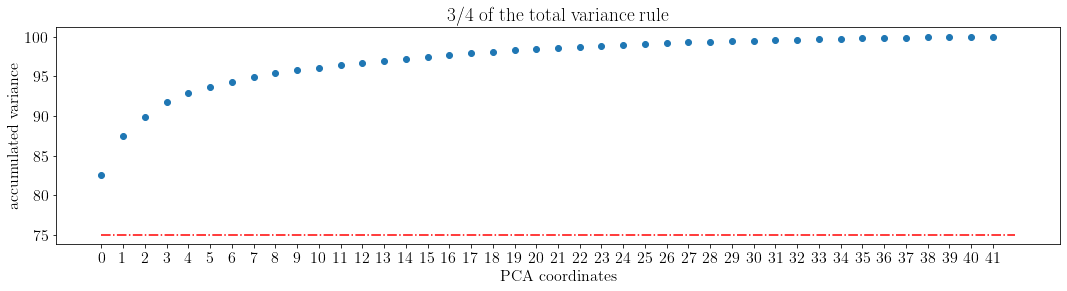

intensities for band  alpha and session 2
0.15720914204915365 minuts for classification


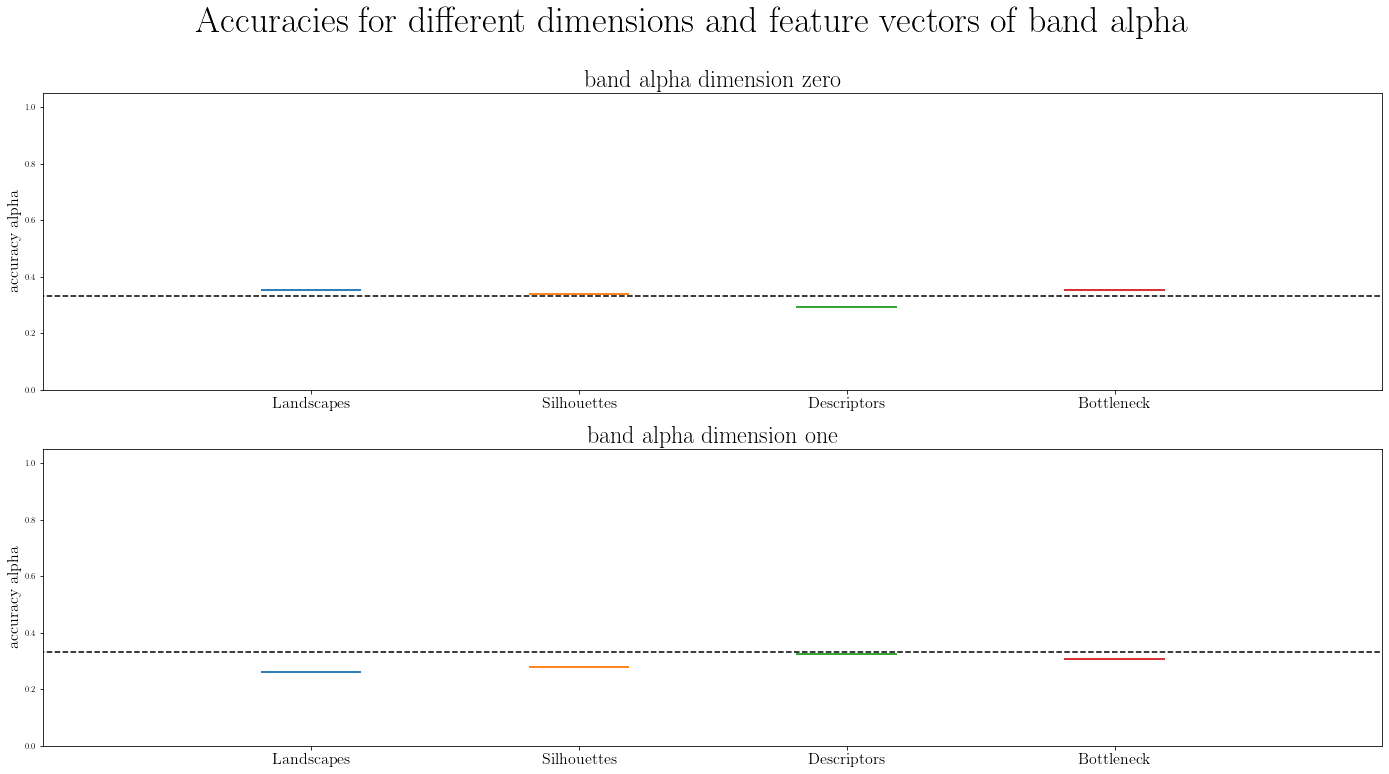

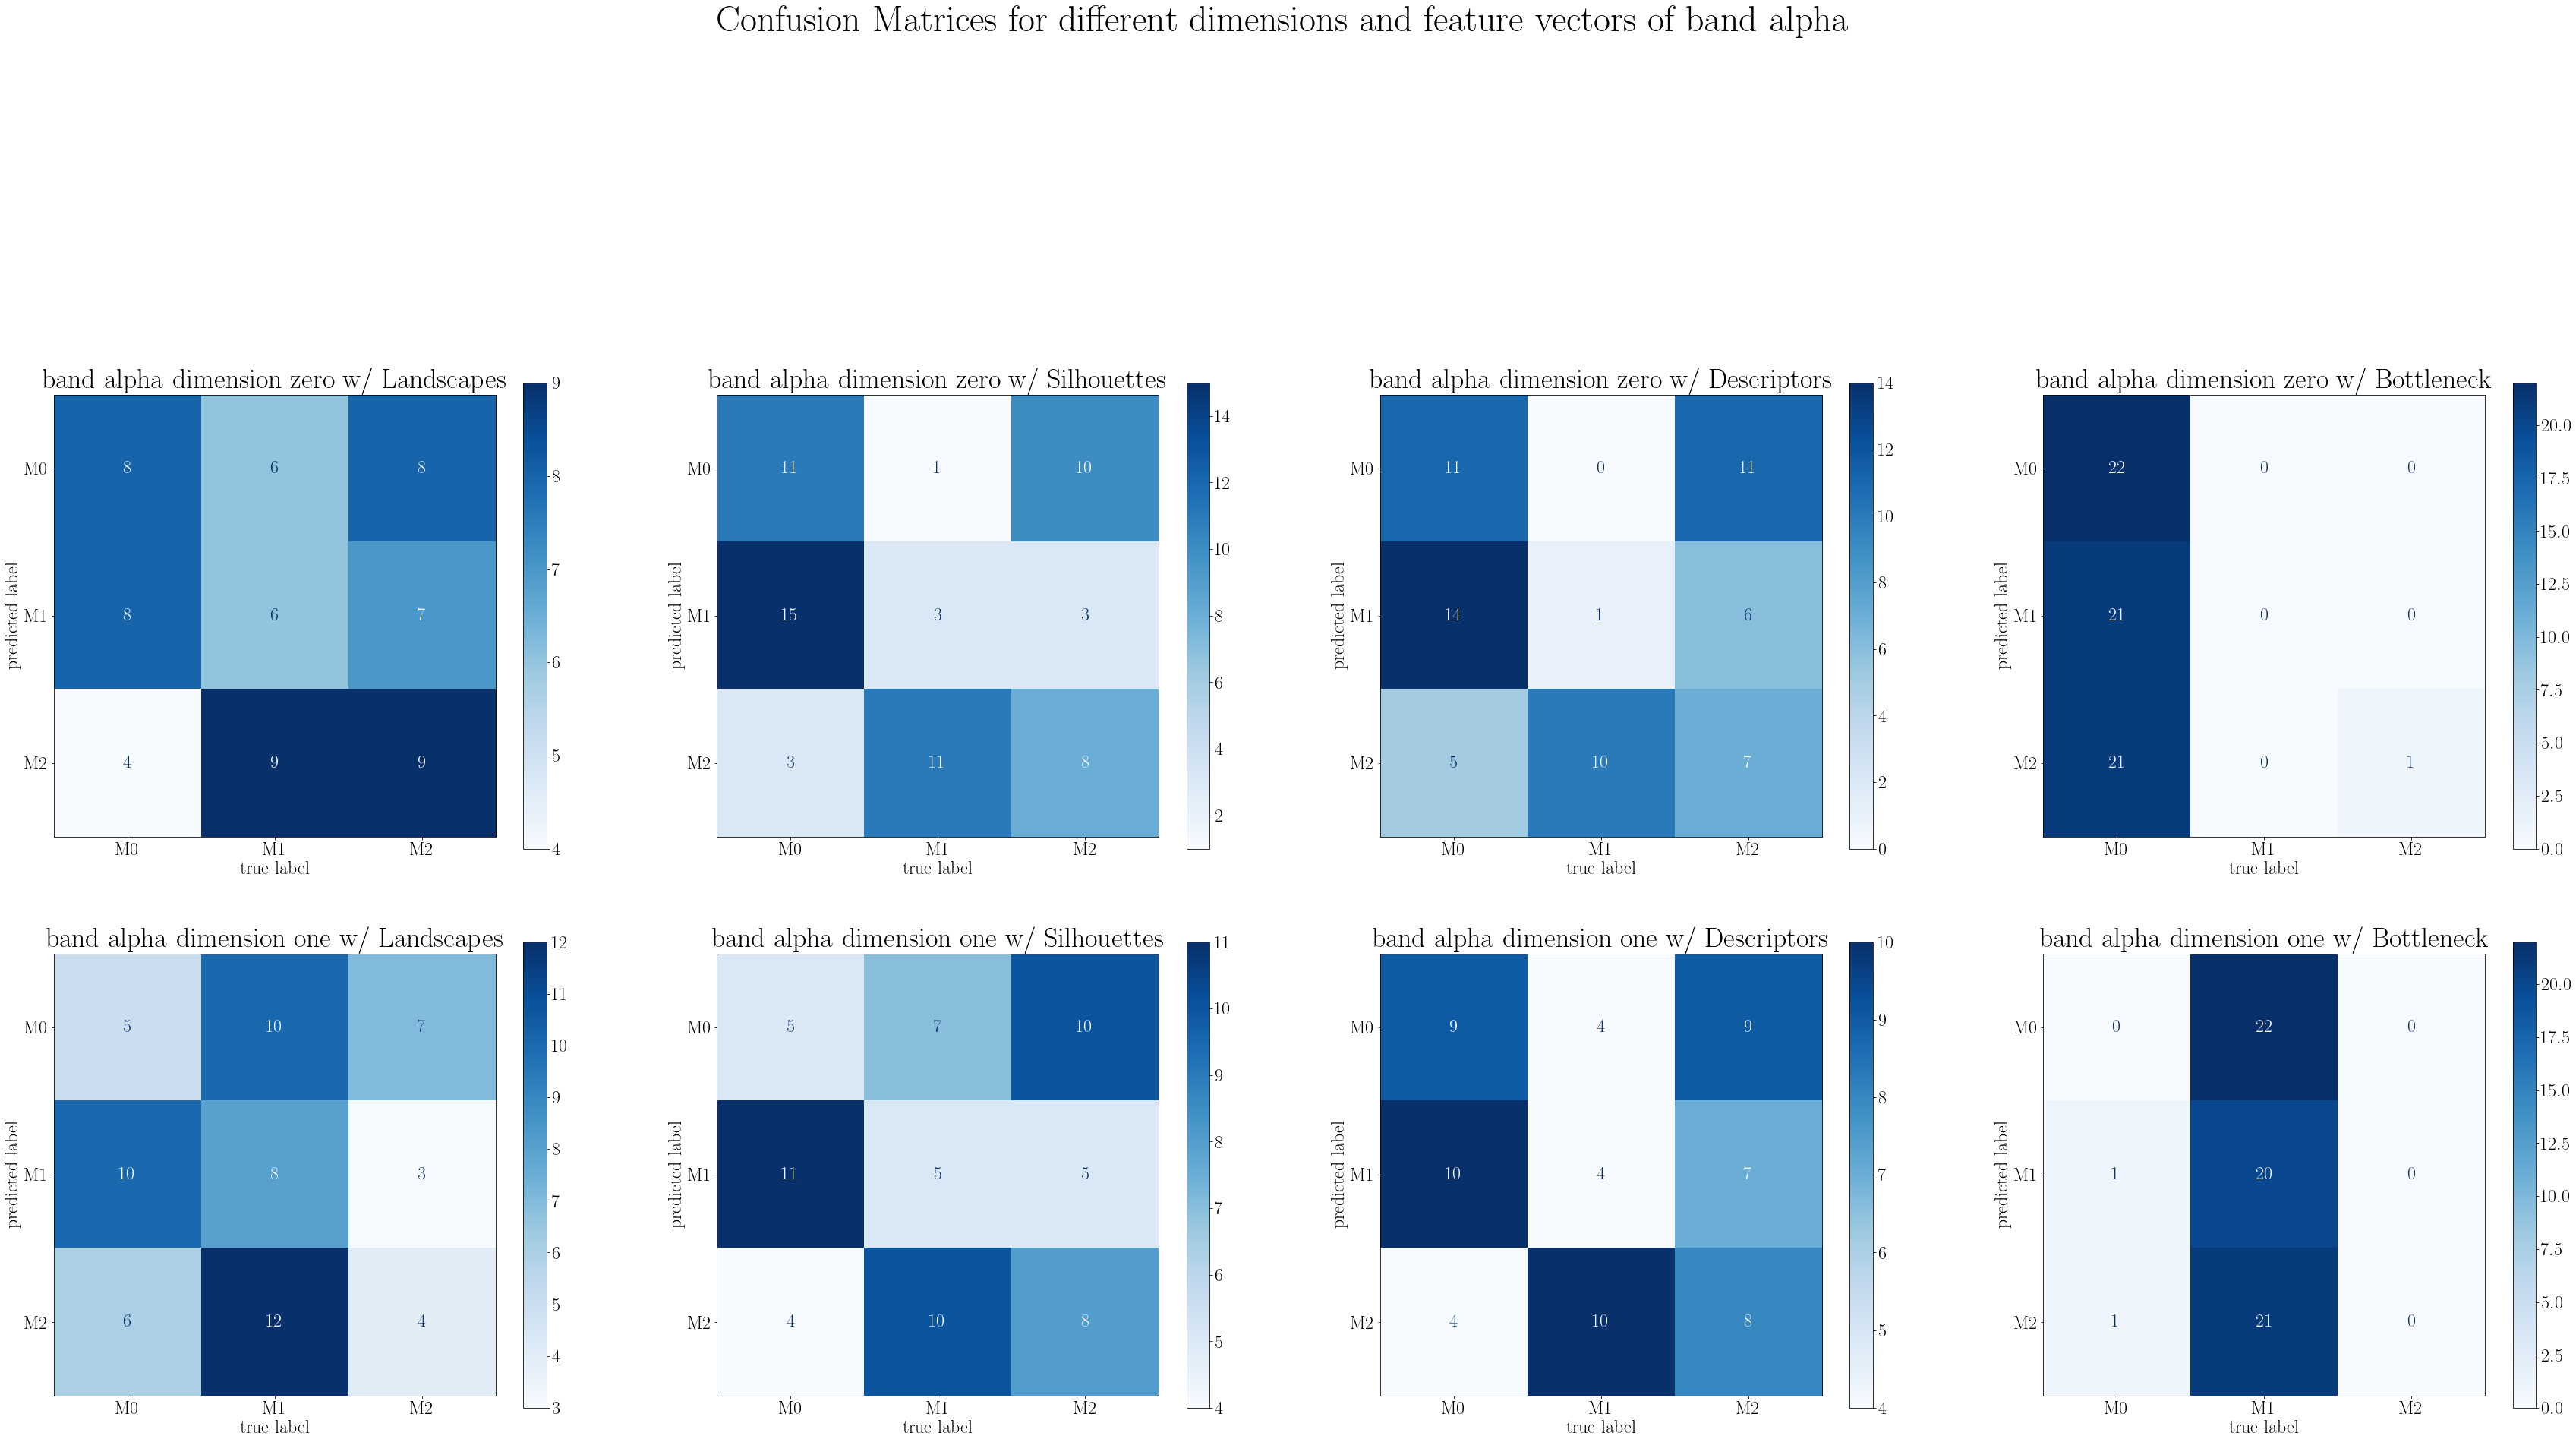

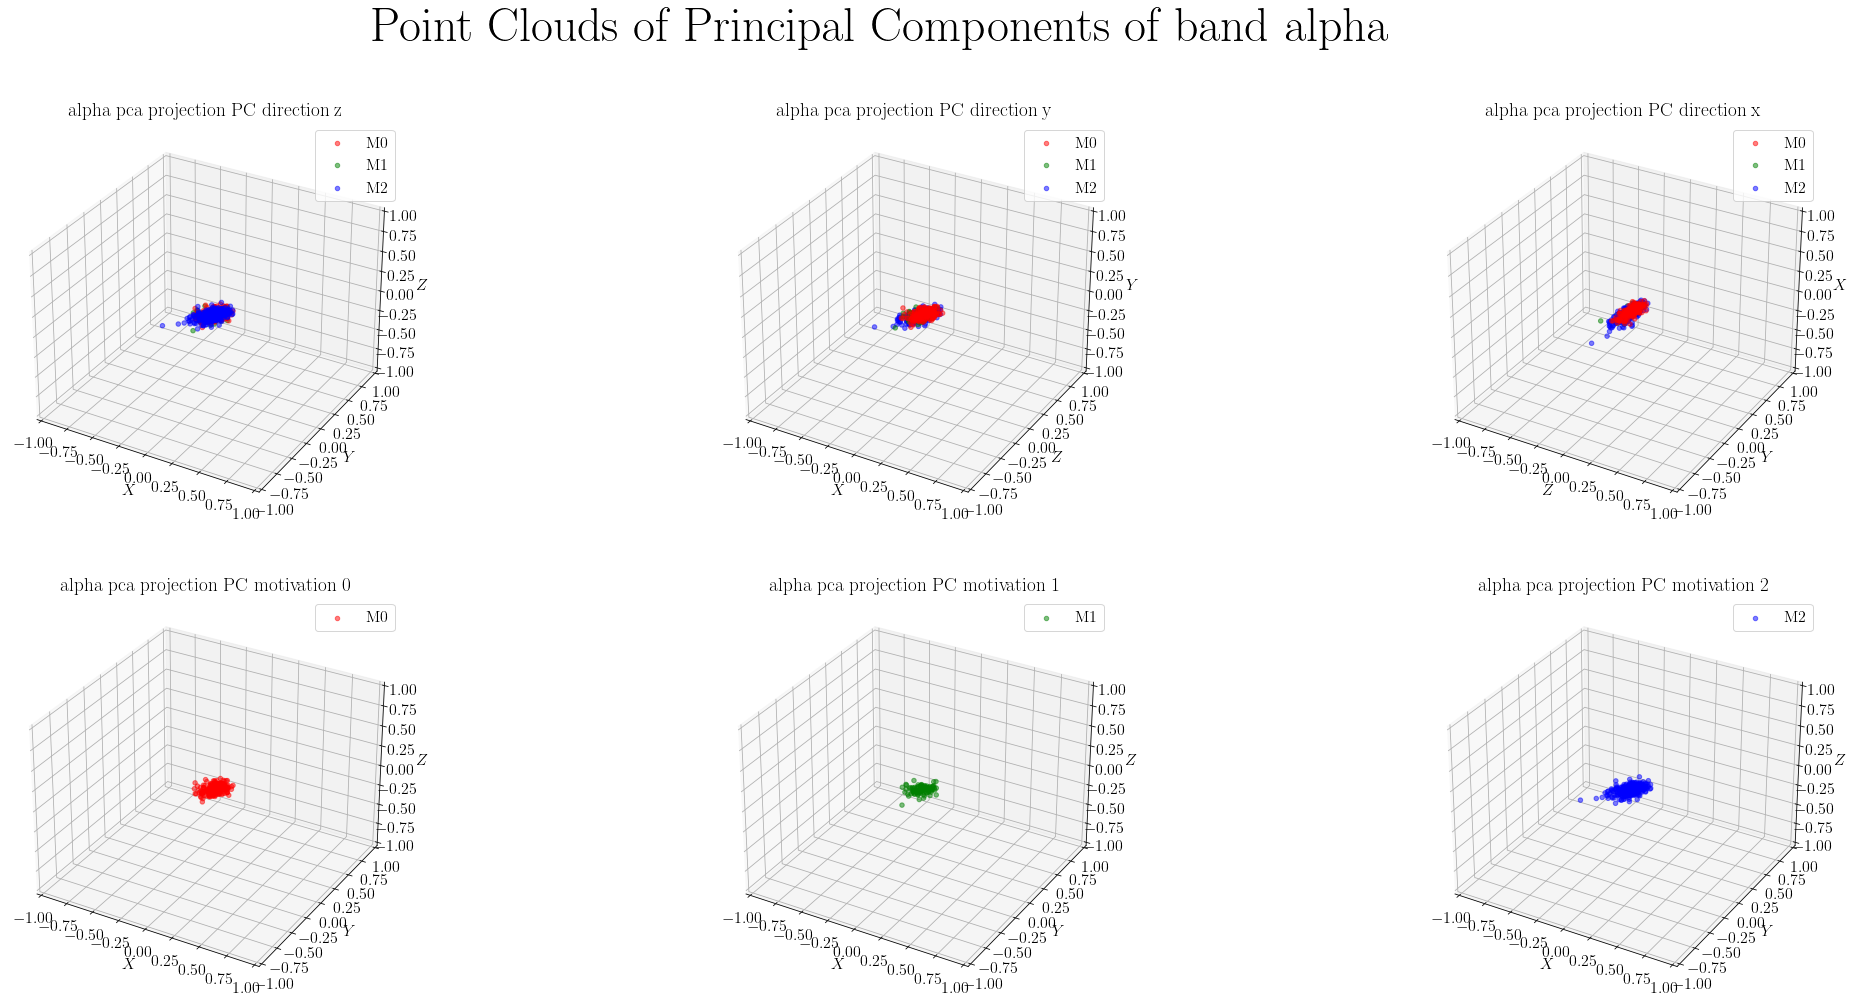

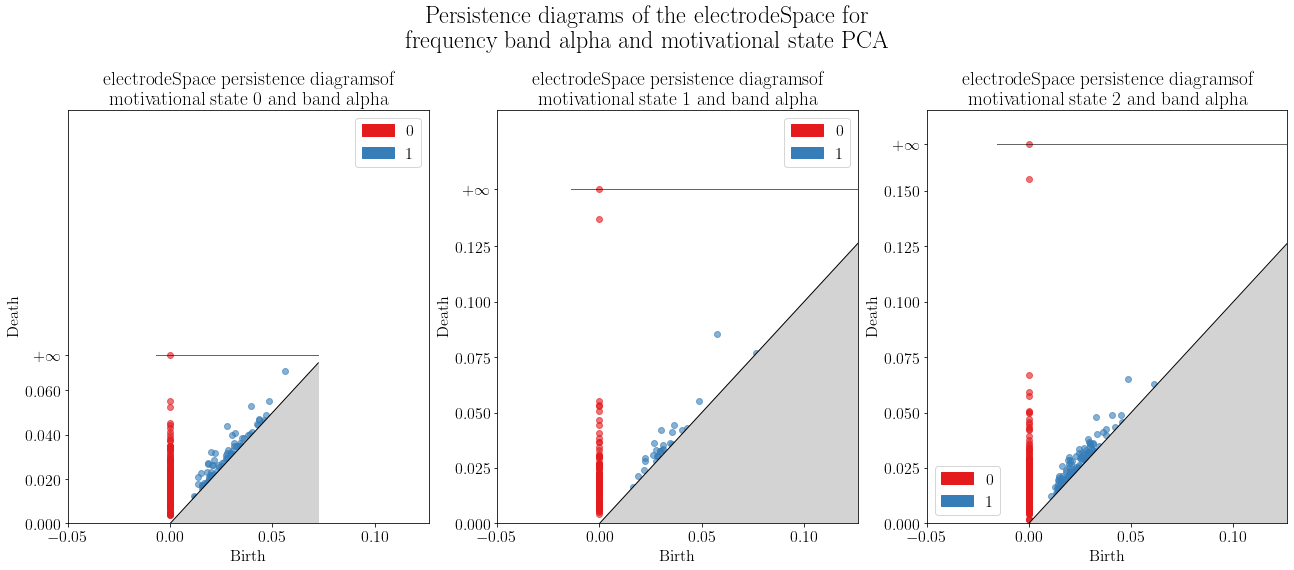

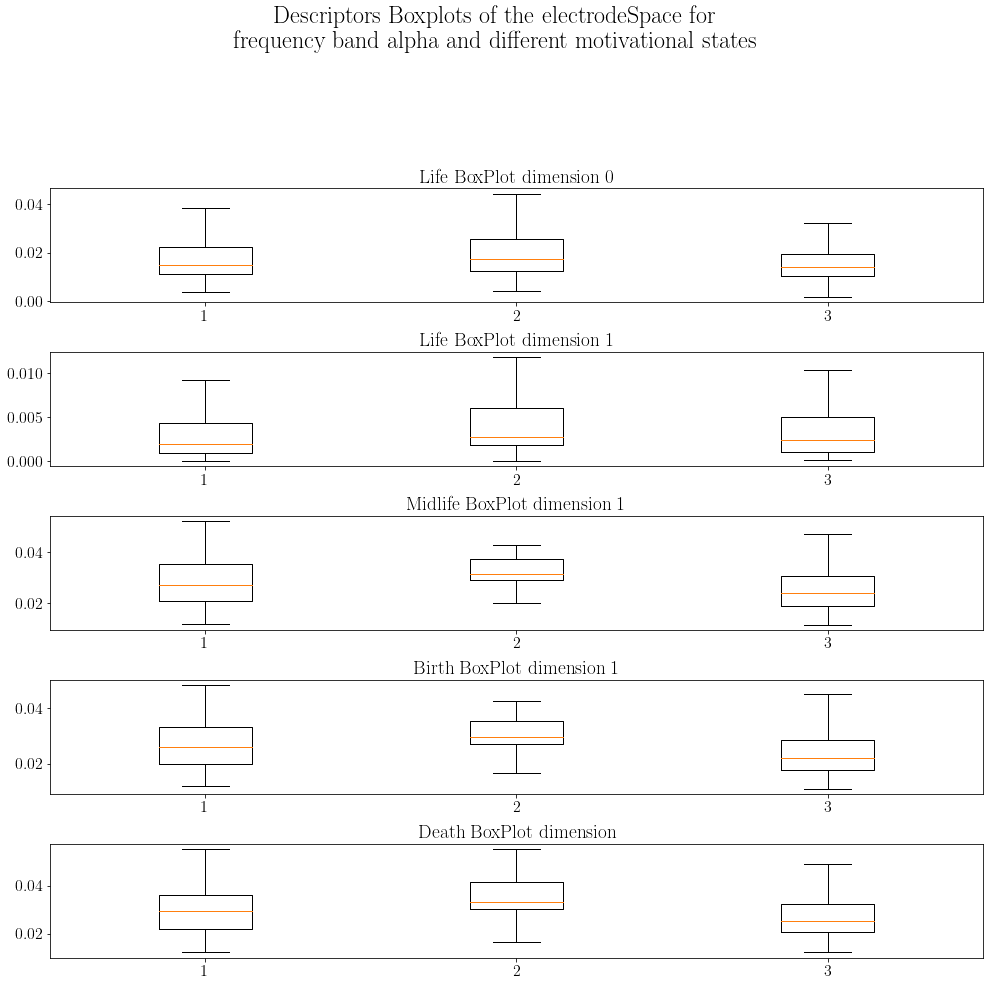

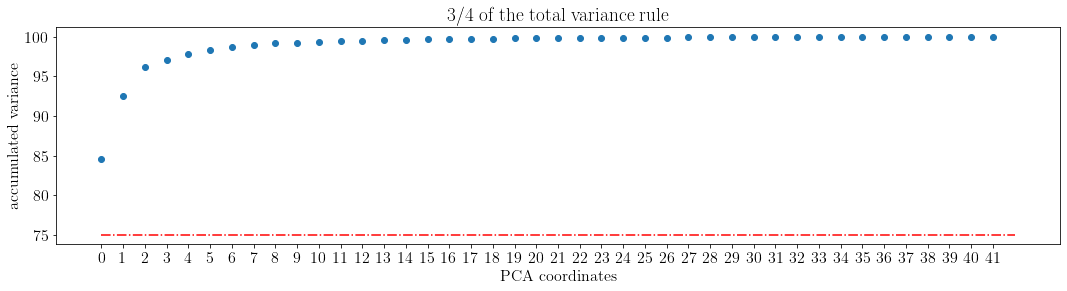

intensities for band  noFilter and session 1
0.1284702181816101 minuts for classification


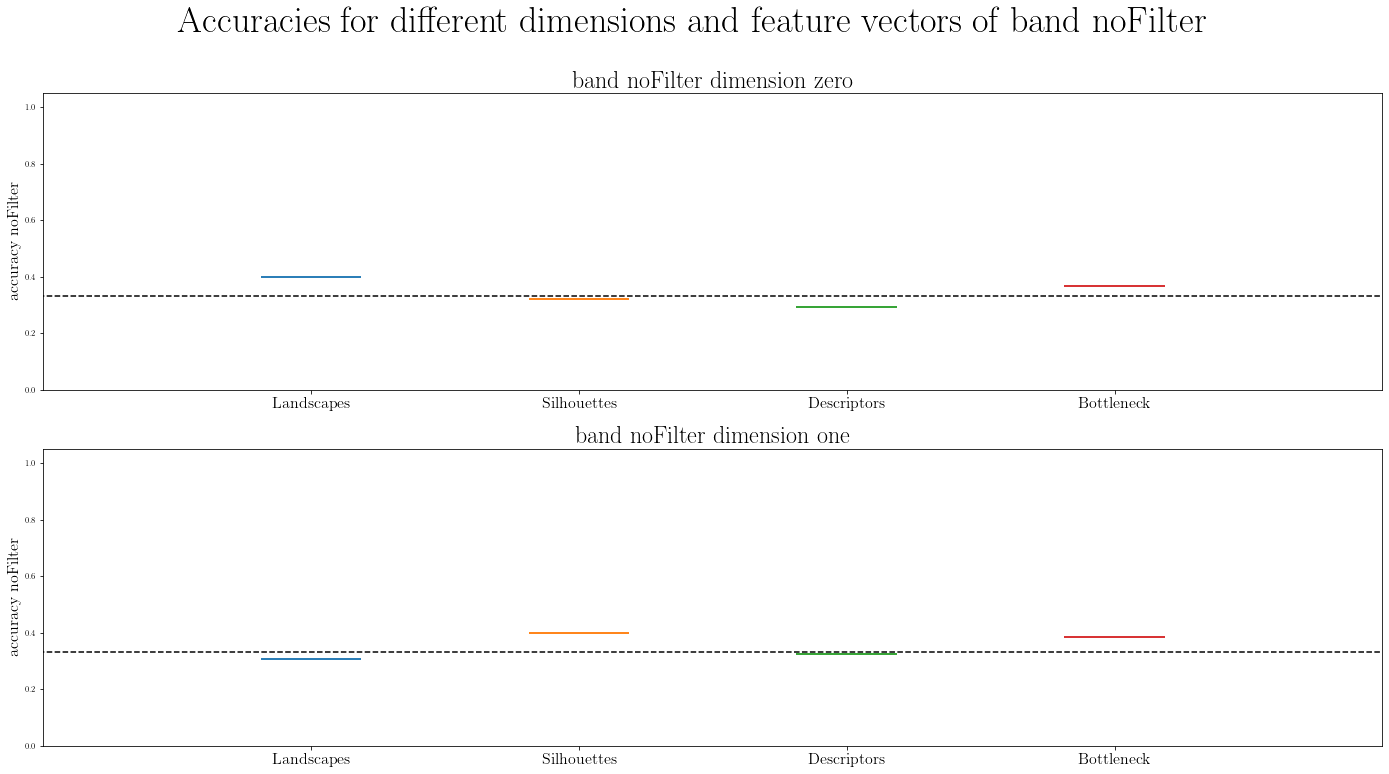

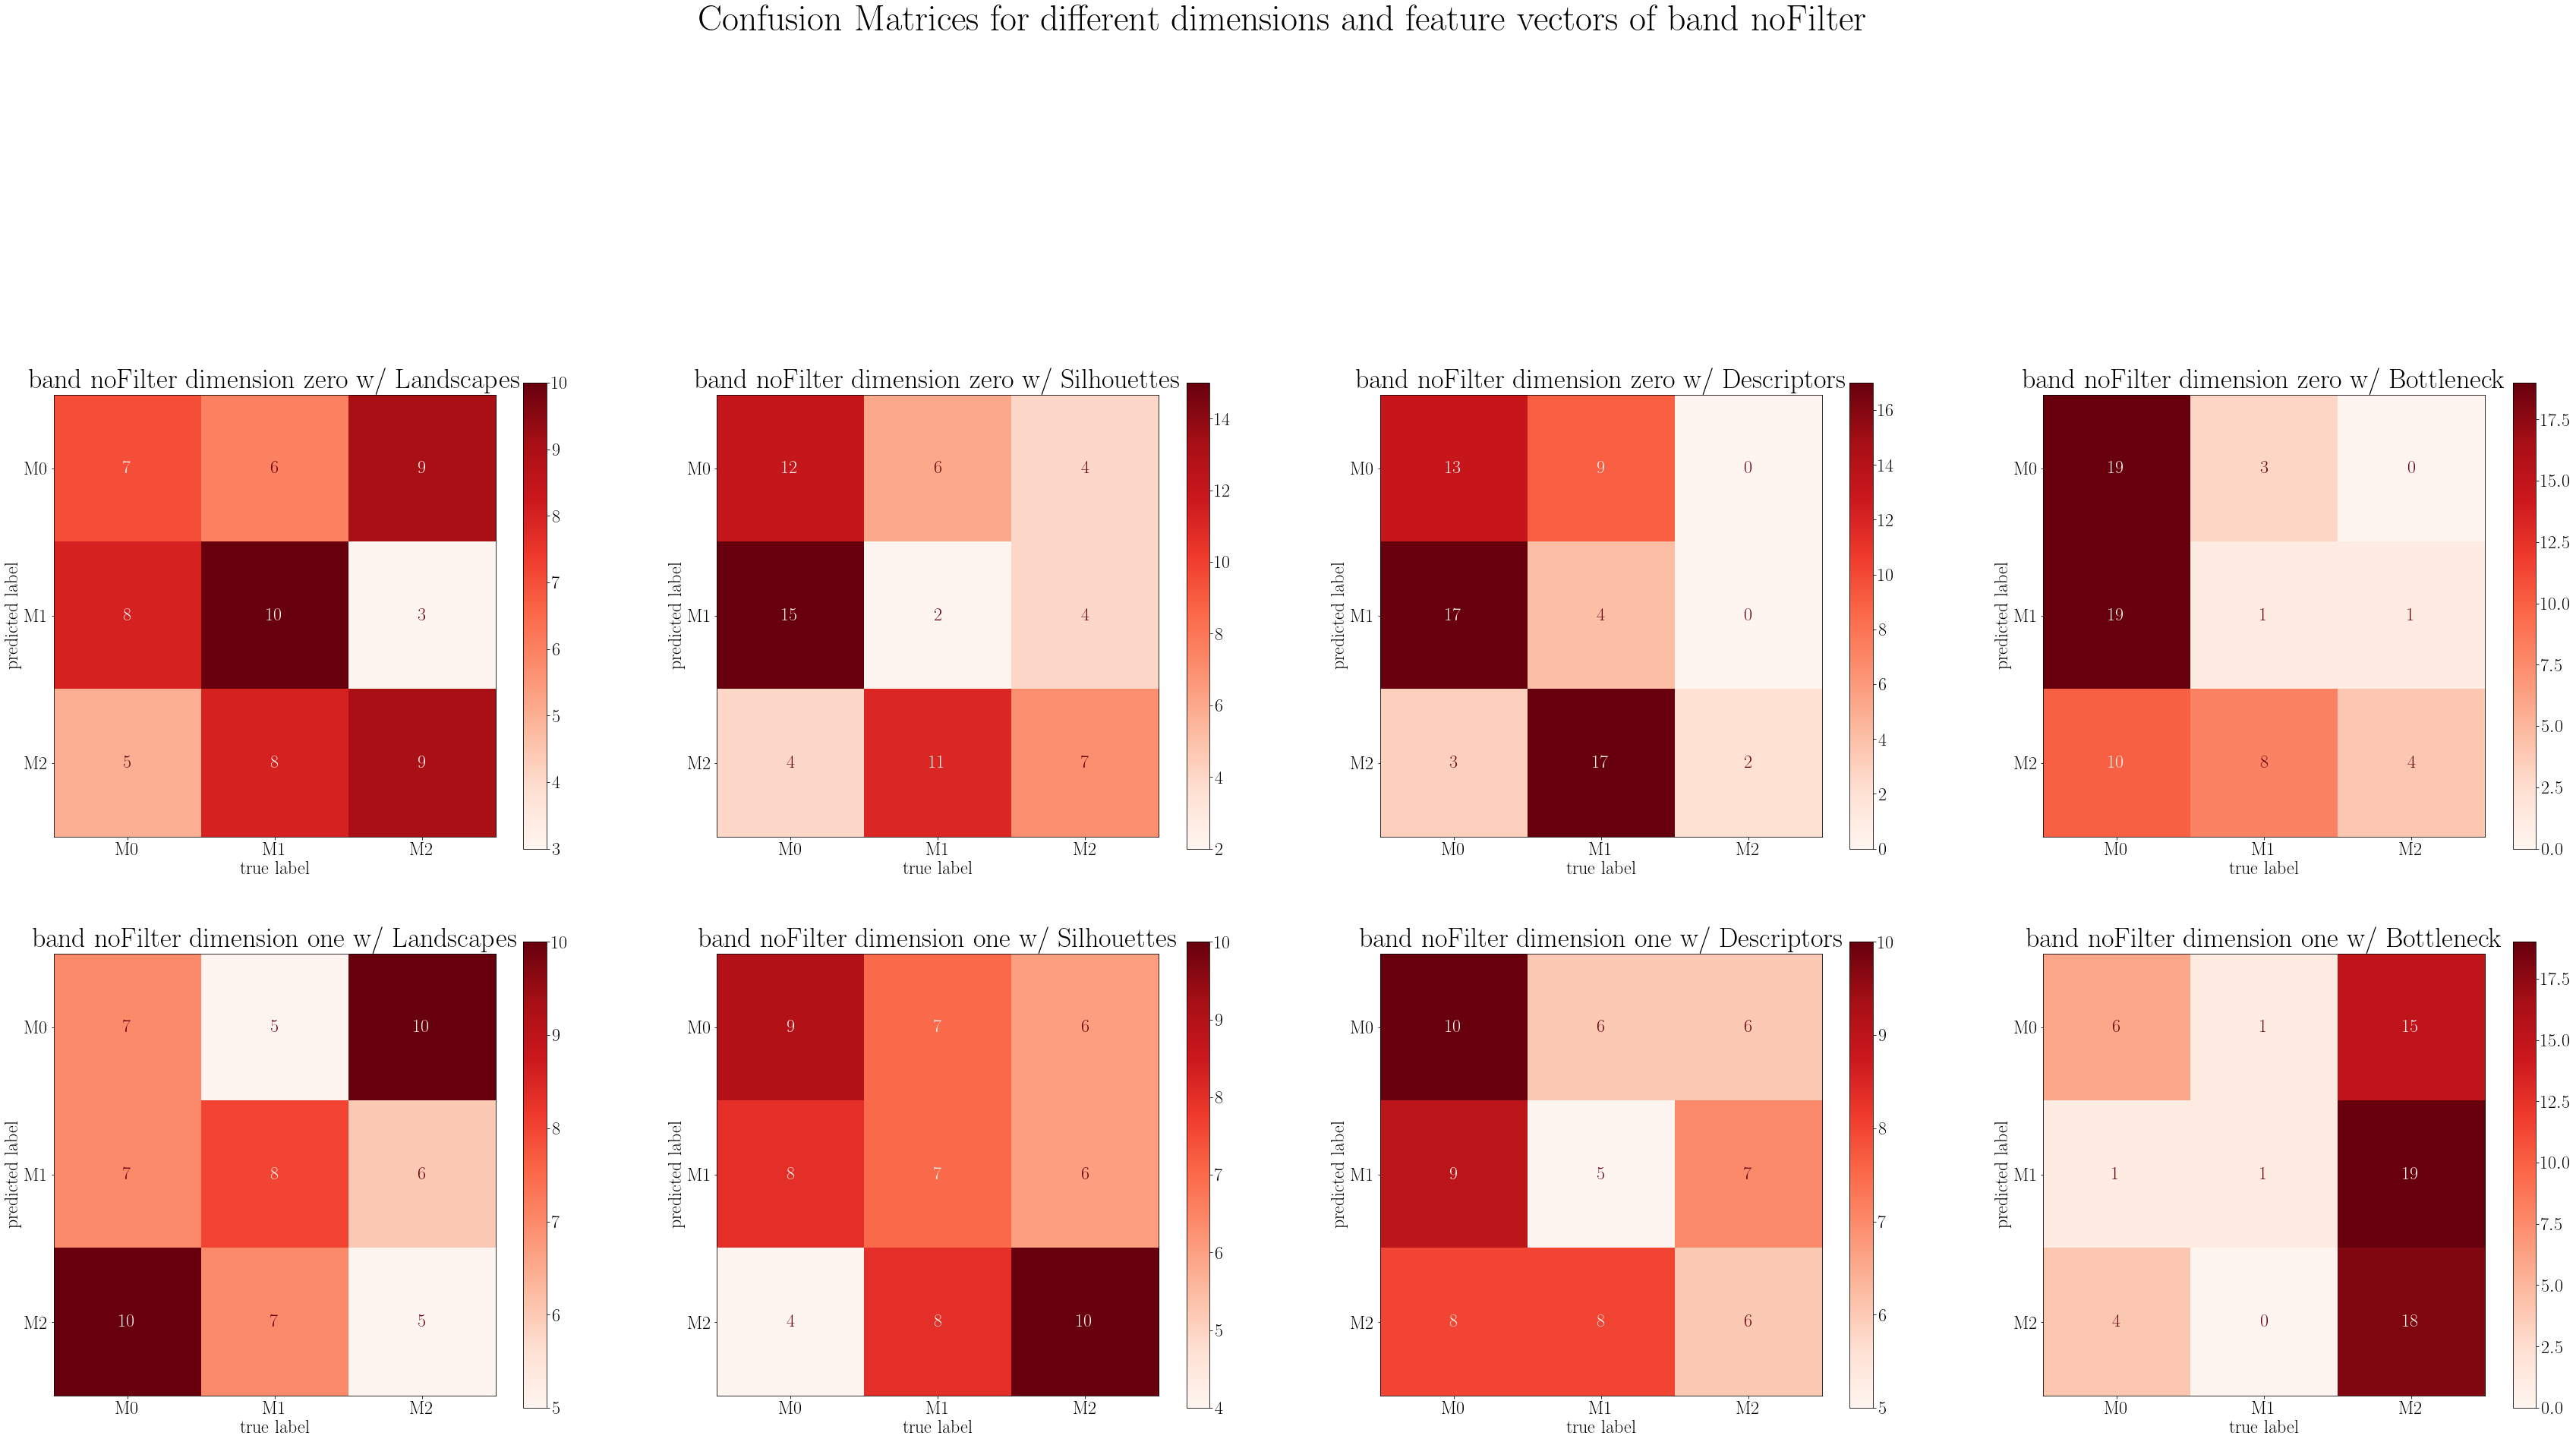

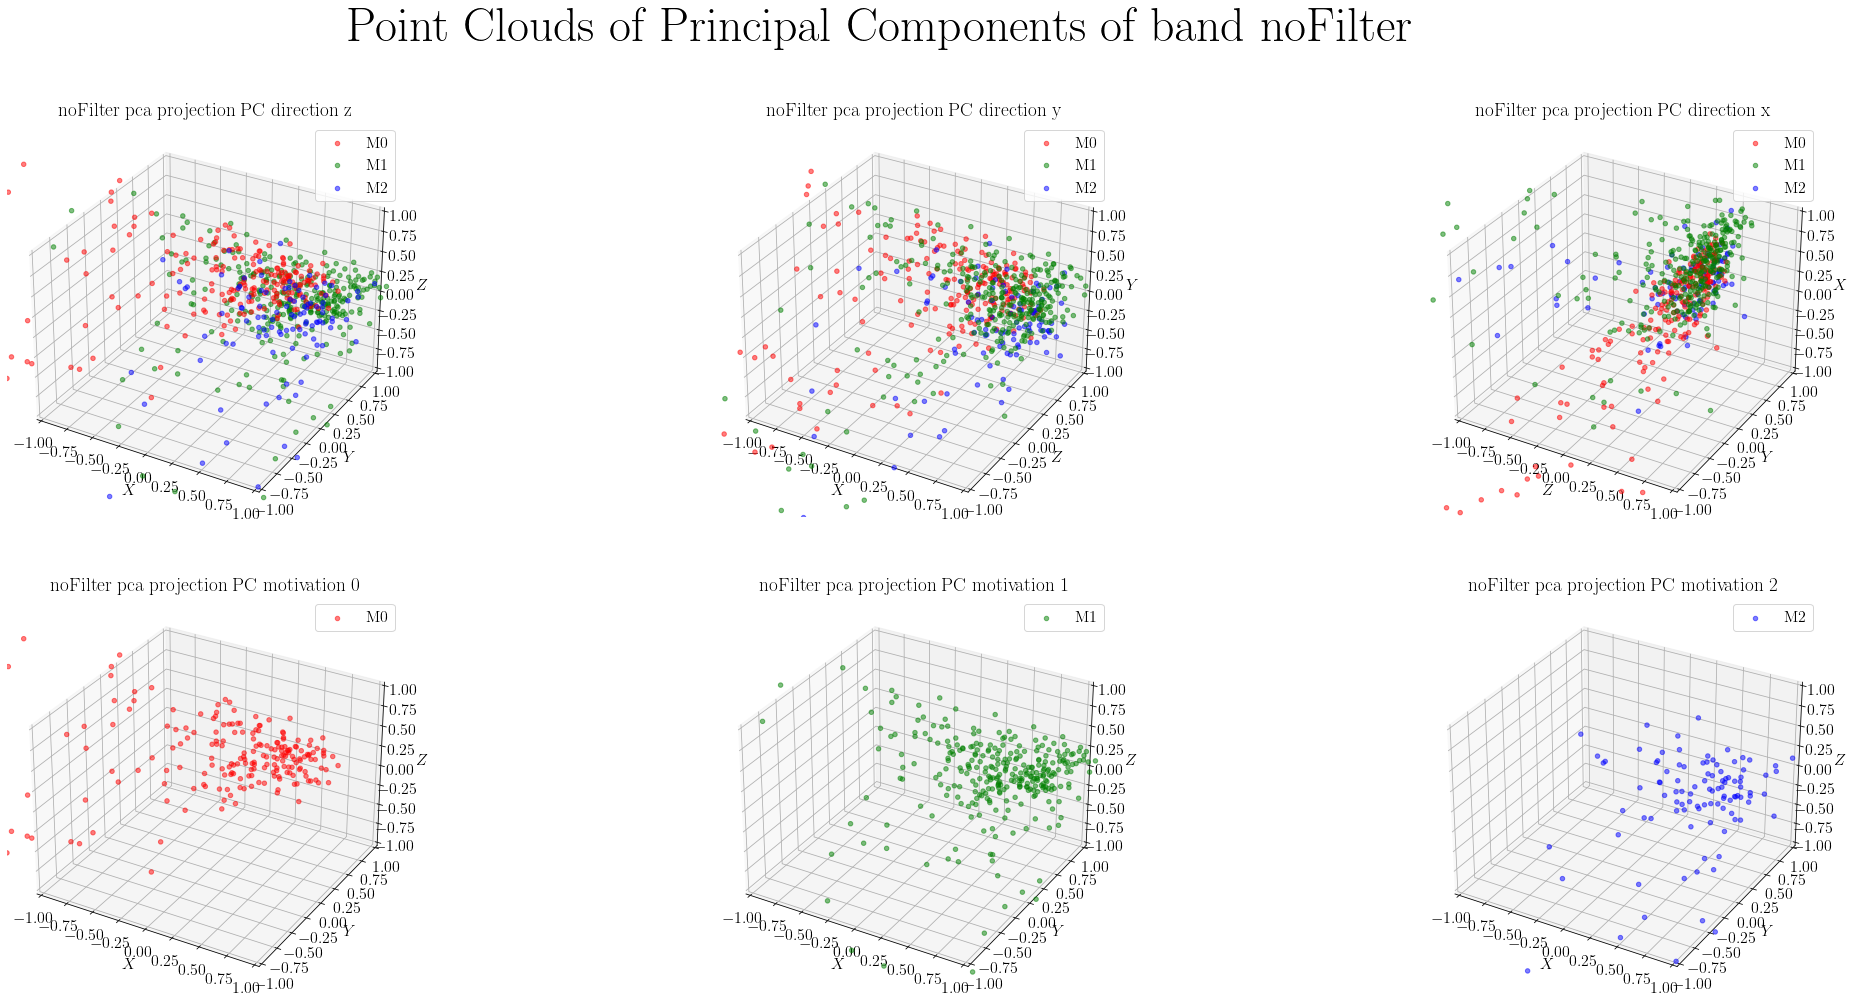

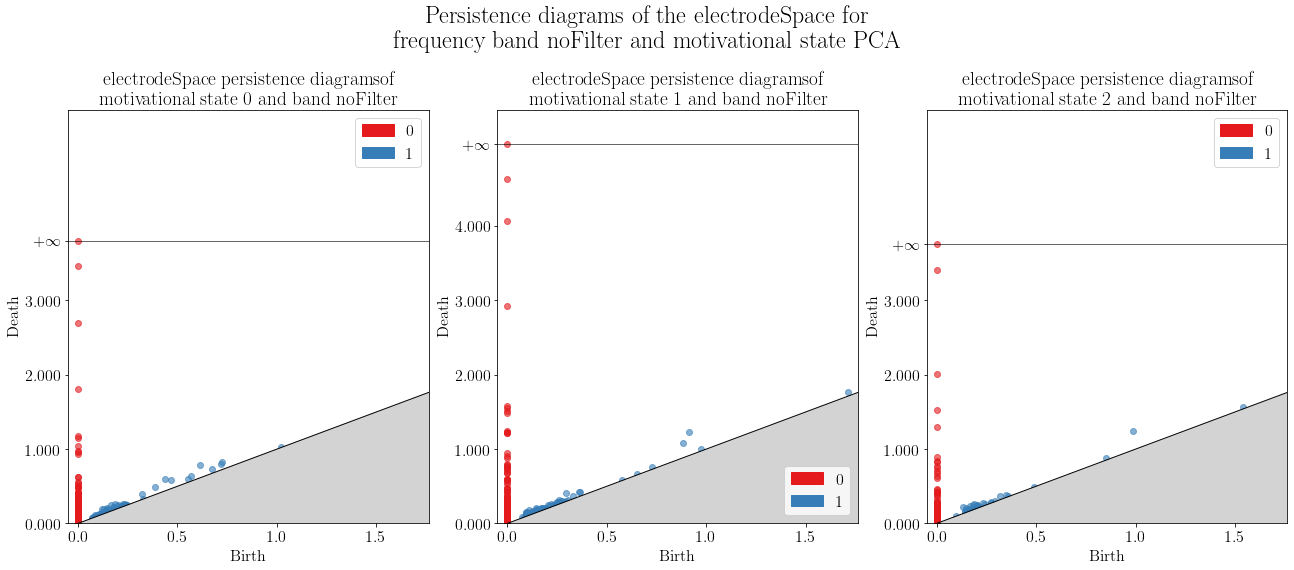

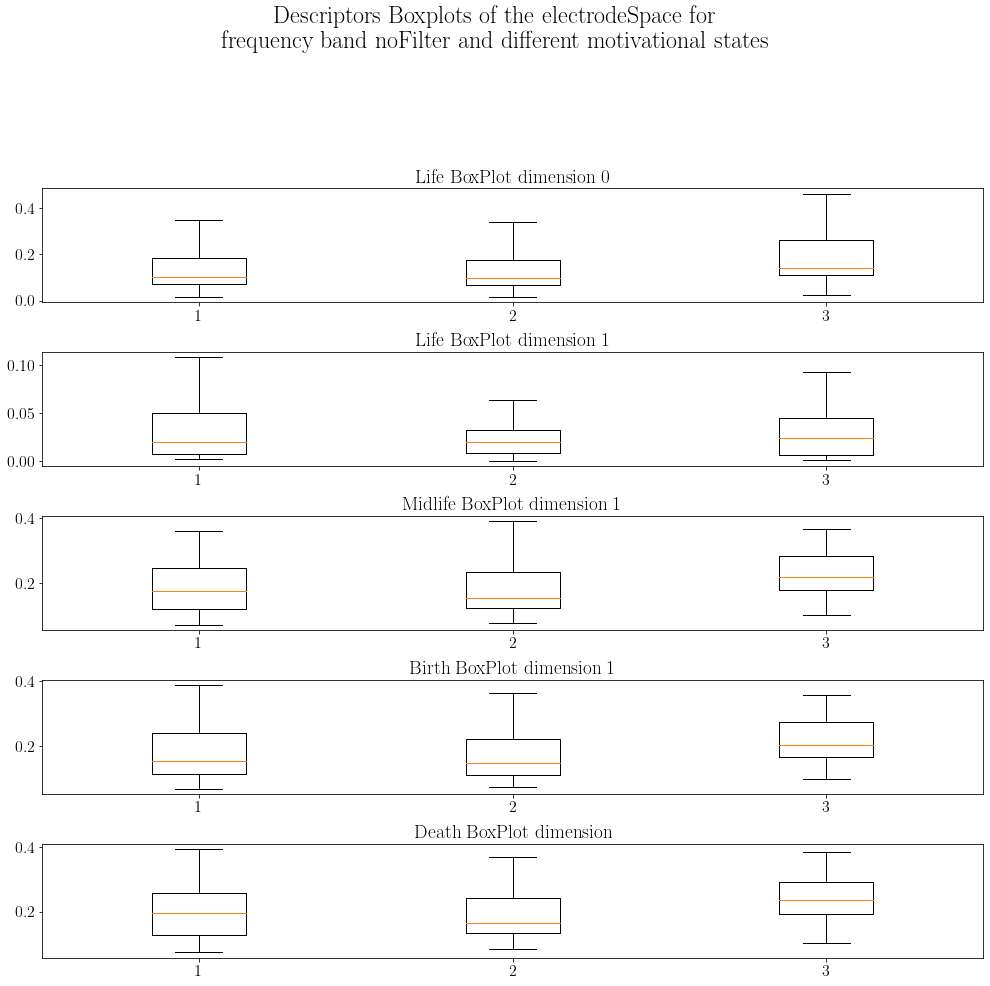

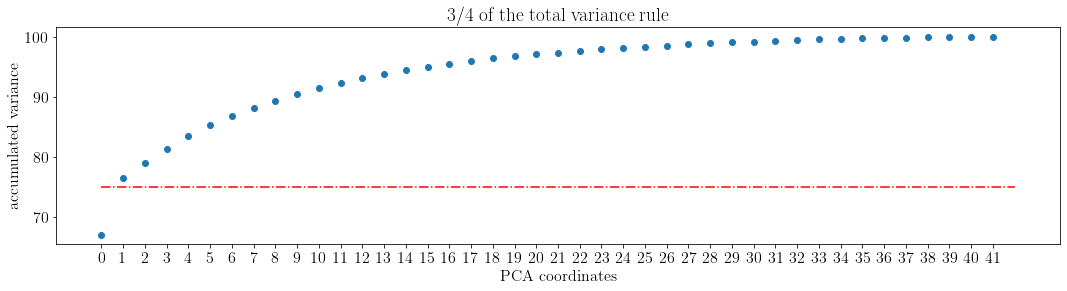

intensities for band  noFilter and session 2
0.14084524313608807 minuts for classification


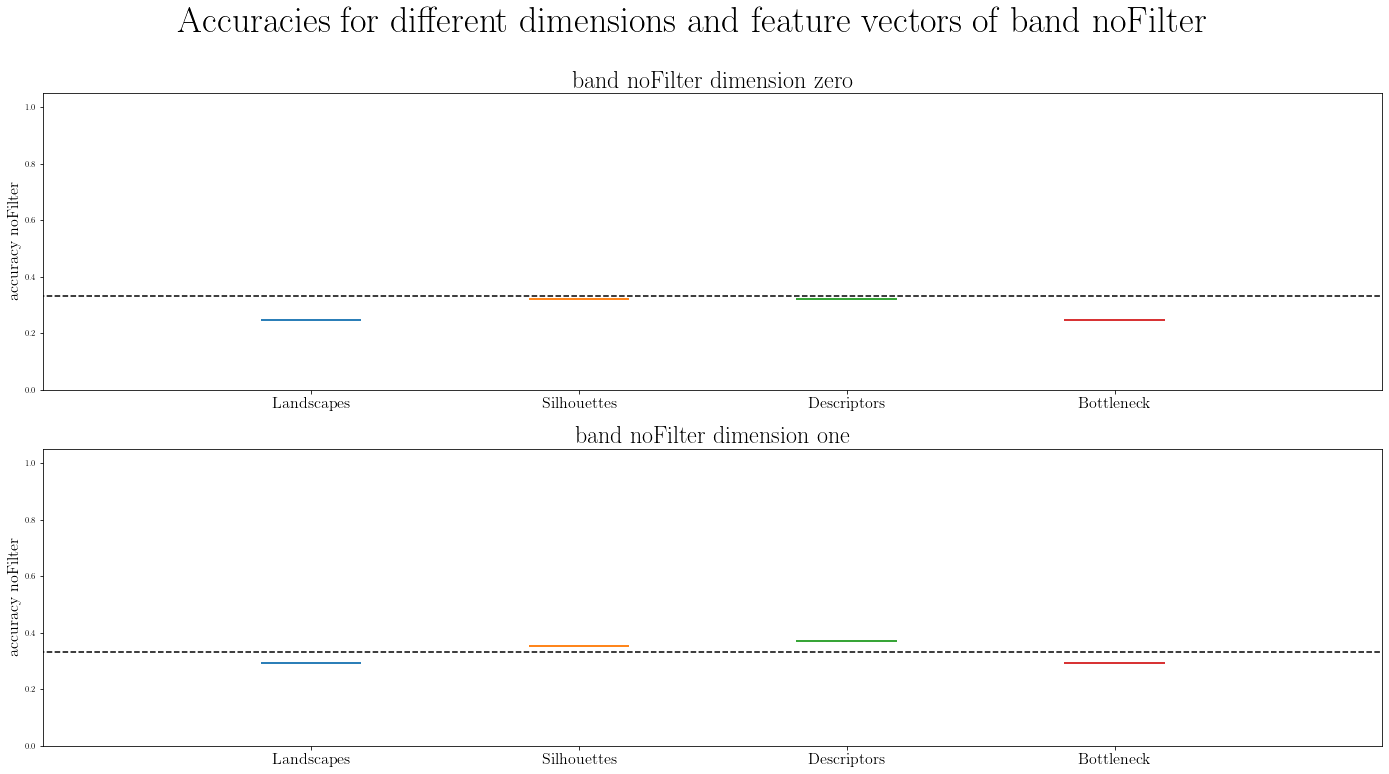

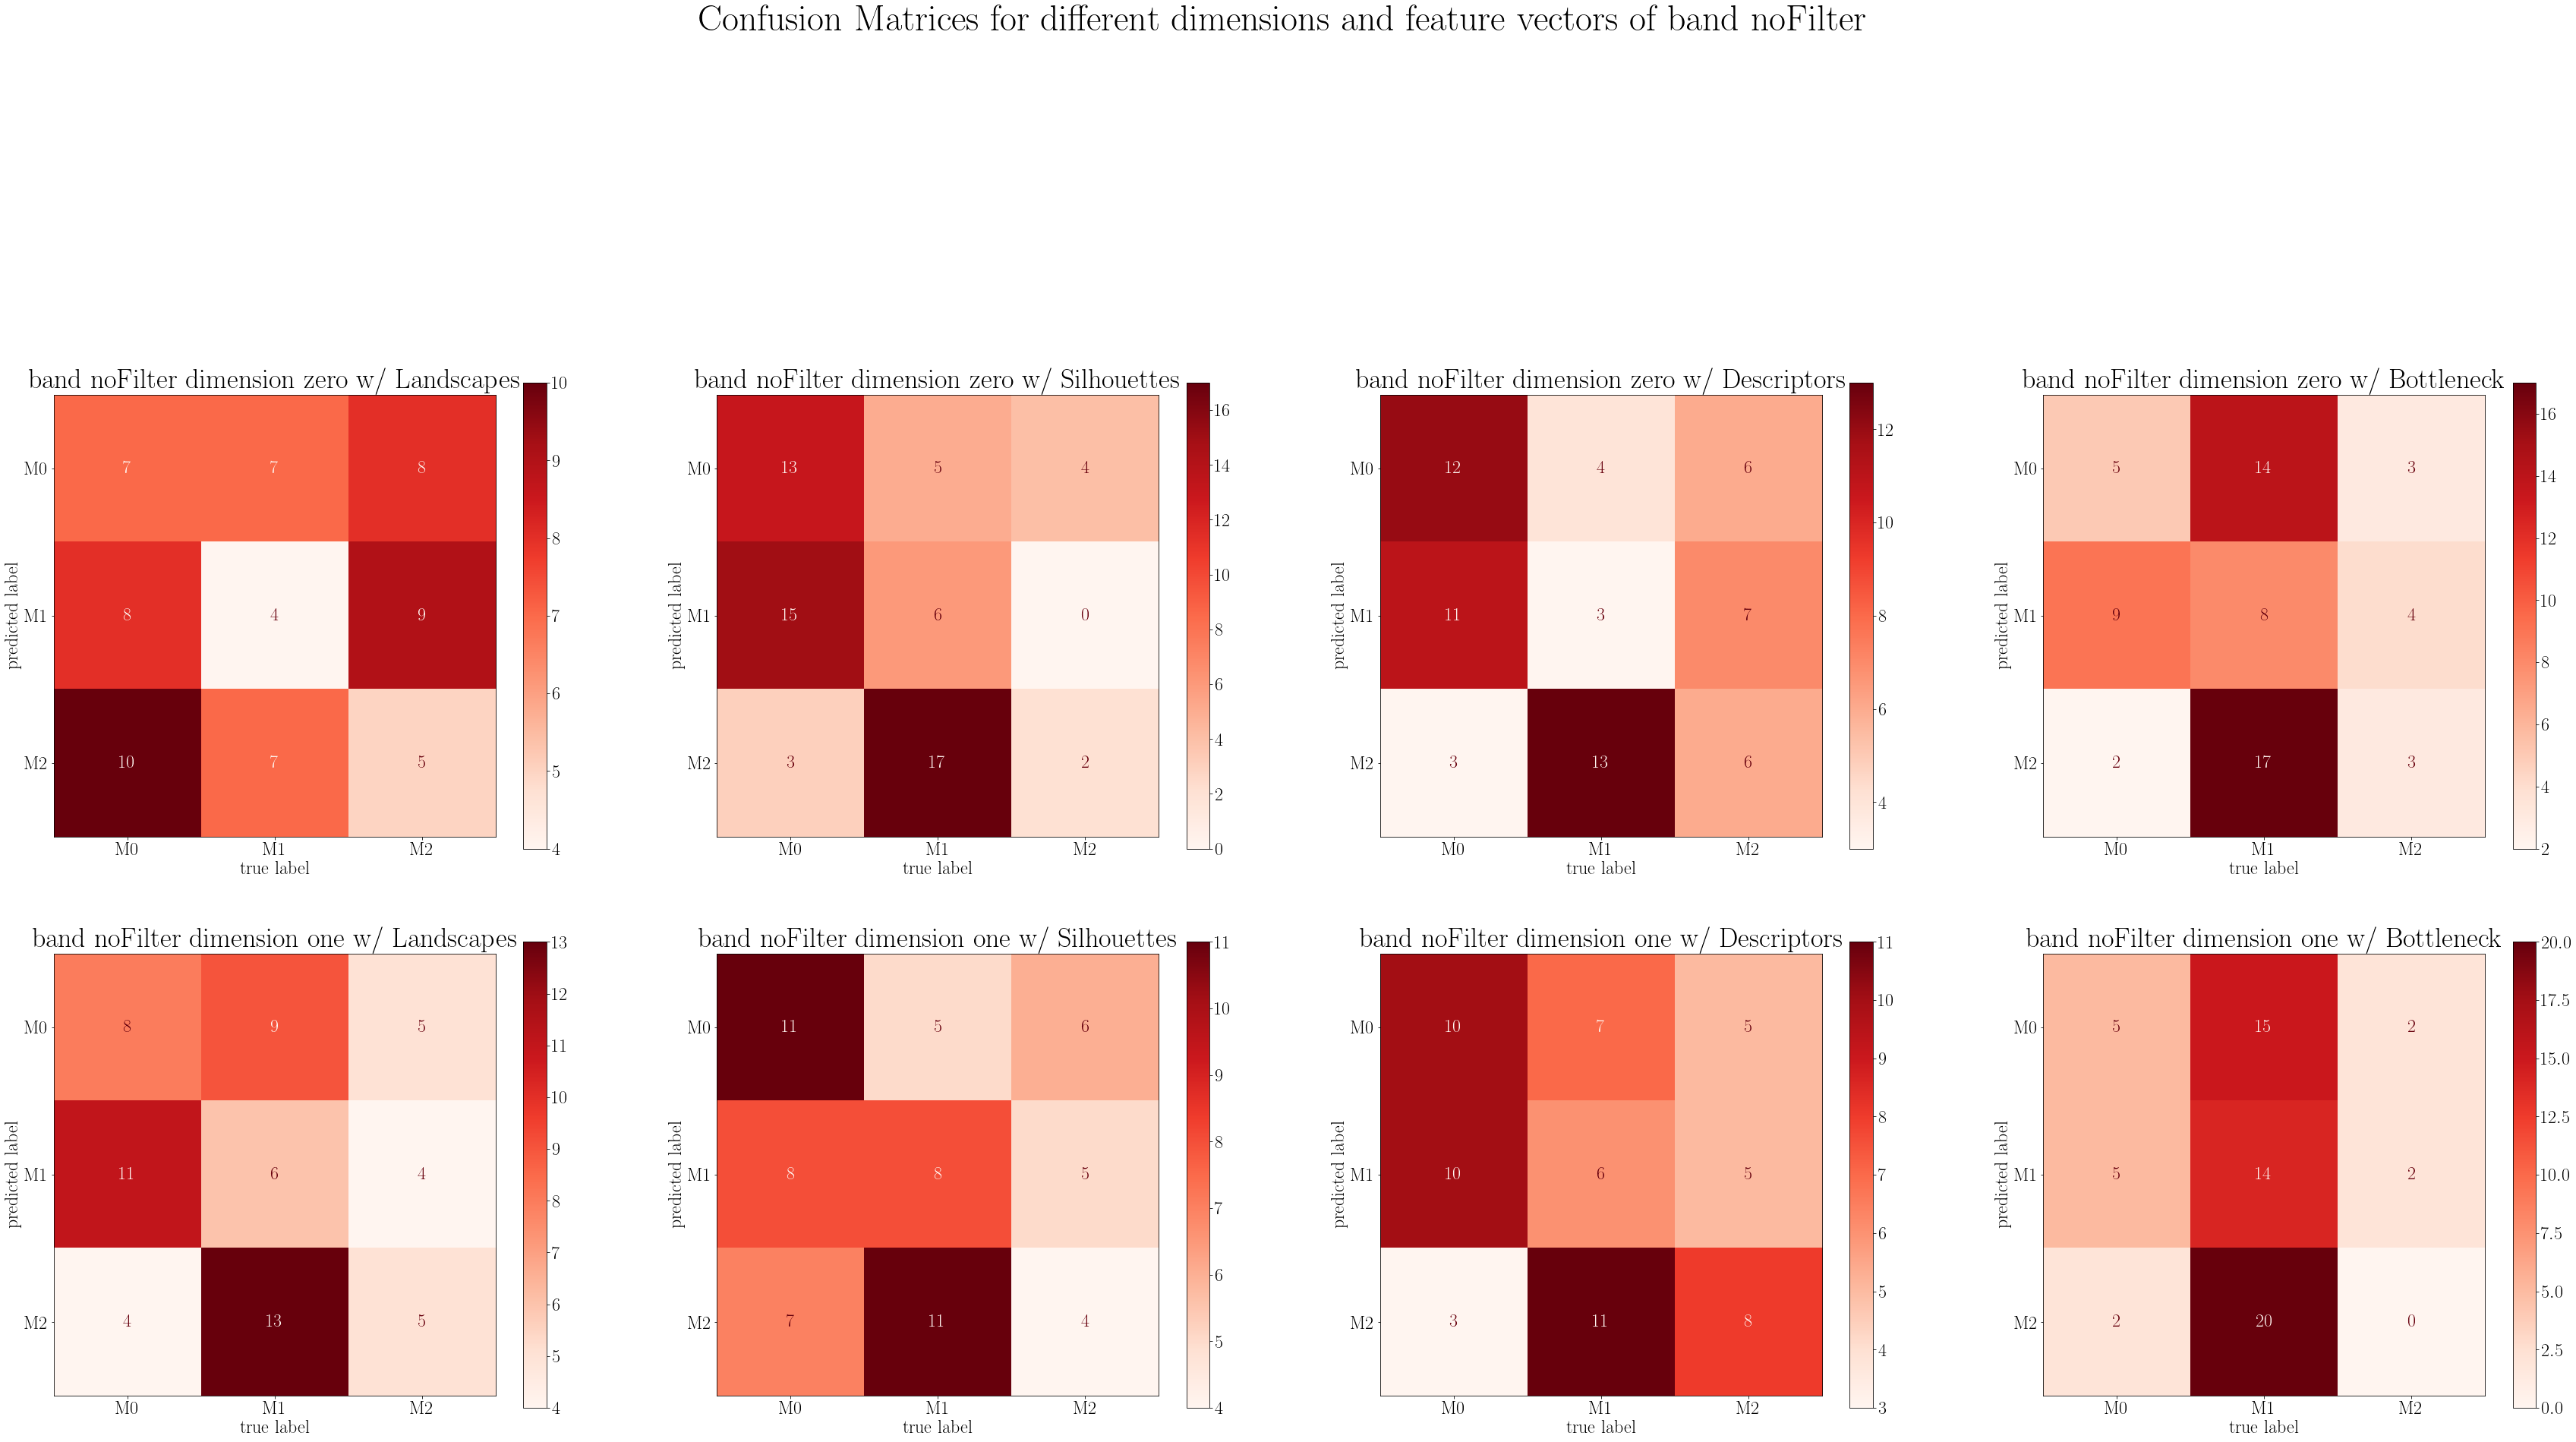

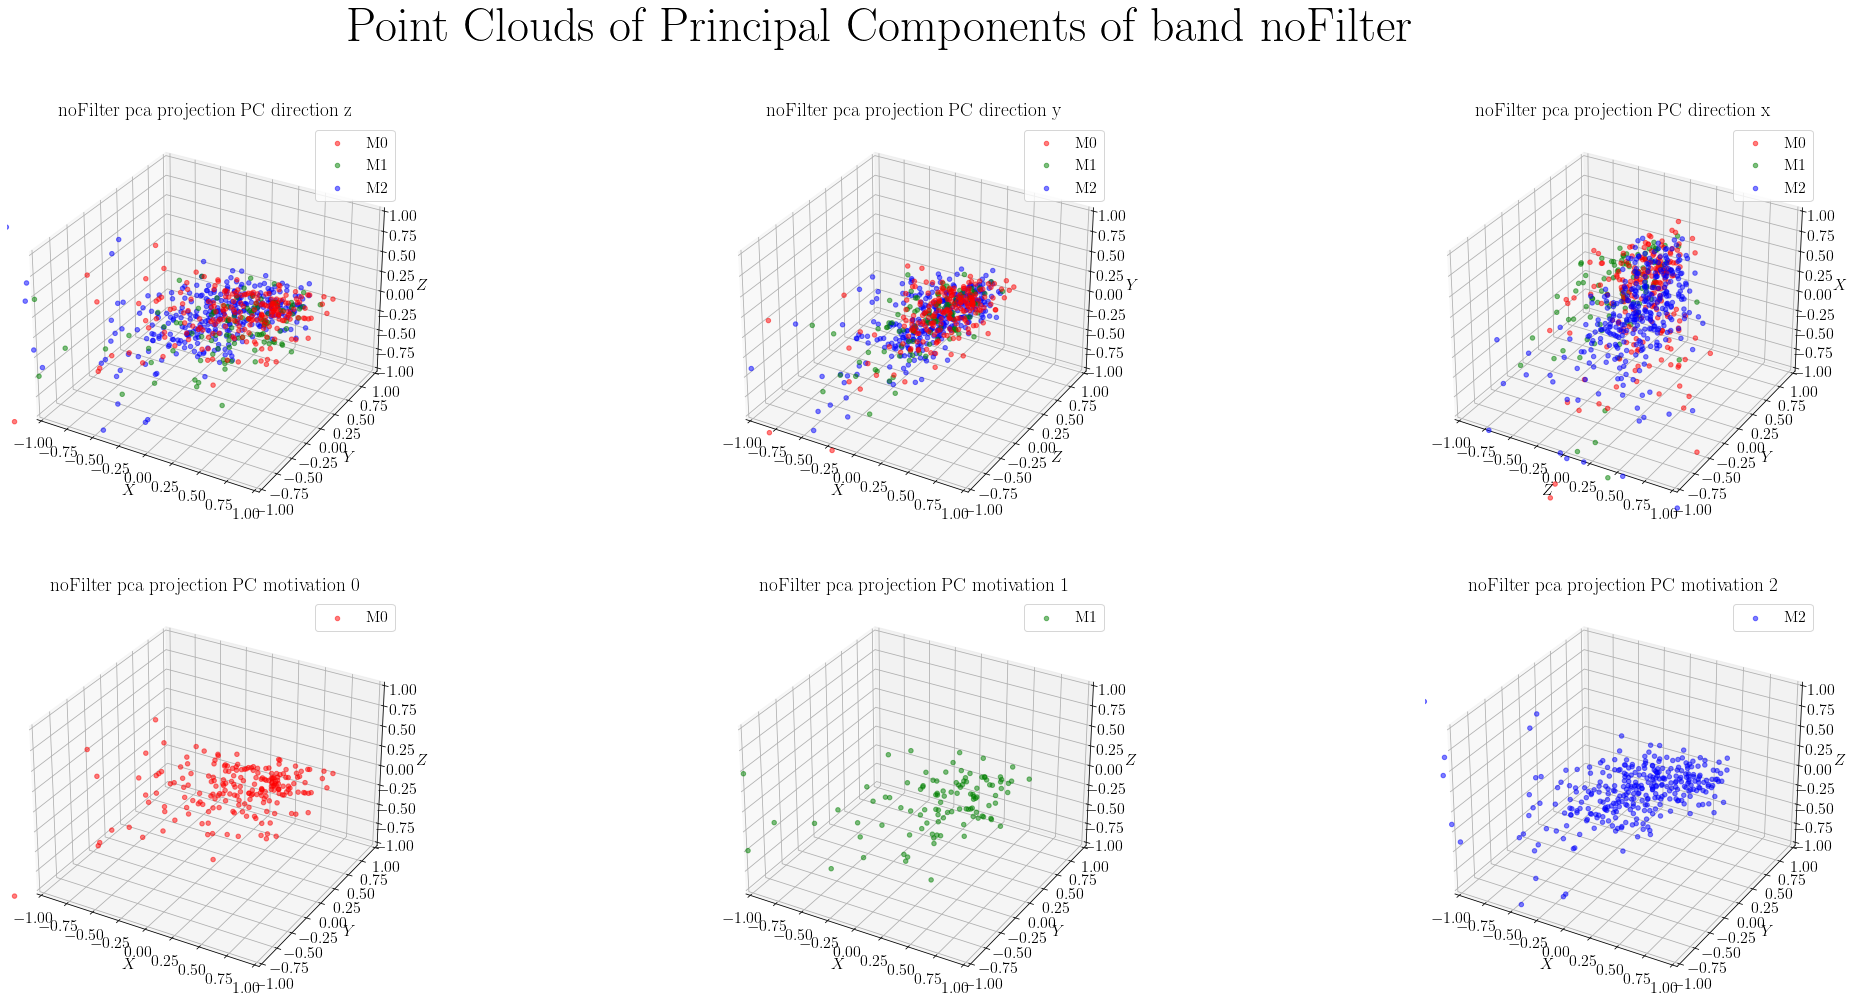

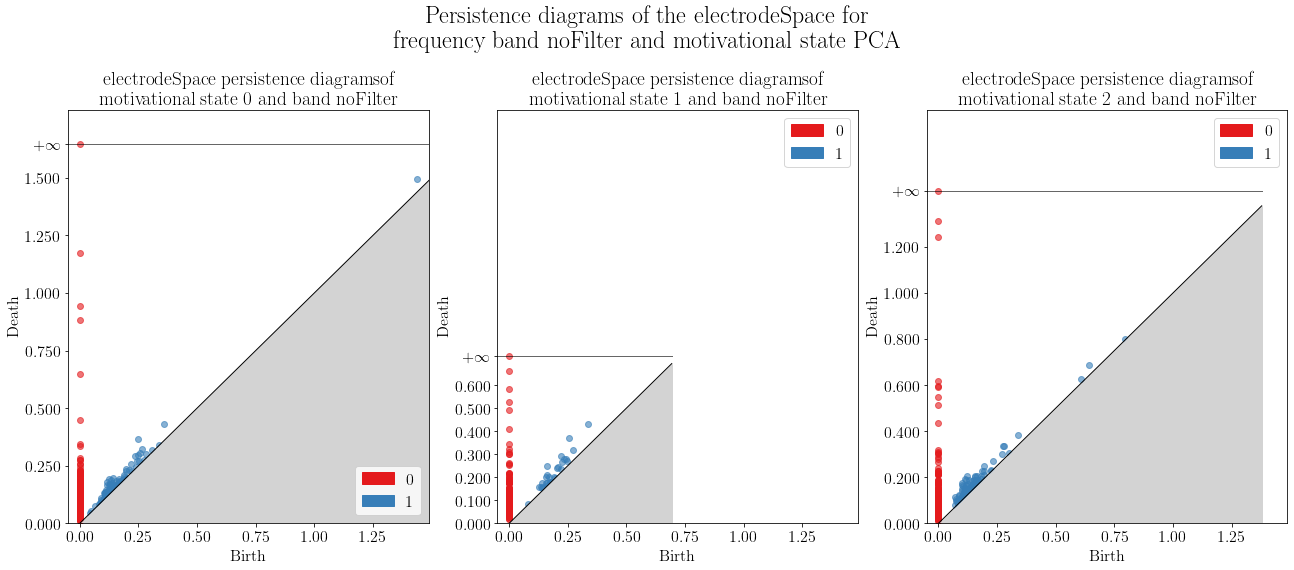

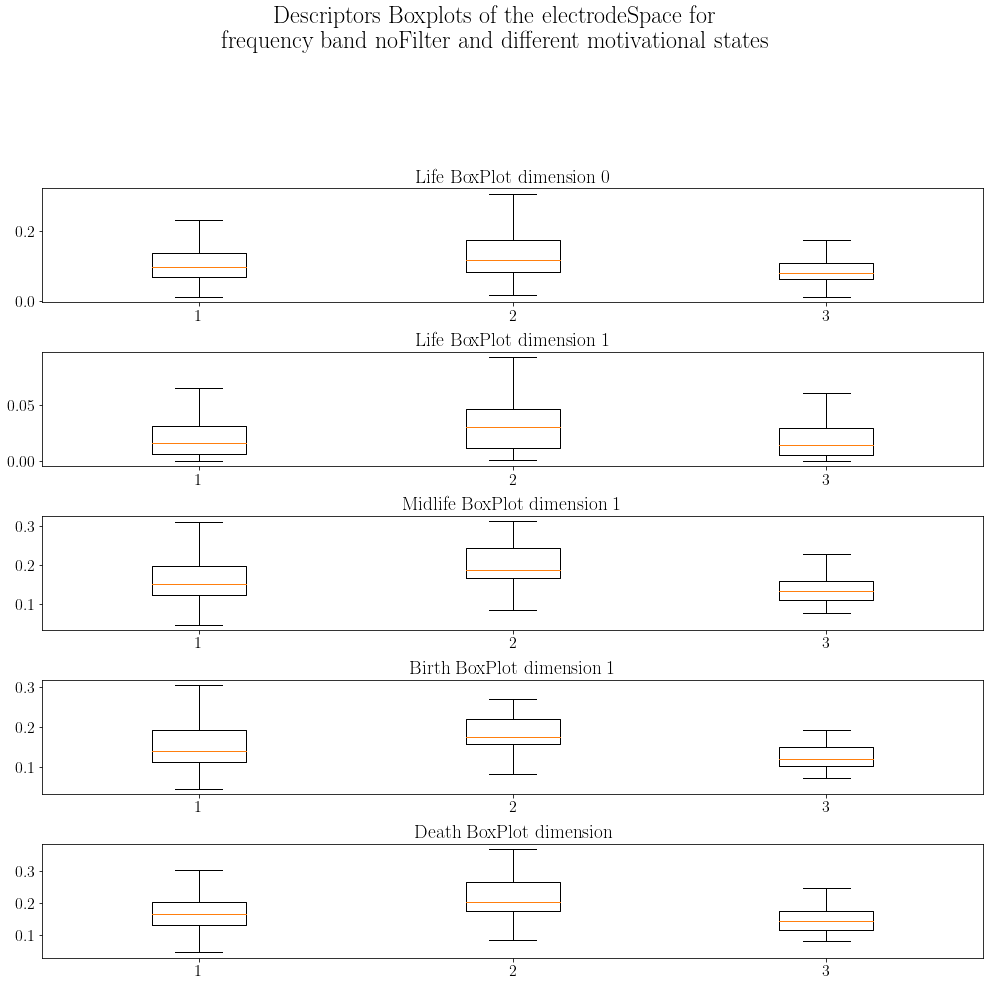

maximum accuracy w/ Silhouette achieved in bloc 1 with band alpha
maximum accuracy w/ Silhouette achieved in bloc 1 with band gamma
======TIME======
2.56889595190684 minuts for pca


In [4]:
subjects=[25]


intensities=False
exploratory=False
classification=False
PCA=True
last=False


bloc_dic={}
bloc_subj_dic={}

bloc_subj_dic[25]=np.array([[1, 2, 8, 3, 5, 4],[6, 7, 2, 10, 1, 9]])

bloc_subj_dic[26]=np.array([[1, 2, 10, 6, 3, 7],[1, 2, 4, 5, 8, 9]])

bloc_subj_dic[27]=np.array([[1, 2, 10, 6, 7, 3],[5, 2, 4, 1, 8, 9]])

bloc_subj_dic[28]=np.array([[1, 2, 9, 7, 4, 6],[5, 3, 2, 8, 1, 10]])

bloc_subj_dic[29]=np.array([[1, 2, 8, 5, 4, 7],[3, 6, 2, 10, 9, 1]])

bloc_subj_dic[30]=np.array([[1, 2, 10, 8, 7, 3],[5, 6, 2, 9, 4, 1]])

bloc_subj_dic[31]=np.array([[1, 3, 2, 5, 8, 10],[4, 5, 1, 6, 2, 7]])

bloc_subj_dic[32]=np.array([[1, 2, 5, 9, 8, 10],[2, 4, 6, 1, 7, 3]])

bloc_subj_dic[33]=np.array([[1, 3, 5, 4, 2 ,6],[8, 2, 10, 9, 1, 7]])

bloc_subj_dic[34]=np.array([[2, 6, 4, 3, 1, 5],[7, 1, 9, 10, 2, 8]])

bloc_subj_dic[35]=np.array([[1, 3, 5, 4, 2, 6],[8, 10, 2, 9, 1, 7]])

bands=[2,1,0,-1] 
n_band=len(bands)
measures=["euclidean","correlation","quaf"]#,"dtw"]

n_measure=len(measures)
dimensions=["zero","one"]

n_dim=len(dimensions)
feat_vect=[DimensionLandScape(),DimensionSilhouette(),TopologicalDescriptors()]
n_vectors=len(feat_vect)

data_table=np.zeros((2*len(subjects),9))
subj_t=0

                    
random_predictions_matrix=np.zeros((n_dim,n_vectors+1))
for subject in subjects:

    space='both'
    data_space,subj_dir,index=load_data(subject,space=space)

    spaces=['electrodeSpace','fontSpace']
    index=index[0]

    cont1=0
    cont2=0
    for ind in range(12):
        if index[ind]==1:
            cont1+=1
            if cont1==2:
                index[ind]=11
        if index[ind]==2:
            cont2+=1
            if cont2==2:
                index[ind]=12 

    bloc_subj_dic[subject][1][bloc_subj_dic[subject][1]<=2]=bloc_subj_dic[subject][1][bloc_subj_dic[subject][1]<=2]+10
    bloc_session=np.where([ind in bloc_subj_dic[subject][1] for ind in index],2,1 )
    for sp in range(1): ##Canviar a 1
        t=time.time()
        space=spaces[sp]

        subject_table=np.zeros((8,11))
        max_acc=np.zeros((2,4))

        if not os.path.exists(subj_dir+space):
            print("create directory(plot):",subj_dir+space)
            os.makedirs(subj_dir+'/'+space)
        print('cleaning and filtering data of',space,'of subject',subject)
        preprocessor=Preprocessor(data_space[sp])
        #filtered_ts_dic=preprocessor.get_filtered_ts_dic()
        ts_band,labels_original=preprocessor.get_trials_and_labels()

        subject_table[:,0]=preprocessor.N


        data_table[subj_t,0]=preprocessor.N
        data_table[subj_t,1]=ts_band.shape[0]
        '''
        if debug:
            ts_band=np.concatenate((ts_band[:50,:],ts_band[432:482,:],ts_band[-50:,:]),axis=0)
            labels=np.concatenate((np.zeros(50),np.ones(50),np.ones(50)*2))'''

        if intensities:
            for i_band in bands:
                print('intensities for band ', i_band)
                PC=np.abs(ts_band[:,i_band,:,:]).mean(axis=1)
                intensity(subj_dir,space,PC,labels_original,i_band)

        data_table[subj_t,2]=(labels_original==0).sum()
        data_table[subj_t,3]=(labels_original==1).sum()
        data_table[subj_t,4]=(labels_original==2).sum()


        blocs=[]
        blocs.append(np.array(list(range(12)))[bloc_session==1])
        blocs.append(np.array(list(range(12)))[bloc_session==2])
        band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'}    
        if PCA: 
            t_pca=time.time()
            N=ts_band.shape[-1]
            persistence={}


            subject_table_index=[]
            table_i=-1
            for i_band in bands:

                persistence[i_band]={}

                bloc_i=1

                PC_all=np.abs(ts_band[:,i_band,:,:]).mean(axis=1)
                PC_all=PC_all.reshape((-1,N))
                labels_all=labels_original

                tr2bl=preprocessor.tr2bl_ol




                for bl in blocs:
                    table_i+=1
                    subject_table_index.append(band_dic[i_band]+str(bloc_i))

                    temp=[tr_bl in bl for tr_bl in tr2bl]
                    PC=PC_all[temp]
                    labels=labels_all[temp]

                    subject_table[table_i,1]=len(labels)
                    subject_table[table_i,2]=len(labels[labels==0])
                    subject_table[table_i,3]=len(labels[labels==1])
                    subject_table[table_i,4]=len(labels[labels==2])


                    data_table[subj_t,4+bloc_i]=PC.shape[0]

                    X =(PC - np.mean(PC, axis=0)).T #X.shape: (42,632)
                    n = X.shape[1]
                    Y =  X.T/np.sqrt(n-1)

                    u, s, vh = la.svd(Y, full_matrices=False)
                    r=np.sum(np.where(s>1e-12,1,0))
                    #pca = vh[:r,:] @ X[:,:] # Principal components
                    variance_prop = s[:r]**2/np.sum(s[:r]**2) # Variance captured
                    acc_variance = np.cumsum(variance_prop)
                    std = s[:r]


                    fig= plt.figure( figsize=(18, 4))

                    # 3/4 of the total variance rule
                    plt.scatter(range(len(acc_variance)),acc_variance*100)
                    plt.xticks(range(len(acc_variance)))
                    plt.hlines(75, xmin=0, xmax=len(std), colors='r', linestyles='dashdot')
                    plt.title('3/4 of the total variance rule')
                    plt.xlabel('PCA coordinates')
                    plt.ylabel('accumulated variance')


                    if not os.path.exists(subj_dir+space+'/PCA/'+band_dic[i_band]+'/session'+str(bloc_i)):
                        print("create directory(plot):",subj_dir+space+'/PCA/'+band_dic[i_band]+'/session'+str(bloc_i) )
                        os.makedirs(subj_dir+space+'/PCA/'+band_dic[i_band]+'/session'+str(bloc_i) )
                    plt.show()
                    #print('acumulated variance:',acc_variance)

                    subject_table[table_i,5]=acc_variance[3]



                    pca = vh[:3,:] @ X[:,:] 
                    pca=pca.T

                    pca,labels=preprocessor.reject_outliers(pca,labels,m=2)


                    subject_table[table_i,6]=len(labels)
                    subject_table[table_i,7]=len(labels[labels==0])
                    subject_table[table_i,8]=len(labels[labels==1])
                    subject_table[table_i,9]=len(labels[labels==2])


                    print('intensities for band ', band_dic[i_band], 'and session', bloc_i)
                    subject_table[table_i,10],random_predictions_matrix,max_acc[bloc_i-1,i_band]=intensity(subj_dir,space+'/PCA/'+band_dic[i_band]+'/session'+str(bloc_i),pca,labels,i_band)


                    plt.rcParams['xtick.labelsize']=16
                    plt.rcParams['ytick.labelsize']=16
                    plt.rcParams.update({'font.size': 16})

                    fig = plt.figure(figsize=[36,16])
                    ax =fig.add_subplot(2, 3, 1, projection='3d')
                    fig.add_axes(ax)
                    #fig.add_subplot(projection='3d')

                    pca_M0=pca[labels==0]
                    pca_M1=pca[labels==1]
                    pca_M2=pca[labels==2]



                    ax.scatter(pca_M0[:,0],pca_M0[:,1],pca_M0[:,2],label='M0',c='r',alpha=0.5,zdir='z')
                    ax.scatter(pca_M1[:,0],pca_M1[:,1],pca_M1[:,2],label='M1',c='g',alpha=0.5,zdir='z')
                    ax.scatter(pca_M2[:,0],pca_M2[:,1],pca_M2[:,2],label='M2',c='b',alpha=0.5,zdir='z')
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC direction z')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$X$')
                    ax.set_ylabel('$Y$')
                    ax.set_zlabel('$Z$')


                    ax = fig.add_subplot(2, 3, 2, projection='3d')
                    fig.add_axes(ax)


                    ax.scatter(pca_M0[:,0],pca_M0[:,1],pca_M0[:,2],label='M0',c='r',alpha=0.5,zdir='y')
                    ax.scatter(pca_M1[:,0],pca_M1[:,1],pca_M1[:,2],label='M1',c='g',alpha=0.5,zdir='y')
                    ax.scatter(pca_M2[:,0],pca_M2[:,1],pca_M2[:,2],label='M2',c='b',alpha=0.5,zdir='y')
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC direction y')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$X$')
                    ax.set_ylabel('$Z$')
                    ax.set_zlabel('$Y$')

                    ax = fig.add_subplot(2, 3, 3, projection='3d')
                    fig.add_axes(ax)


                    ax.scatter(pca_M0[:,0],pca_M0[:,1],pca_M0[:,2],label='M0',c='r',alpha=0.5,zdir='x')
                    ax.scatter(pca_M1[:,0],pca_M1[:,1],pca_M1[:,2],label='M1',c='g',alpha=0.5,zdir='x')
                    ax.scatter(pca_M2[:,0],pca_M2[:,1],pca_M2[:,2],label='M2',c='b',alpha=0.5,zdir='x')
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC direction x')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$Z$')
                    ax.set_ylabel('$Y$')
                    ax.set_zlabel('$X$')

                    ax = fig.add_subplot(2, 3, 4, projection='3d')
                    fig.add_axes(ax)

                    #for bloc in range (12):
                        #ax.scatter(pca_M0[:,0][tr2bl[labels==0]==bloc],pca_M0[:,1][tr2bl[labels==0]==bloc],pca_M0[:,2][tr2bl[labels==0]==bloc],label=bloc,alpha=0.5,zdir='x')
                    ax.scatter(pca_M0[:,0],pca_M0[:,1],pca_M0[:,2],label='M0',alpha=0.5,c='r',zdir='z')
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC motivation 0')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$X$')
                    ax.set_ylabel('$Y$')
                    ax.set_zlabel('$Z$')

                    ax = fig.add_subplot(2, 3, 5, projection='3d')
                    fig.add_axes(ax)

                    #for bloc in range (12):
                        #ax.scatter(pca_M1[:,0][tr2bl[labels==1]==bloc],pca_M1[:,1][tr2bl[labels==1]==bloc],pca_M1[:,2][tr2bl[labels==1]==bloc],label=bloc,alpha=0.5,zdir='x')
                    ax.scatter(pca_M1[:,0],pca_M1[:,1],pca_M1[:,2],label='M1',alpha=0.5,c='g',zdir='z')
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC motivation 1')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$X$')
                    ax.set_ylabel('$Y$')
                    ax.set_zlabel('$Z$')

                    ax = fig.add_subplot(2, 3, 6, projection='3d')
                    fig.add_axes(ax)

                    #for bloc in range (12):    
                        #ax.scatter(pca_M2[:,0][tr2bl[labels==2]==bloc],pca_M2[:,1][tr2bl[labels==2]==bloc],pca_M2[:,2][tr2bl[labels==2]==bloc],label=bloc,alpha=0.5,zdir='x')
                    ax.scatter(pca_M2[:,0],pca_M2[:,1],pca_M2[:,2],label='M2',alpha=0.5,c='b',zdir='z')    
                    ax.legend()
                    ax.set_title(band_dic[i_band]+' pca projection PC motivation 2')

                    ax.set_xlim3d(-1, 1)
                    ax.set_ylim3d(-1, 1)
                    ax.set_zlim3d(-1, 1)

                    ax.set_xlabel('$X$')
                    ax.set_ylabel('$Y$')
                    ax.set_zlabel('$Z$')
                    
                    fig.suptitle('Point Clouds of Principal Components of band '+band_dic[i_band] ,fontsize=48)
                    
                    plt.show()


                    pca_list=[pca_M0,pca_M1,pca_M2]
                    band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'}


                    for i in range(3):

                        n_coor = pca_list[i].shape[0]
                        matrix = np.ones((n_coor, n_coor))
                        row,col = np.triu_indices(n_coor,1)
                        distancies=pdist(pca_list[i])
                        matrix[row,col] = distancies
                        matrix[col,row] = distancies


                        Rips_complex_sample = gd.RipsComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                        #Rips_complex_sample = gd.AlphaComplex(distance_matrix=matrix)#,max_edge_length=max_edge)
                        Rips_simplex_tree_sample = Rips_complex_sample.create_simplex_tree(max_dimension=2)
                        persistence[i_band][i]=Rips_simplex_tree_sample.persistence()
                        if persistence[i_band][i]==[]:
                            persistence[i_band][i]=[(0,(0.0,0.0))]



                    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
                    plot_func=lambda x,axes: gd.plot_persistence_diagram(x,legend=True,max_intervals=1000,axes=axes)#,inf_delta=0.5)

                    aux_lis=np.array([persistence[i_band][0],persistence[i_band][1],persistence[i_band][2]], dtype=object)
                    x_max=np.amax(list(map(lambda y: np.amax(list(map(lambda x: x[1][0],y))),aux_lis)))+0.05
                    y_max=np.amax(list(map(lambda y: np.amax(list(map(lambda x: x[1][1] if x[1][1]!=np.inf  else 0 ,y))),aux_lis)))*1.2
                    for j in range(3):
                        a=plot_func(persistence[i_band][j],axes=axes[j])
                        a.set_title('{0} persistence diagramsof \n motivational state {1} and band {2}'.format(space,j,band_dic[i_band]))
                        a.set_xlim(-0.05,x_max)
                        a.set_ylim(0,y_max)
                    fig.suptitle('Persistence diagrams of the {0} for\n frequency band {1} and motivational state PCA'.format(space,band_dic[i_band]),fontsize=24)
                    fig.tight_layout(pad=0.5)
                    fig.subplots_adjust(top=0.8)
                    plt.show()



                    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 14))
                    vect0,vect1=[0,0,0],[0,0,0]
                    for i in range(3):
                        dim_list=np.array(list(map(lambda x: x[0], persistence[i_band][i])))
                        point_list=np.array(list(map(lambda x: x[1], persistence[i_band][i])))
                        zero_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==0)]
                        one_dim=point_list[np.logical_and(point_list[:,1]!=float('inf'),dim_list==1)]


                        descriptors_computer=TopologicalDescriptorsNocl()
                        descriptors_computer.fit((zero_dim,one_dim))
                        vect0[i],vect1[i]=descriptors_computer.transform((zero_dim,one_dim))



                    axes[0].boxplot([vect0[0][0],vect0[1][0],vect0[2][0]],showfliers=False)
                    axes[0].set_title('Life BoxPlot dimension 0')
                    axes[1].boxplot([vect1[0][0],vect1[1][0],vect1[2][0]],showfliers=False)
                    axes[1].set_title('Life BoxPlot dimension 1')

                    axes[2].boxplot([vect1[0][2],vect1[1][2],vect1[2][2]],showfliers=False)
                    axes[2].set_title('Midlife BoxPlot dimension 1')
                    axes[3].boxplot([vect1[0][3],vect1[1][3],vect1[2][3]],showfliers=False)
                    axes[3].set_title('Birth BoxPlot dimension 1')

                    axes[4].boxplot([vect1[0][4],vect1[1][4],vect1[2][4]],showfliers=False)
                    axes[4].set_title('Death BoxPlot dimension')

                    fig.suptitle('Descriptors Boxplots of the {0} for\n frequency band {1} and different motivational states'.format(space,band_dic[i_band]),fontsize=24)
                    fig.tight_layout(pad=1.00)
                    fig.subplots_adjust(top=0.8)
                    plt.show()
                    bloc_i+=1
            max_bloc1=np.argmax(max_acc[0,:])
            print('maximum accuracy w/ Silhouette achieved in bloc 1 with band',band_dic[max_bloc1])##en data table
            max_bloc2=np.argmax(max_acc[1,:])
            print('maximum accuracy w/ Silhouette achieved in bloc 1 with band',band_dic[max_bloc2])
            if max_bloc1==3:
                max_bloc1=-1
            data_table[subj_t,7]=max_acc[0,max_bloc1]
            if max_bloc2==3:
                max_bloc2=-1
            data_table[subj_t,8]=max_acc[1,max_bloc2]
            
            subj_t=subj_t+1

            subject_table=pd.DataFrame(subject_table,index=subject_table_index,columns=['Clean Channels','N. trials','M0','M1','M2','captured variance after PCA','N. trials w/o Outliers ','M0 w/o Outliers ','M1 w/o Outliers ','M2 w/o Outliers ','test size'])
            #subject_table.to_csv(subj_dir+space+'/PCA/subject_table.csv')

            random_predictions_matrix=pd.DataFrame(random_predictions_matrix,columns=['dimension 0','dimension 1'],index=['Landscapes','Silhouettes','Descriptors','Bottleneck'])
            #random_predictions_matrix.to_csv(subj_dir+space+'/PCA/random_preds.csv')
        print('======TIME======')    
        print((time.time()-t_pca)/60, 'minuts for pca')

In [5]:
data_table

array([[4.20000000e+01, 1.29600000e+03, 4.32000000e+02, 4.32000000e+02,
        4.32000000e+02, 6.48000000e+02, 6.48000000e+02, 3.96825397e-01,
        3.84615385e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [6]:
random_predictions_matrix

dimension 0  dimension 1
Landscapes          55.0         22.0
Silhouettes          0.0         22.0
Descriptors          0.0         22.0
Bottleneck           0.0          0.0